In [2]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion,
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

In [4]:
modeWeightsOrig = pd.read_csv(r'Mode_Weight_Full_Cohort.csv',index_col='Mesh_ID')
print(modeWeightsOrig)

               Mode1      Mode2      Mode3      Mode4      Mode5      Mode6  \
Mesh_ID                                                                       
1         -26.526282 -21.987510  45.298672   6.964297   1.264487 -14.710058   
2         -16.902798  23.644504  19.452896 -24.329813 -25.447350  20.415574   
3          14.528402  16.328970  -5.269040  31.653975   7.173021  17.494031   
4         -15.076964  28.889168   8.644859   4.758042   1.301095   5.983310   
5          -3.839848 -47.723637   7.042452  -4.914959  -4.014415  20.366371   
6          18.372208 -13.173184 -10.191443 -24.148353   5.156296  -5.613573   
7         -34.355273 -16.804885  -6.838693 -12.785964   5.546781 -11.206395   
8         -25.433101   7.377060  16.518874  10.553323  20.454561  -3.834116   
11         80.119501   6.505305   4.707190  18.693887 -17.988034  -9.927770   
12         51.114176 -25.099497  -6.603593  -1.858095   2.108524   6.369323   
13          2.227391  21.550335  14.556385 -15.90453

In [5]:
modelOutputOrig = pd.read_csv(r'simulation_output_Full_Cohort.csv',index_col=0)
print(modelOutputOrig)

            EDV_LV  Myo_vol_LV  ESV_LV   SV_LV    V1_LV     EF1_LV  \
Mesh_ID                                                              
1          119.650  163.305835  55.614  64.036   90.248  24.573339   
2          128.603  202.159662  51.027  77.576   98.402  23.483900   
3          152.279  154.973015  65.778  86.501  110.147  27.667636   
4          145.034  199.463111  57.180  87.854  105.630  27.168802   
5          118.599   91.976665  55.855  62.744   94.714  20.139293   
6           85.968  109.660211  40.184  45.784   68.640  20.156337   
7          113.130   94.998853  49.677  63.453   84.963  24.897905   
8          142.547  135.194656  64.998  77.549  107.610  24.509109   
11         140.874  140.723552  65.420  75.454  107.909  23.400344   
12         101.382  101.575101  45.137  56.245   77.413  23.642264   
13         139.551  152.838953  59.194  80.357  103.644  25.730378   
14         176.987  167.319878  79.883  97.104  129.387  26.894631   
15         103.318  

In [22]:
nMod = modelOutputOrig.shape[1]
X = modeWeightsOrig.values
xlabels = list(modeWeightsOrig.columns)
likelihood = GaussianLikelihood()
mean_function = LinearMean(input_size=dataset.input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError()]
MSEs=[]
for i in range(nMod):

    y = modelOutputOrig.iloc[:,i].values
    ylabel=modelOutputOrig.columns[i]
    dataset = Dataset(
    X,
    y,
    x_labels=xlabels,
    y_label=ylabel
    )
    experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,
    learn_noise=True,
    )
    device = "cpu"
    devices = [device]
    kfcv = KFoldCrossValidation(experiment, devices, n_splits=51, max_workers=1)

    optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
    esc = GLEarlyStoppingCriterion(
    max_epochs=1000, alpha=0.1, patience=50
    )
    best_model_dct, best_train_stats_dct, best_scores = kfcv.train(
    optimizer,
    esc,
    leftout_is_val=True
    )
    # resulting mean test scores
    MSE=0
    for key in best_scores.keys():
        MSE += best_scores[key]['MeanSquaredError']/51
    
    MSEs.append(MSE)
    print(i)
    print(MSE)

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 50
-Discrepancy: 2.3272
-Validation data available: No
-Testing data available: Yes (size = 1)
0
2.069016846974252
TestExperiment dataset loaded.
Notes

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['PeakP_LV']
-Sample size: 50
-Discrepancy: 2.3272
-Validation data available: No
-Testing data available: Yes (size = 1)
8
8.88743714832555
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['tpeak_LV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No
TestExperiment dataset loaded.
No

KeyboardInterrupt: 

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No


In [14]:
# k-fold cross-validation training
from GPErks.perks.cross_validation import KFoldCrossValidation
from GPErks.train.early_stop import GLEarlyStoppingCriterion



TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 50
-Discrepancy: 2.3272
-Validation data available: No
-Testing data available: Yes (size = 1)


In [15]:
best_scores

{0: {'MeanSquaredError': array(8.372835, dtype=float32)},
 1: {'MeanSquaredError': array(0.60345703, dtype=float32)},
 2: {'MeanSquaredError': array(0.17259957, dtype=float32)},
 3: {'MeanSquaredError': array(4.207456, dtype=float32)},
 4: {'MeanSquaredError': array(0.00151101, dtype=float32)},
 5: {'MeanSquaredError': array(0.1289421, dtype=float32)},
 6: {'MeanSquaredError': array(0.00576039, dtype=float32)},
 7: {'MeanSquaredError': array(2.5299811, dtype=float32)},
 8: {'MeanSquaredError': array(1.9666536, dtype=float32)},
 9: {'MeanSquaredError': array(0.56104755, dtype=float32)},
 10: {'MeanSquaredError': array(0.36108845, dtype=float32)},
 11: {'MeanSquaredError': array(0.01772844, dtype=float32)},
 12: {'MeanSquaredError': array(0.7446487, dtype=float32)},
 13: {'MeanSquaredError': array(2.0315034, dtype=float32)},
 14: {'MeanSquaredError': array(2.9703052, dtype=float32)},
 15: {'MeanSquaredError': array(2.4228213, dtype=float32)},
 16: {'MeanSquaredError': array(1.4046894, dt

In [17]:
MSE

2.069016846974252

In [31]:
nMod = modelOutputOrig.shape[1]
X = modeWeightsOrig.values
xlabels = list(modeWeightsOrig.columns)
likelihood = GaussianLikelihood()
mean_function = LinearMean(input_size=dataset.input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError()]
MSEs=[]
best_MSE=[]
for i in range(nMod):

    y = modelOutputOrig.iloc[:,i].values
    ylabel=modelOutputOrig.columns[i]
    dataset = Dataset(
    X,
    y,
    x_labels=xlabels,
    y_label=ylabel
    )
    experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,
    learn_noise=True,
    )
    device = "cpu"
    devices = [device]
    kfcv = KFoldCrossValidation(experiment, devices, n_splits=10, max_workers=1)

    optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
    esc = GLEarlyStoppingCriterion(
    max_epochs=1000, alpha=0.1, patience=20
    )
    best_model_dct, best_train_stats_dct, best_scores = kfcv.train(
    optimizer,
    esc,
    leftout_is_val=True
    )
    # resulting mean test scores
    MSE=0
    for key in best_scores.keys():
        MSE += best_scores[key]['MeanSquaredError']/10
    
    MSEs.append(MSE)
    
    scores=[]
    for key in best_scores.keys():
        scores.append(best_scores[key]['MeanSquaredError'])            
                
    best_MSE.append(np.min(scores))
    
    print(i)
    print(MSE)

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 45
-Discrepancy: 2.7155
-Validation data available: No
-Testing data available: Yes (size = 6)
0
16.30963265299797
TestExperiment dataset loaded.
Notes

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['PeakP_LV']
-Sample size: 45
-Discrepancy: 2.7155
-Validation data available: No
-Testing data available: Yes (size = 6)
8
17.63595304489136
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['tpeak_LV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No
TestExperiment dataset loaded.
N

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['ESV_RV']
-Sample size: 45
-Discrepancy: 2.7155
-Validation data available: No
-Testing data available: Yes (size = 6)
17
53.99588288068772
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['SV_RV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No
TestExperiment dataset loaded.
Notes

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['tpeak_RV']
-Sample size: 45
-Discrepancy: 2.7155
-Validation data available: No
-Testing data available: Yes (size = 6)
26
173.94826107025148
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['ET_RV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No
TestExperiment dataset loaded.
No

In [32]:
best_MSE

[0.9187845,
 3.4762044,
 0.060210384,
 0.24082696,
 0.54057944,
 0.08394716,
 0.008091545,
 0.0015149035,
 1.6571302,
 4.7965765,
 7.1940813,
 23.06084,
 9.748947,
 10.588056,
 9.669996,
 2.9540746,
 2.4682736,
 0.57369125,
 0.13830301,
 0.010290647,
 5.1415854,
 0.40677077,
 0.41166896,
 0.0028887487,
 0.00012243194,
 1.1636562,
 17.827108,
 10.067066,
 16.914331]

In [33]:
MSEs

[16.30963265299797,
 178.98810830116273,
 9.043821684271098,
 6.405441492795943,
 10.936369132995605,
 1.8472778290510177,
 0.03823163649067283,
 0.00957950809970498,
 17.63595304489136,
 58.02481937408447,
 31.544021606445316,
 105.32451553344728,
 92.21451950073242,
 79.70451335906982,
 91.0595703125,
 276.7499704122543,
 27.521491479873657,
 53.99588288068772,
 90.12106193304062,
 2.180506333522499,
 194.41790962219238,
 5.386199921369553,
 16.698554998636247,
 0.018907369673252107,
 0.0010581501948763617,
 5.525310003757476,
 173.94826107025148,
 58.74353294372558,
 170.03623447418212]

In [34]:
best_models=[]
best_train_stats=[]
emulators=[]
nMod = modelOutputOrig.shape[1]
mse=[]
    
for i in range(nMod):

    X = modeWeightsOrig.values
    y = modelOutputOrig.iloc[:,i].values

    X_, X_test, y_, y_test = train_test_split(
    X,
    y,
    test_size=2,
    random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_,
        y_,
        test_size=2,
        random_state=seed
    )

    xlabels = list(modeWeightsOrig.columns)
    ylabel=modelOutputOrig.columns[i]

    from GPErks.gp.data.dataset import Dataset
    dataset = Dataset(
        X,
        y,
        #X_val=X_val,
        #y_val=y_val,
        #X_test=X_test,
        #y_test=y_test,
        x_labels=xlabels,
        y_label=ylabel
    )

    likelihood = GaussianLikelihood()
    mean_function = LinearMean(input_size=dataset.input_size)
    kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
    metrics = [MeanSquaredError(), R2Score()]

    experiment = GPExperiment(
        dataset,
        likelihood,
        mean_function,
        kernel,
        n_restarts=5,
        metrics=metrics,
        seed=seed,  # reproducible training
        learn_noise=True
    )

    device = "cpu"
    optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

    emulator = GPEmulator(experiment, device)
    best_model, best_train_stat = emulator.train(optimizer);
    mean,std=emulator.predict(modeWeightsOrig.values)
    mse.append(((mean-modelOutputOrig.iloc[:,i].values)**2).mean())
    print(mean)
    print(modelOutputOrig.iloc[:,i].values)
    emulators.append(emulator)
    best_models.append(best_model)
    best_train_stats.append(best_train_stat)

INFO:2023-06-30 12:42:34,116:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:42:34,124:emulator:train:L100: Running restart 1...


TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13', 'Mode14', 'Mode15', 'Mode16', 'Mode17', 'Mode18']
-Output size: 1
-Output feature: ['EDV_LV']
-Sample size: 51
-Discrepancy: 2.2676
-Validation data available: No
-Testing data available: No


C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\gpytorch\models\exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2023-06-30 12:42:34,936:emulator:_train_once:L316: [  1/100] Training Loss: 1.8305 - MeanSquaredError: 0.1861 - R2Score: 0.8139
INFO:2023-06-30 12:42:34,951:emulator:_train_once:L316: [  2/100] Training Loss: 1.6079 - MeanSquaredError: 0.1783 - R2Score: 0.8217
INFO:2023-06-30 12:42:34,966:emulator:_train_once:L316: [  3/100] Training Loss: 1.5761 - MeanSquaredError: 0.1636 - R2Score: 0.8364
INFO:2023-06-30 12:42:34,981:emulator:_train_once:L316: [  4/100] Training Loss: 1.4816 - MeanSquaredError: 0.1461 - R2Score: 0.8539
INFO:2023-06-30 12:42:35,009:emulator:_train_once:L316: [  5/100] Training Loss: 1.3758 - MeanSquaredError: 0.1300 - R2Score: 0.8700
INFO:2023-06-30 12:42:35,027:emulator:_train_once:L316: [  6/100] Training Loss: 1.2990 - MeanSquaredError: 0.1161 - R2Score: 0.8

INFO:2023-06-30 12:42:35,977:emulator:_train_once:L316: [ 61/100] Training Loss: -0.5724 - MeanSquaredError: 0.0042 - R2Score: 0.9958
INFO:2023-06-30 12:42:35,988:emulator:_train_once:L316: [ 62/100] Training Loss: -0.5887 - MeanSquaredError: 0.0041 - R2Score: 0.9959
INFO:2023-06-30 12:42:35,999:emulator:_train_once:L316: [ 63/100] Training Loss: -0.6063 - MeanSquaredError: 0.0041 - R2Score: 0.9959
INFO:2023-06-30 12:42:36,012:emulator:_train_once:L316: [ 64/100] Training Loss: -0.6248 - MeanSquaredError: 0.0040 - R2Score: 0.9960
INFO:2023-06-30 12:42:36,030:emulator:_train_once:L316: [ 65/100] Training Loss: -0.6437 - MeanSquaredError: 0.0040 - R2Score: 0.9960
INFO:2023-06-30 12:42:36,045:emulator:_train_once:L316: [ 66/100] Training Loss: -0.6628 - MeanSquaredError: 0.0039 - R2Score: 0.9961
INFO:2023-06-30 12:42:36,059:emulator:_train_once:L316: [ 67/100] Training Loss: -0.6823 - MeanSquaredError: 0.0039 - R2Score: 0.9961
INFO:2023-06-30 12:42:36,073:emulator:_train_once:L316: [ 68/1

INFO:2023-06-30 12:42:36,790:emulator:_train_once:L316: [ 22/100] Training Loss: 1.1979 - MeanSquaredError: 0.3336 - R2Score: 0.6664
INFO:2023-06-30 12:42:36,802:emulator:_train_once:L316: [ 23/100] Training Loss: 1.1812 - MeanSquaredError: 0.3185 - R2Score: 0.6815
INFO:2023-06-30 12:42:36,814:emulator:_train_once:L316: [ 24/100] Training Loss: 1.1668 - MeanSquaredError: 0.3001 - R2Score: 0.6999
INFO:2023-06-30 12:42:36,829:emulator:_train_once:L316: [ 25/100] Training Loss: 1.1483 - MeanSquaredError: 0.2761 - R2Score: 0.7239
INFO:2023-06-30 12:42:36,842:emulator:_train_once:L316: [ 26/100] Training Loss: 1.1227 - MeanSquaredError: 0.2494 - R2Score: 0.7506
INFO:2023-06-30 12:42:36,853:emulator:_train_once:L316: [ 27/100] Training Loss: 1.0920 - MeanSquaredError: 0.2249 - R2Score: 0.7751
INFO:2023-06-30 12:42:36,865:emulator:_train_once:L316: [ 28/100] Training Loss: 1.0605 - MeanSquaredError: 0.2048 - R2Score: 0.7952
INFO:2023-06-30 12:42:36,877:emulator:_train_once:L316: [ 29/100] Tra

INFO:2023-06-30 12:42:37,576:emulator:_train_once:L316: [ 84/100] Training Loss: -1.0223 - MeanSquaredError: 0.0039 - R2Score: 0.9961
INFO:2023-06-30 12:42:37,592:emulator:_train_once:L316: [ 85/100] Training Loss: -0.9956 - MeanSquaredError: 0.0043 - R2Score: 0.9957
INFO:2023-06-30 12:42:37,603:emulator:_train_once:L316: [ 86/100] Training Loss: -0.7842 - MeanSquaredError: 0.0051 - R2Score: 0.9949
INFO:2023-06-30 12:42:37,617:emulator:_train_once:L316: [ 87/100] Training Loss: -0.3610 - MeanSquaredError: 0.0041 - R2Score: 0.9959
INFO:2023-06-30 12:42:37,629:emulator:_train_once:L316: [ 88/100] Training Loss: -0.9749 - MeanSquaredError: 0.0049 - R2Score: 0.9951
INFO:2023-06-30 12:42:37,640:emulator:_train_once:L316: [ 89/100] Training Loss: -0.6374 - MeanSquaredError: 0.0042 - R2Score: 0.9958
INFO:2023-06-30 12:42:37,654:emulator:_train_once:L316: [ 90/100] Training Loss: -1.0350 - MeanSquaredError: 0.0046 - R2Score: 0.9954
INFO:2023-06-30 12:42:37,667:emulator:_train_once:L316: [ 91/1

INFO:2023-06-30 12:42:38,366:emulator:_train_once:L316: [ 45/100] Training Loss: -0.0334 - MeanSquaredError: 0.0047 - R2Score: 0.9953
INFO:2023-06-30 12:42:38,378:emulator:_train_once:L316: [ 46/100] Training Loss: -0.0572 - MeanSquaredError: 0.0045 - R2Score: 0.9955
INFO:2023-06-30 12:42:38,390:emulator:_train_once:L316: [ 47/100] Training Loss: -0.0792 - MeanSquaredError: 0.0044 - R2Score: 0.9956
INFO:2023-06-30 12:42:38,401:emulator:_train_once:L316: [ 48/100] Training Loss: -0.0995 - MeanSquaredError: 0.0043 - R2Score: 0.9957
INFO:2023-06-30 12:42:38,414:emulator:_train_once:L316: [ 49/100] Training Loss: -0.1180 - MeanSquaredError: 0.0042 - R2Score: 0.9958
INFO:2023-06-30 12:42:38,428:emulator:_train_once:L316: [ 50/100] Training Loss: -0.1347 - MeanSquaredError: 0.0041 - R2Score: 0.9959
INFO:2023-06-30 12:42:38,439:emulator:_train_once:L316: [ 51/100] Training Loss: -0.1497 - MeanSquaredError: 0.0040 - R2Score: 0.9960
INFO:2023-06-30 12:42:38,451:emulator:_train_once:L316: [ 52/1

INFO:2023-06-30 12:42:39,135:emulator:_train_once:L316: [  6/100] Training Loss: 1.5010 - MeanSquaredError: 0.6063 - R2Score: 0.3937
INFO:2023-06-30 12:42:39,148:emulator:_train_once:L316: [  7/100] Training Loss: 1.5021 - MeanSquaredError: 0.6120 - R2Score: 0.3880
INFO:2023-06-30 12:42:39,159:emulator:_train_once:L316: [  8/100] Training Loss: 1.5064 - MeanSquaredError: 0.6097 - R2Score: 0.3903
INFO:2023-06-30 12:42:39,170:emulator:_train_once:L316: [  9/100] Training Loss: 1.5067 - MeanSquaredError: 0.5942 - R2Score: 0.4058
INFO:2023-06-30 12:42:39,185:emulator:_train_once:L316: [ 10/100] Training Loss: 1.4988 - MeanSquaredError: 0.5661 - R2Score: 0.4339
INFO:2023-06-30 12:42:39,197:emulator:_train_once:L316: [ 11/100] Training Loss: 1.4822 - MeanSquaredError: 0.5296 - R2Score: 0.4704
INFO:2023-06-30 12:42:39,209:emulator:_train_once:L316: [ 12/100] Training Loss: 1.4595 - MeanSquaredError: 0.4905 - R2Score: 0.5095
INFO:2023-06-30 12:42:39,220:emulator:_train_once:L316: [ 13/100] Tra

INFO:2023-06-30 12:42:39,927:emulator:_train_once:L316: [ 68/100] Training Loss: -0.2979 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:39,938:emulator:_train_once:L316: [ 69/100] Training Loss: -0.3078 - MeanSquaredError: 0.0034 - R2Score: 0.9966
INFO:2023-06-30 12:42:39,953:emulator:_train_once:L316: [ 70/100] Training Loss: -0.3169 - MeanSquaredError: 0.0034 - R2Score: 0.9966
INFO:2023-06-30 12:42:39,966:emulator:_train_once:L316: [ 71/100] Training Loss: -0.3256 - MeanSquaredError: 0.0033 - R2Score: 0.9967
INFO:2023-06-30 12:42:39,978:emulator:_train_once:L316: [ 72/100] Training Loss: -0.3341 - MeanSquaredError: 0.0033 - R2Score: 0.9967
INFO:2023-06-30 12:42:39,992:emulator:_train_once:L316: [ 73/100] Training Loss: -0.3426 - MeanSquaredError: 0.0032 - R2Score: 0.9968
INFO:2023-06-30 12:42:40,005:emulator:_train_once:L316: [ 74/100] Training Loss: -0.3512 - MeanSquaredError: 0.0031 - R2Score: 0.9969
INFO:2023-06-30 12:42:40,020:emulator:_train_once:L316: [ 75/1

INFO:2023-06-30 12:42:40,772:emulator:_train_once:L316: [ 29/100] Training Loss: 1.1185 - MeanSquaredError: 0.1861 - R2Score: 0.8139
INFO:2023-06-30 12:42:40,787:emulator:_train_once:L316: [ 30/100] Training Loss: 1.0859 - MeanSquaredError: 0.1633 - R2Score: 0.8367
INFO:2023-06-30 12:42:40,799:emulator:_train_once:L316: [ 31/100] Training Loss: 1.0520 - MeanSquaredError: 0.1428 - R2Score: 0.8572
INFO:2023-06-30 12:42:40,811:emulator:_train_once:L316: [ 32/100] Training Loss: 1.0171 - MeanSquaredError: 0.1245 - R2Score: 0.8755
INFO:2023-06-30 12:42:40,823:emulator:_train_once:L316: [ 33/100] Training Loss: 0.9813 - MeanSquaredError: 0.1083 - R2Score: 0.8917
INFO:2023-06-30 12:42:40,834:emulator:_train_once:L316: [ 34/100] Training Loss: 0.9446 - MeanSquaredError: 0.0940 - R2Score: 0.9060
INFO:2023-06-30 12:42:40,849:emulator:_train_once:L316: [ 35/100] Training Loss: 0.9071 - MeanSquaredError: 0.0813 - R2Score: 0.9187
INFO:2023-06-30 12:42:40,861:emulator:_train_once:L316: [ 36/100] Tra

INFO:2023-06-30 12:42:41,572:emulator:_train_once:L316: [ 91/100] Training Loss: -0.6139 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,585:emulator:_train_once:L316: [ 92/100] Training Loss: -0.6260 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,598:emulator:_train_once:L316: [ 93/100] Training Loss: -0.6387 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,611:emulator:_train_once:L316: [ 94/100] Training Loss: -0.6519 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,628:emulator:_train_once:L316: [ 95/100] Training Loss: -0.6657 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,639:emulator:_train_once:L316: [ 96/100] Training Loss: -0.6801 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,652:emulator:_train_once:L316: [ 97/100] Training Loss: -0.6950 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:42:41,666:emulator:_train_once:L316: [ 98/1

[121.714645 129.08264  152.55443  147.43477  118.54046   85.39388
 113.302986 142.93358  140.23065  100.57381  139.9725   177.18129
 103.075264 138.64645  116.97672   91.88782  114.3683   126.14217
 117.012024 135.2863   168.77658   94.385895 159.53014   92.793304
 119.27129  133.03148  126.96399  121.75292  130.54283  123.302414
 129.01407  152.75969  120.05385  132.23672  154.56041  147.28404
 104.95227  148.39653  103.90523  121.55956  130.73297  126.68864
 125.60135  123.21472  129.07469  124.24546  128.05319  108.53195
 143.8643   140.34892  111.94018 ]
[119.65  128.603 152.279 145.034 118.599  85.968 113.13  142.547 140.874
 101.382 139.551 176.987 103.318 138.871 118.196  92.87  115.226 126.536
 116.475 136.051 166.674  92.038 160.664  93.49  120.407 133.632 129.118
 121.085 131.125 123.949 128.103 152.706 119.774 133.166 156.305 147.976
 103.657 149.297 104.283 122.264 131.258 122.267 123.937 122.958 129.723
 124.912 127.71  109.992 143.867 142.747 108.508]
TestExperiment datas

INFO:2023-06-30 12:42:41,969:emulator:_train_once:L316: [ 13/100] Training Loss: 1.8059 - MeanSquaredError: 0.2213 - R2Score: 0.7787
INFO:2023-06-30 12:42:41,983:emulator:_train_once:L316: [ 14/100] Training Loss: 1.7370 - MeanSquaredError: 0.2059 - R2Score: 0.7941
INFO:2023-06-30 12:42:42,002:emulator:_train_once:L316: [ 15/100] Training Loss: 1.6618 - MeanSquaredError: 0.1905 - R2Score: 0.8095
INFO:2023-06-30 12:42:42,016:emulator:_train_once:L316: [ 16/100] Training Loss: 1.5873 - MeanSquaredError: 0.1758 - R2Score: 0.8242
INFO:2023-06-30 12:42:42,029:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5179 - MeanSquaredError: 0.1624 - R2Score: 0.8376
INFO:2023-06-30 12:42:42,046:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4560 - MeanSquaredError: 0.1505 - R2Score: 0.8495
INFO:2023-06-30 12:42:42,060:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4025 - MeanSquaredError: 0.1400 - R2Score: 0.8600
INFO:2023-06-30 12:42:42,078:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:42:42,900:emulator:_train_once:L316: [ 75/100] Training Loss: 0.3877 - MeanSquaredError: 0.0147 - R2Score: 0.9853
INFO:2023-06-30 12:42:42,914:emulator:_train_once:L316: [ 76/100] Training Loss: 0.3747 - MeanSquaredError: 0.0145 - R2Score: 0.9855
INFO:2023-06-30 12:42:42,929:emulator:_train_once:L316: [ 77/100] Training Loss: 0.3619 - MeanSquaredError: 0.0143 - R2Score: 0.9857
INFO:2023-06-30 12:42:42,942:emulator:_train_once:L316: [ 78/100] Training Loss: 0.3493 - MeanSquaredError: 0.0140 - R2Score: 0.9860
INFO:2023-06-30 12:42:42,956:emulator:_train_once:L316: [ 79/100] Training Loss: 0.3369 - MeanSquaredError: 0.0137 - R2Score: 0.9863
INFO:2023-06-30 12:42:42,973:emulator:_train_once:L316: [ 80/100] Training Loss: 0.3244 - MeanSquaredError: 0.0134 - R2Score: 0.9866
INFO:2023-06-30 12:42:42,986:emulator:_train_once:L316: [ 81/100] Training Loss: 0.3119 - MeanSquaredError: 0.0131 - R2Score: 0.9869
INFO:2023-06-30 12:42:42,999:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:42:43,863:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5202 - MeanSquaredError: 0.7626 - R2Score: 0.2374
INFO:2023-06-30 12:42:43,878:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5173 - MeanSquaredError: 0.7517 - R2Score: 0.2483
INFO:2023-06-30 12:42:43,893:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5140 - MeanSquaredError: 0.7405 - R2Score: 0.2595
INFO:2023-06-30 12:42:43,908:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5103 - MeanSquaredError: 0.7289 - R2Score: 0.2711
INFO:2023-06-30 12:42:43,926:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5063 - MeanSquaredError: 0.7171 - R2Score: 0.2829
INFO:2023-06-30 12:42:43,939:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5019 - MeanSquaredError: 0.7049 - R2Score: 0.2951
INFO:2023-06-30 12:42:43,952:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4972 - MeanSquaredError: 0.6926 - R2Score: 0.3074
INFO:2023-06-30 12:42:43,967:emulator:_train_once:L316: [ 43/100] Tra

INFO:2023-06-30 12:42:44,828:emulator:_train_once:L316: [ 98/100] Training Loss: 0.9914 - MeanSquaredError: 0.1250 - R2Score: 0.8750
INFO:2023-06-30 12:42:44,841:emulator:_train_once:L316: [ 99/100] Training Loss: 0.9779 - MeanSquaredError: 0.1204 - R2Score: 0.8796
INFO:2023-06-30 12:42:44,859:emulator:_train_once:L316: [100/100] Training Loss: 0.9642 - MeanSquaredError: 0.1158 - R2Score: 0.8842
INFO:2023-06-30 12:42:44,865:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:42:44,866:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:42:44,885:emulator:_train_once:L316: [  1/100] Training Loss: 9.0843 - MeanSquaredError: 1.1675 - R2Score: -0.1675
INFO:2023-06-30 12:42:44,902:emulator:_train_once:L316: [  2/100] Training Loss: 6.6478 - MeanSquaredError: 0.8626 - R2Score: 0.1374
INFO:2023-06-30 12:42:44,917:emulator:_train_once:L316: [  3/100] Training Loss: 4.3643 - MeanSquaredError: 0.6788 - R2Score: 0.3212
INFO:2023-06-30 12:42:44,932:emulator:_train_once:L316: [  4/100]

INFO:2023-06-30 12:42:45,804:emulator:_train_once:L316: [ 59/100] Training Loss: 0.7174 - MeanSquaredError: 0.0366 - R2Score: 0.9634
INFO:2023-06-30 12:42:45,828:emulator:_train_once:L316: [ 60/100] Training Loss: 0.7029 - MeanSquaredError: 0.0352 - R2Score: 0.9648
INFO:2023-06-30 12:42:45,841:emulator:_train_once:L316: [ 61/100] Training Loss: 0.6884 - MeanSquaredError: 0.0339 - R2Score: 0.9661
INFO:2023-06-30 12:42:45,854:emulator:_train_once:L316: [ 62/100] Training Loss: 0.6737 - MeanSquaredError: 0.0327 - R2Score: 0.9673
INFO:2023-06-30 12:42:45,869:emulator:_train_once:L316: [ 63/100] Training Loss: 0.6591 - MeanSquaredError: 0.0315 - R2Score: 0.9685
INFO:2023-06-30 12:42:45,884:emulator:_train_once:L316: [ 64/100] Training Loss: 0.6443 - MeanSquaredError: 0.0304 - R2Score: 0.9696
INFO:2023-06-30 12:42:45,903:emulator:_train_once:L316: [ 65/100] Training Loss: 0.6296 - MeanSquaredError: 0.0294 - R2Score: 0.9706
INFO:2023-06-30 12:42:45,916:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:42:46,702:emulator:_train_once:L316: [ 20/100] Training Loss: 1.5983 - MeanSquaredError: 0.5695 - R2Score: 0.4305
INFO:2023-06-30 12:42:46,717:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5512 - MeanSquaredError: 0.5198 - R2Score: 0.4802
INFO:2023-06-30 12:42:46,729:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5245 - MeanSquaredError: 0.4953 - R2Score: 0.5047
INFO:2023-06-30 12:42:46,743:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5137 - MeanSquaredError: 0.4883 - R2Score: 0.5117
INFO:2023-06-30 12:42:46,755:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5140 - MeanSquaredError: 0.4917 - R2Score: 0.5083
INFO:2023-06-30 12:42:46,776:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5208 - MeanSquaredError: 0.4998 - R2Score: 0.5002
INFO:2023-06-30 12:42:46,790:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5304 - MeanSquaredError: 0.5081 - R2Score: 0.4919
INFO:2023-06-30 12:42:46,804:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:42:47,647:emulator:_train_once:L316: [ 82/100] Training Loss: 0.9746 - MeanSquaredError: 0.0704 - R2Score: 0.9296
INFO:2023-06-30 12:42:47,663:emulator:_train_once:L316: [ 83/100] Training Loss: 0.9603 - MeanSquaredError: 0.0673 - R2Score: 0.9327
INFO:2023-06-30 12:42:47,679:emulator:_train_once:L316: [ 84/100] Training Loss: 0.9458 - MeanSquaredError: 0.0644 - R2Score: 0.9356
INFO:2023-06-30 12:42:47,696:emulator:_train_once:L316: [ 85/100] Training Loss: 0.9311 - MeanSquaredError: 0.0616 - R2Score: 0.9384
INFO:2023-06-30 12:42:47,711:emulator:_train_once:L316: [ 86/100] Training Loss: 0.9162 - MeanSquaredError: 0.0589 - R2Score: 0.9411
INFO:2023-06-30 12:42:47,727:emulator:_train_once:L316: [ 87/100] Training Loss: 0.9011 - MeanSquaredError: 0.0564 - R2Score: 0.9436
INFO:2023-06-30 12:42:47,740:emulator:_train_once:L316: [ 88/100] Training Loss: 0.8859 - MeanSquaredError: 0.0539 - R2Score: 0.9461
INFO:2023-06-30 12:42:47,754:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:42:48,696:emulator:_train_once:L316: [ 43/100] Training Loss: 1.3346 - MeanSquaredError: 0.3721 - R2Score: 0.6279
INFO:2023-06-30 12:42:48,708:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3253 - MeanSquaredError: 0.3600 - R2Score: 0.6400
INFO:2023-06-30 12:42:48,722:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3158 - MeanSquaredError: 0.3482 - R2Score: 0.6518
INFO:2023-06-30 12:42:48,735:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3061 - MeanSquaredError: 0.3366 - R2Score: 0.6634
INFO:2023-06-30 12:42:48,747:emulator:_train_once:L316: [ 47/100] Training Loss: 1.2961 - MeanSquaredError: 0.3252 - R2Score: 0.6748
INFO:2023-06-30 12:42:48,758:emulator:_train_once:L316: [ 48/100] Training Loss: 1.2859 - MeanSquaredError: 0.3141 - R2Score: 0.6859
INFO:2023-06-30 12:42:48,770:emulator:_train_once:L316: [ 49/100] Training Loss: 1.2755 - MeanSquaredError: 0.3031 - R2Score: 0.6969
INFO:2023-06-30 12:42:48,784:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:42:49,482:emulator:train:L202: 
Bias: -0.0922
Weights: tensor([-0.4803,  3.4517, -0.3645,  0.2870, -0.6645,  0.2100, -1.5580, -0.2462,
         0.9231,  0.0707,  0.3051,  0.2017, -0.0334,  0.6064,  0.2049, -0.1794,
         0.2127, -0.0184])
Outputscale: 1.5336
Lengthscales: tensor([ 1.0165,  0.9358,  0.6883,  2.1997,  2.6463,  3.0853,  7.0277,  1.6527,
         2.1350,  2.0053,  8.5347,  4.1797,  1.7515,  1.9452,  1.8934, 10.3065,
         2.0398,  3.5527])
Likelihood noise: 0.0205
INFO:2023-06-30 12:42:49,498:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:42:49,499:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:42:49,514:emulator:_train_once:L316: [  1/100] Training Loss: 6.5627 - MeanSquaredError: 0.4844 - R2Score: 0.5156
INFO:2023-06-30 12:42:49,527:emulator:_train_once:L316: [  2/100] Training Loss: 4.3095 - MeanSquaredError: 0.3599 - R2Score: 0.6401
INFO:2023-06-30 12:42:49,537:emulator:_train_once:L316: [  3/100] Training Loss: 2.900

[163.84885  200.5376   154.34293  197.4414    92.04848  111.86225
  96.72824  135.56558  140.53647  103.00664  153.72452  165.19243
 101.706055 135.19167  119.27551   89.35582  131.62236  134.26501
 133.98495  150.759    228.77031  102.21269  139.44194  131.26085
 126.11085  144.37213  142.1544   112.955605 155.72151  139.81238
 131.93578  113.32521  132.36887  143.75264  196.       165.90991
 105.912476 137.48116  132.02429  128.61578  140.7887   139.45074
 129.48923  120.04286  148.55293  137.71758  132.26346  149.23438
 120.03331  163.96054  108.02669 ]
[163.3058351  202.1596623  154.9730149  199.4631106   91.97666539
 109.660211    94.99885305 135.1946563  140.7235515  101.575101
 152.8389526  167.3198776  100.3857954  134.4338438  118.1513317
  87.68573536 130.9151819  135.3419428  135.3236789  151.4301343
 233.0123068  101.7125569  141.3430074  134.2378868  132.0891557
 148.4103248  146.5050906  119.0337144  156.3617771  140.8895032
 132.5764108  113.5588415  133.4511056  143.718

INFO:2023-06-30 12:42:49,678:emulator:_train_once:L316: [ 14/100] Training Loss: 1.7595 - MeanSquaredError: 0.2049 - R2Score: 0.7951
INFO:2023-06-30 12:42:49,694:emulator:_train_once:L316: [ 15/100] Training Loss: 1.6879 - MeanSquaredError: 0.1891 - R2Score: 0.8109
INFO:2023-06-30 12:42:49,706:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6140 - MeanSquaredError: 0.1734 - R2Score: 0.8266
INFO:2023-06-30 12:42:49,719:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5430 - MeanSquaredError: 0.1584 - R2Score: 0.8416
INFO:2023-06-30 12:42:49,732:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4777 - MeanSquaredError: 0.1446 - R2Score: 0.8554
INFO:2023-06-30 12:42:49,744:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4196 - MeanSquaredError: 0.1321 - R2Score: 0.8679
INFO:2023-06-30 12:42:49,762:emulator:_train_once:L316: [ 20/100] Training Loss: 1.3691 - MeanSquaredError: 0.1209 - R2Score: 0.8791
INFO:2023-06-30 12:42:49,776:emulator:_train_once:L316: [ 21/100] Tra

INFO:2023-06-30 12:42:50,560:emulator:_train_once:L316: [ 76/100] Training Loss: 0.2061 - MeanSquaredError: 0.0054 - R2Score: 0.9946
INFO:2023-06-30 12:42:50,574:emulator:_train_once:L316: [ 77/100] Training Loss: 0.1894 - MeanSquaredError: 0.0053 - R2Score: 0.9947
INFO:2023-06-30 12:42:50,586:emulator:_train_once:L316: [ 78/100] Training Loss: 0.1732 - MeanSquaredError: 0.0052 - R2Score: 0.9948
INFO:2023-06-30 12:42:50,600:emulator:_train_once:L316: [ 79/100] Training Loss: 0.1578 - MeanSquaredError: 0.0051 - R2Score: 0.9949
INFO:2023-06-30 12:42:50,618:emulator:_train_once:L316: [ 80/100] Training Loss: 0.1430 - MeanSquaredError: 0.0051 - R2Score: 0.9949
INFO:2023-06-30 12:42:50,631:emulator:_train_once:L316: [ 81/100] Training Loss: 0.1289 - MeanSquaredError: 0.0050 - R2Score: 0.9950
INFO:2023-06-30 12:42:50,643:emulator:_train_once:L316: [ 82/100] Training Loss: 0.1155 - MeanSquaredError: 0.0049 - R2Score: 0.9951
INFO:2023-06-30 12:42:50,656:emulator:_train_once:L316: [ 83/100] Tra

INFO:2023-06-30 12:42:51,361:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5528 - MeanSquaredError: 0.8085 - R2Score: 0.1915
INFO:2023-06-30 12:42:51,376:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5494 - MeanSquaredError: 0.7957 - R2Score: 0.2043
INFO:2023-06-30 12:42:51,388:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5457 - MeanSquaredError: 0.7827 - R2Score: 0.2173
INFO:2023-06-30 12:42:51,404:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5417 - MeanSquaredError: 0.7696 - R2Score: 0.2304
INFO:2023-06-30 12:42:51,417:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5372 - MeanSquaredError: 0.7564 - R2Score: 0.2436
INFO:2023-06-30 12:42:51,431:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5325 - MeanSquaredError: 0.7431 - R2Score: 0.2569
INFO:2023-06-30 12:42:51,444:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5276 - MeanSquaredError: 0.7299 - R2Score: 0.2701
INFO:2023-06-30 12:42:51,456:emulator:_train_once:L316: [ 44/100] Tra

INFO:2023-06-30 12:42:52,184:emulator:_train_once:L316: [ 99/100] Training Loss: 1.0901 - MeanSquaredError: 0.1563 - R2Score: 0.8437
INFO:2023-06-30 12:42:52,200:emulator:_train_once:L316: [100/100] Training Loss: 1.0781 - MeanSquaredError: 0.1500 - R2Score: 0.8500
INFO:2023-06-30 12:42:52,207:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:42:52,208:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:42:52,222:emulator:_train_once:L316: [  1/100] Training Loss: 9.8497 - MeanSquaredError: 1.1650 - R2Score: -0.1650
INFO:2023-06-30 12:42:52,235:emulator:_train_once:L316: [  2/100] Training Loss: 7.0014 - MeanSquaredError: 0.7936 - R2Score: 0.2064
INFO:2023-06-30 12:42:52,248:emulator:_train_once:L316: [  3/100] Training Loss: 4.3701 - MeanSquaredError: 0.5663 - R2Score: 0.4337
INFO:2023-06-30 12:42:52,261:emulator:_train_once:L316: [  4/100] Training Loss: 2.8169 - MeanSquaredError: 0.4501 - R2Score: 0.5499
INFO:2023-06-30 12:42:52,276:emulator:_train_once:L316: [  5/100]

INFO:2023-06-30 12:42:52,954:emulator:_train_once:L316: [ 60/100] Training Loss: 0.7097 - MeanSquaredError: 0.0276 - R2Score: 0.9724
INFO:2023-06-30 12:42:52,967:emulator:_train_once:L316: [ 61/100] Training Loss: 0.6955 - MeanSquaredError: 0.0265 - R2Score: 0.9735
INFO:2023-06-30 12:42:52,979:emulator:_train_once:L316: [ 62/100] Training Loss: 0.6812 - MeanSquaredError: 0.0254 - R2Score: 0.9746
INFO:2023-06-30 12:42:52,992:emulator:_train_once:L316: [ 63/100] Training Loss: 0.6671 - MeanSquaredError: 0.0244 - R2Score: 0.9756
INFO:2023-06-30 12:42:53,003:emulator:_train_once:L316: [ 64/100] Training Loss: 0.6529 - MeanSquaredError: 0.0235 - R2Score: 0.9765
INFO:2023-06-30 12:42:53,018:emulator:_train_once:L316: [ 65/100] Training Loss: 0.6388 - MeanSquaredError: 0.0226 - R2Score: 0.9774
INFO:2023-06-30 12:42:53,030:emulator:_train_once:L316: [ 66/100] Training Loss: 0.6247 - MeanSquaredError: 0.0218 - R2Score: 0.9782
INFO:2023-06-30 12:42:53,042:emulator:_train_once:L316: [ 67/100] Tra

INFO:2023-06-30 12:42:53,751:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5686 - MeanSquaredError: 0.5172 - R2Score: 0.4828
INFO:2023-06-30 12:42:53,763:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5380 - MeanSquaredError: 0.4922 - R2Score: 0.5078
INFO:2023-06-30 12:42:53,775:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5240 - MeanSquaredError: 0.4856 - R2Score: 0.5144
INFO:2023-06-30 12:42:53,786:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5223 - MeanSquaredError: 0.4902 - R2Score: 0.5098
INFO:2023-06-30 12:42:53,800:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5283 - MeanSquaredError: 0.5000 - R2Score: 0.5000
INFO:2023-06-30 12:42:53,813:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5380 - MeanSquaredError: 0.5103 - R2Score: 0.4897
INFO:2023-06-30 12:42:53,824:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5481 - MeanSquaredError: 0.5176 - R2Score: 0.4824
INFO:2023-06-30 12:42:53,835:emulator:_train_once:L316: [ 28/100] Tra

INFO:2023-06-30 12:42:54,513:emulator:_train_once:L316: [ 83/100] Training Loss: 0.9730 - MeanSquaredError: 0.0611 - R2Score: 0.9389
INFO:2023-06-30 12:42:54,525:emulator:_train_once:L316: [ 84/100] Training Loss: 0.9587 - MeanSquaredError: 0.0579 - R2Score: 0.9421
INFO:2023-06-30 12:42:54,539:emulator:_train_once:L316: [ 85/100] Training Loss: 0.9441 - MeanSquaredError: 0.0549 - R2Score: 0.9451
INFO:2023-06-30 12:42:54,551:emulator:_train_once:L316: [ 86/100] Training Loss: 0.9294 - MeanSquaredError: 0.0519 - R2Score: 0.9481
INFO:2023-06-30 12:42:54,563:emulator:_train_once:L316: [ 87/100] Training Loss: 0.9146 - MeanSquaredError: 0.0491 - R2Score: 0.9509
INFO:2023-06-30 12:42:54,574:emulator:_train_once:L316: [ 88/100] Training Loss: 0.8995 - MeanSquaredError: 0.0465 - R2Score: 0.9535
INFO:2023-06-30 12:42:54,585:emulator:_train_once:L316: [ 89/100] Training Loss: 0.8843 - MeanSquaredError: 0.0439 - R2Score: 0.9561
INFO:2023-06-30 12:42:54,601:emulator:_train_once:L316: [ 90/100] Tra

INFO:2023-06-30 12:42:55,302:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3570 - MeanSquaredError: 0.3898 - R2Score: 0.6102
INFO:2023-06-30 12:42:55,317:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3477 - MeanSquaredError: 0.3767 - R2Score: 0.6233
INFO:2023-06-30 12:42:55,329:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3382 - MeanSquaredError: 0.3640 - R2Score: 0.6360
INFO:2023-06-30 12:42:55,341:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3285 - MeanSquaredError: 0.3516 - R2Score: 0.6484
INFO:2023-06-30 12:42:55,352:emulator:_train_once:L316: [ 48/100] Training Loss: 1.3186 - MeanSquaredError: 0.3395 - R2Score: 0.6605
INFO:2023-06-30 12:42:55,365:emulator:_train_once:L316: [ 49/100] Training Loss: 1.3084 - MeanSquaredError: 0.3277 - R2Score: 0.6723
INFO:2023-06-30 12:42:55,380:emulator:_train_once:L316: [ 50/100] Training Loss: 1.2981 - MeanSquaredError: 0.3162 - R2Score: 0.6838
INFO:2023-06-30 12:42:55,391:emulator:_train_once:L316: [ 51/100] Tra

INFO:2023-06-30 12:42:56,071:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:42:56,072:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:42:56,088:emulator:_train_once:L316: [  1/100] Training Loss: 6.2462 - MeanSquaredError: 0.4712 - R2Score: 0.5288
INFO:2023-06-30 12:42:56,100:emulator:_train_once:L316: [  2/100] Training Loss: 4.0787 - MeanSquaredError: 0.3501 - R2Score: 0.6499
INFO:2023-06-30 12:42:56,112:emulator:_train_once:L316: [  3/100] Training Loss: 2.7421 - MeanSquaredError: 0.2760 - R2Score: 0.7240
INFO:2023-06-30 12:42:56,123:emulator:_train_once:L316: [  4/100] Training Loss: 2.0142 - MeanSquaredError: 0.2390 - R2Score: 0.7610
INFO:2023-06-30 12:42:56,137:emulator:_train_once:L316: [  5/100] Training Loss: 1.6938 - MeanSquaredError: 0.2278 - R2Score: 0.7722
INFO:2023-06-30 12:42:56,150:emulator:_train_once:L316: [  6/100] Training Loss: 1.6161 - MeanSquaredError: 0.2315 - R2Score: 0.7685
INFO:2023-06-30 12:42:56,162:emulator:_train_once:L316: [  7/

[55.24737  51.023285 65.64492  57.887753 55.91297  40.25303  49.80519
 64.843765 65.04547  45.170334 59.248055 79.83613  46.244736 64.387985
 50.98285  38.496735 48.620567 53.612453 51.845074 55.48881  69.0179
 39.59984  72.838234 36.372177 50.335403 57.566578 53.24053  52.21703
 55.039272 50.368053 57.007896 73.3645   52.422443 54.85111  63.87775
 63.531174 43.517517 66.80148  41.329193 51.347214 56.18094  53.334957
 54.012936 52.67865  54.56023  51.436802 55.854    44.260006 66.76924
 58.7426   48.48765 ]
[55.614 51.027 65.778 57.18  55.855 40.184 49.677 64.998 65.42  45.137
 59.194 79.883 46.261 64.642 51.19  38.778 48.96  54.037 51.671 55.408
 67.394 38.833 72.882 36.138 50.828 57.867 54.232 52.131 55.386 50.735
 56.518 73.681 52.232 54.771 64.632 63.534 43.908 66.437 41.587 51.356
 56.46  52.06  53.633 52.91  54.846 51.828 55.998 43.575 66.548 60.688
 46.07 ]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Inpu

INFO:2023-06-30 12:42:56,262:emulator:_train_once:L316: [ 15/100] Training Loss: 1.6498 - MeanSquaredError: 0.1926 - R2Score: 0.8074
INFO:2023-06-30 12:42:56,273:emulator:_train_once:L316: [ 16/100] Training Loss: 1.5757 - MeanSquaredError: 0.1754 - R2Score: 0.8246
INFO:2023-06-30 12:42:56,285:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5060 - MeanSquaredError: 0.1588 - R2Score: 0.8412
INFO:2023-06-30 12:42:56,297:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4434 - MeanSquaredError: 0.1433 - R2Score: 0.8567
INFO:2023-06-30 12:42:56,308:emulator:_train_once:L316: [ 19/100] Training Loss: 1.3886 - MeanSquaredError: 0.1291 - R2Score: 0.8709
INFO:2023-06-30 12:42:56,322:emulator:_train_once:L316: [ 20/100] Training Loss: 1.3418 - MeanSquaredError: 0.1165 - R2Score: 0.8835
INFO:2023-06-30 12:42:56,334:emulator:_train_once:L316: [ 21/100] Training Loss: 1.3024 - MeanSquaredError: 0.1053 - R2Score: 0.8947
INFO:2023-06-30 12:42:56,346:emulator:_train_once:L316: [ 22/100] Tra

INFO:2023-06-30 12:42:57,043:emulator:_train_once:L316: [ 77/100] Training Loss: 0.1189 - MeanSquaredError: 0.0033 - R2Score: 0.9967
INFO:2023-06-30 12:42:57,055:emulator:_train_once:L316: [ 78/100] Training Loss: 0.0987 - MeanSquaredError: 0.0032 - R2Score: 0.9968
INFO:2023-06-30 12:42:57,067:emulator:_train_once:L316: [ 79/100] Training Loss: 0.0790 - MeanSquaredError: 0.0031 - R2Score: 0.9969
INFO:2023-06-30 12:42:57,082:emulator:_train_once:L316: [ 80/100] Training Loss: 0.0597 - MeanSquaredError: 0.0031 - R2Score: 0.9969
INFO:2023-06-30 12:42:57,094:emulator:_train_once:L316: [ 81/100] Training Loss: 0.0410 - MeanSquaredError: 0.0030 - R2Score: 0.9970
INFO:2023-06-30 12:42:57,106:emulator:_train_once:L316: [ 82/100] Training Loss: 0.0228 - MeanSquaredError: 0.0030 - R2Score: 0.9970
INFO:2023-06-30 12:42:57,118:emulator:_train_once:L316: [ 83/100] Training Loss: 0.0050 - MeanSquaredError: 0.0029 - R2Score: 0.9971
INFO:2023-06-30 12:42:57,131:emulator:_train_once:L316: [ 84/100] Tra

INFO:2023-06-30 12:42:57,824:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5097 - MeanSquaredError: 0.7324 - R2Score: 0.2676
INFO:2023-06-30 12:42:57,838:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5059 - MeanSquaredError: 0.7216 - R2Score: 0.2784
INFO:2023-06-30 12:42:57,854:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5017 - MeanSquaredError: 0.7105 - R2Score: 0.2895
INFO:2023-06-30 12:42:57,868:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4972 - MeanSquaredError: 0.6993 - R2Score: 0.3007
INFO:2023-06-30 12:42:57,882:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4924 - MeanSquaredError: 0.6880 - R2Score: 0.3120
INFO:2023-06-30 12:42:57,897:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4872 - MeanSquaredError: 0.6765 - R2Score: 0.3235
INFO:2023-06-30 12:42:57,911:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4819 - MeanSquaredError: 0.6649 - R2Score: 0.3351
INFO:2023-06-30 12:42:57,929:emulator:_train_once:L316: [ 45/100] Tra

INFO:2023-06-30 12:42:58,719:emulator:_train_once:L316: [100/100] Training Loss: 0.9446 - MeanSquaredError: 0.1029 - R2Score: 0.8971
INFO:2023-06-30 12:42:58,737:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:42:58,738:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:42:58,753:emulator:_train_once:L316: [  1/100] Training Loss: 8.9691 - MeanSquaredError: 1.0814 - R2Score: -0.0814
INFO:2023-06-30 12:42:58,766:emulator:_train_once:L316: [  2/100] Training Loss: 6.4710 - MeanSquaredError: 0.7654 - R2Score: 0.2346
INFO:2023-06-30 12:42:58,779:emulator:_train_once:L316: [  3/100] Training Loss: 4.1467 - MeanSquaredError: 0.5805 - R2Score: 0.4195
INFO:2023-06-30 12:42:58,792:emulator:_train_once:L316: [  4/100] Training Loss: 2.7839 - MeanSquaredError: 0.4929 - R2Score: 0.5071
INFO:2023-06-30 12:42:58,806:emulator:_train_once:L316: [  5/100] Training Loss: 2.1596 - MeanSquaredError: 0.4612 - R2Score: 0.5388
INFO:2023-06-30 12:42:58,819:emulator:_train_once:L316: [  6/100]

INFO:2023-06-30 12:42:59,602:emulator:_train_once:L316: [ 61/100] Training Loss: 0.6507 - MeanSquaredError: 0.0227 - R2Score: 0.9773
INFO:2023-06-30 12:42:59,617:emulator:_train_once:L316: [ 62/100] Training Loss: 0.6341 - MeanSquaredError: 0.0215 - R2Score: 0.9785
INFO:2023-06-30 12:42:59,631:emulator:_train_once:L316: [ 63/100] Training Loss: 0.6175 - MeanSquaredError: 0.0204 - R2Score: 0.9796
INFO:2023-06-30 12:42:59,646:emulator:_train_once:L316: [ 64/100] Training Loss: 0.6007 - MeanSquaredError: 0.0193 - R2Score: 0.9807
INFO:2023-06-30 12:42:59,663:emulator:_train_once:L316: [ 65/100] Training Loss: 0.5839 - MeanSquaredError: 0.0183 - R2Score: 0.9817
INFO:2023-06-30 12:42:59,675:emulator:_train_once:L316: [ 66/100] Training Loss: 0.5670 - MeanSquaredError: 0.0174 - R2Score: 0.9826
INFO:2023-06-30 12:42:59,688:emulator:_train_once:L316: [ 67/100] Training Loss: 0.5501 - MeanSquaredError: 0.0165 - R2Score: 0.9835
INFO:2023-06-30 12:42:59,703:emulator:_train_once:L316: [ 68/100] Tra

INFO:2023-06-30 12:43:00,634:emulator:_train_once:L316: [ 22/100] Training Loss: 1.4924 - MeanSquaredError: 0.4399 - R2Score: 0.5601
INFO:2023-06-30 12:43:00,649:emulator:_train_once:L316: [ 23/100] Training Loss: 1.4841 - MeanSquaredError: 0.4352 - R2Score: 0.5648
INFO:2023-06-30 12:43:00,663:emulator:_train_once:L316: [ 24/100] Training Loss: 1.4864 - MeanSquaredError: 0.4392 - R2Score: 0.5608
INFO:2023-06-30 12:43:00,680:emulator:_train_once:L316: [ 25/100] Training Loss: 1.4947 - MeanSquaredError: 0.4465 - R2Score: 0.5535
INFO:2023-06-30 12:43:00,694:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5050 - MeanSquaredError: 0.4530 - R2Score: 0.5470
INFO:2023-06-30 12:43:00,706:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5142 - MeanSquaredError: 0.4560 - R2Score: 0.5440
INFO:2023-06-30 12:43:00,720:emulator:_train_once:L316: [ 28/100] Training Loss: 1.5203 - MeanSquaredError: 0.4542 - R2Score: 0.5458
INFO:2023-06-30 12:43:00,733:emulator:_train_once:L316: [ 29/100] Tra

INFO:2023-06-30 12:43:01,562:emulator:_train_once:L316: [ 84/100] Training Loss: 0.8486 - MeanSquaredError: 0.0404 - R2Score: 0.9596
INFO:2023-06-30 12:43:01,580:emulator:_train_once:L316: [ 85/100] Training Loss: 0.8318 - MeanSquaredError: 0.0379 - R2Score: 0.9621
INFO:2023-06-30 12:43:01,593:emulator:_train_once:L316: [ 86/100] Training Loss: 0.8148 - MeanSquaredError: 0.0355 - R2Score: 0.9645
INFO:2023-06-30 12:43:01,606:emulator:_train_once:L316: [ 87/100] Training Loss: 0.7977 - MeanSquaredError: 0.0332 - R2Score: 0.9668
INFO:2023-06-30 12:43:01,619:emulator:_train_once:L316: [ 88/100] Training Loss: 0.7803 - MeanSquaredError: 0.0311 - R2Score: 0.9689
INFO:2023-06-30 12:43:01,632:emulator:_train_once:L316: [ 89/100] Training Loss: 0.7628 - MeanSquaredError: 0.0291 - R2Score: 0.9709
INFO:2023-06-30 12:43:01,648:emulator:_train_once:L316: [ 90/100] Training Loss: 0.7451 - MeanSquaredError: 0.0272 - R2Score: 0.9728
INFO:2023-06-30 12:43:01,660:emulator:_train_once:L316: [ 91/100] Tra

INFO:2023-06-30 12:43:02,517:emulator:_train_once:L316: [ 45/100] Training Loss: 1.2988 - MeanSquaredError: 0.3197 - R2Score: 0.6803
INFO:2023-06-30 12:43:02,531:emulator:_train_once:L316: [ 46/100] Training Loss: 1.2878 - MeanSquaredError: 0.3070 - R2Score: 0.6930
INFO:2023-06-30 12:43:02,546:emulator:_train_once:L316: [ 47/100] Training Loss: 1.2766 - MeanSquaredError: 0.2948 - R2Score: 0.7052
INFO:2023-06-30 12:43:02,560:emulator:_train_once:L316: [ 48/100] Training Loss: 1.2652 - MeanSquaredError: 0.2831 - R2Score: 0.7169
INFO:2023-06-30 12:43:02,574:emulator:_train_once:L316: [ 49/100] Training Loss: 1.2535 - MeanSquaredError: 0.2718 - R2Score: 0.7282
INFO:2023-06-30 12:43:02,593:emulator:_train_once:L316: [ 50/100] Training Loss: 1.2417 - MeanSquaredError: 0.2610 - R2Score: 0.7390
INFO:2023-06-30 12:43:02,606:emulator:_train_once:L316: [ 51/100] Training Loss: 1.2296 - MeanSquaredError: 0.2505 - R2Score: 0.7495
INFO:2023-06-30 12:43:02,619:emulator:_train_once:L316: [ 52/100] Tra

INFO:2023-06-30 12:43:03,366:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:03,367:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:03,383:emulator:_train_once:L316: [  1/100] Training Loss: 6.5816 - MeanSquaredError: 0.5047 - R2Score: 0.4953
INFO:2023-06-30 12:43:03,397:emulator:_train_once:L316: [  2/100] Training Loss: 4.3333 - MeanSquaredError: 0.3782 - R2Score: 0.6218
INFO:2023-06-30 12:43:03,412:emulator:_train_once:L316: [  3/100] Training Loss: 2.9277 - MeanSquaredError: 0.2989 - R2Score: 0.7011
INFO:2023-06-30 12:43:03,427:emulator:_train_once:L316: [  4/100] Training Loss: 2.1436 - MeanSquaredError: 0.2573 - R2Score: 0.7427
INFO:2023-06-30 12:43:03,446:emulator:_train_once:L316: [  5/100] Training Loss: 1.7805 - MeanSquaredError: 0.2425 - R2Score: 0.7575
INFO:2023-06-30 12:43:03,460:emulator:_train_once:L316: [  6/100] Training Loss: 1.6735 - MeanSquaredError: 0.2436 - R2Score: 0.7564
INFO:2023-06-30 12:43:03,473:emulator:_train_once:L316: [  7/

[64.32111  77.77284  86.321815 88.14942  62.70943  45.950726 63.61026
 77.53963  75.29754  56.188946 80.454414 96.93596  57.022713 74.14259
 67.01225  53.963734 66.05658  72.51386  64.73451  80.39635  99.63424
 53.77337  87.76243  57.449406 69.439384 75.55884  73.60635  69.07945
 75.93592  72.94595  71.58834  79.096245 67.303276 77.77092  91.049805
 83.753075 59.276176 82.91907  62.202053 70.46747  74.54699  73.2834
 71.58738  70.22564  74.79659  72.89622  71.909195 66.13027  77.280266
 81.97267  62.821297]
[64.036 77.576 86.501 87.854 62.744 45.784 63.453 77.549 75.454 56.245
 80.357 97.104 57.057 74.229 67.006 54.092 66.266 72.499 64.804 80.643
 99.28  53.205 87.782 57.352 69.579 75.765 74.886 68.954 75.739 73.214
 71.585 79.025 67.542 78.395 91.673 84.442 59.749 82.86  62.696 70.908
 74.798 70.207 70.304 70.048 74.877 73.084 71.712 66.417 77.319 82.059
 62.438]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Inpu

INFO:2023-06-30 12:43:03,561:emulator:_train_once:L316: [ 13/100] Training Loss: 1.8491 - MeanSquaredError: 0.2381 - R2Score: 0.7619
INFO:2023-06-30 12:43:03,574:emulator:_train_once:L316: [ 14/100] Training Loss: 1.7845 - MeanSquaredError: 0.2219 - R2Score: 0.7781
INFO:2023-06-30 12:43:03,589:emulator:_train_once:L316: [ 15/100] Training Loss: 1.7112 - MeanSquaredError: 0.2045 - R2Score: 0.7955
INFO:2023-06-30 12:43:03,605:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6361 - MeanSquaredError: 0.1871 - R2Score: 0.8129
INFO:2023-06-30 12:43:03,619:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5640 - MeanSquaredError: 0.1704 - R2Score: 0.8296
INFO:2023-06-30 12:43:03,633:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4981 - MeanSquaredError: 0.1548 - R2Score: 0.8452
INFO:2023-06-30 12:43:03,647:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4397 - MeanSquaredError: 0.1407 - R2Score: 0.8593
INFO:2023-06-30 12:43:03,664:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:43:04,526:emulator:_train_once:L316: [ 75/100] Training Loss: 0.2473 - MeanSquaredError: 0.0049 - R2Score: 0.9951
INFO:2023-06-30 12:43:04,537:emulator:_train_once:L316: [ 76/100] Training Loss: 0.2277 - MeanSquaredError: 0.0049 - R2Score: 0.9951
INFO:2023-06-30 12:43:04,550:emulator:_train_once:L316: [ 77/100] Training Loss: 0.2084 - MeanSquaredError: 0.0048 - R2Score: 0.9952
INFO:2023-06-30 12:43:04,562:emulator:_train_once:L316: [ 78/100] Training Loss: 0.1897 - MeanSquaredError: 0.0047 - R2Score: 0.9953
INFO:2023-06-30 12:43:04,573:emulator:_train_once:L316: [ 79/100] Training Loss: 0.1715 - MeanSquaredError: 0.0047 - R2Score: 0.9954
INFO:2023-06-30 12:43:04,588:emulator:_train_once:L316: [ 80/100] Training Loss: 0.1539 - MeanSquaredError: 0.0046 - R2Score: 0.9954
INFO:2023-06-30 12:43:04,600:emulator:_train_once:L316: [ 81/100] Training Loss: 0.1369 - MeanSquaredError: 0.0045 - R2Score: 0.9955
INFO:2023-06-30 12:43:04,612:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:43:05,340:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5539 - MeanSquaredError: 0.8361 - R2Score: 0.1639
INFO:2023-06-30 12:43:05,352:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5511 - MeanSquaredError: 0.8247 - R2Score: 0.1753
INFO:2023-06-30 12:43:05,364:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5478 - MeanSquaredError: 0.8129 - R2Score: 0.1871
INFO:2023-06-30 12:43:05,376:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5441 - MeanSquaredError: 0.8010 - R2Score: 0.1990
INFO:2023-06-30 12:43:05,392:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5401 - MeanSquaredError: 0.7888 - R2Score: 0.2112
INFO:2023-06-30 12:43:05,403:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5357 - MeanSquaredError: 0.7764 - R2Score: 0.2236
INFO:2023-06-30 12:43:05,415:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5311 - MeanSquaredError: 0.7639 - R2Score: 0.2361
INFO:2023-06-30 12:43:05,427:emulator:_train_once:L316: [ 43/100] Tra

INFO:2023-06-30 12:43:06,125:emulator:_train_once:L316: [ 98/100] Training Loss: 1.0802 - MeanSquaredError: 0.1590 - R2Score: 0.8410
INFO:2023-06-30 12:43:06,137:emulator:_train_once:L316: [ 99/100] Training Loss: 1.0682 - MeanSquaredError: 0.1530 - R2Score: 0.8470
INFO:2023-06-30 12:43:06,153:emulator:_train_once:L316: [100/100] Training Loss: 1.0561 - MeanSquaredError: 0.1471 - R2Score: 0.8529
INFO:2023-06-30 12:43:06,159:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:43:06,160:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:43:06,173:emulator:_train_once:L316: [  1/100] Training Loss: 9.6661 - MeanSquaredError: 1.1704 - R2Score: -0.1704
INFO:2023-06-30 12:43:06,185:emulator:_train_once:L316: [  2/100] Training Loss: 6.9295 - MeanSquaredError: 0.8135 - R2Score: 0.1865
INFO:2023-06-30 12:43:06,198:emulator:_train_once:L316: [  3/100] Training Loss: 4.3835 - MeanSquaredError: 0.5949 - R2Score: 0.4051
INFO:2023-06-30 12:43:06,209:emulator:_train_once:L316: [  4/100]

INFO:2023-06-30 12:43:06,932:emulator:_train_once:L316: [ 59/100] Training Loss: 0.7379 - MeanSquaredError: 0.0306 - R2Score: 0.9694
INFO:2023-06-30 12:43:06,948:emulator:_train_once:L316: [ 60/100] Training Loss: 0.7234 - MeanSquaredError: 0.0293 - R2Score: 0.9707
INFO:2023-06-30 12:43:06,963:emulator:_train_once:L316: [ 61/100] Training Loss: 0.7088 - MeanSquaredError: 0.0280 - R2Score: 0.9720
INFO:2023-06-30 12:43:06,974:emulator:_train_once:L316: [ 62/100] Training Loss: 0.6941 - MeanSquaredError: 0.0268 - R2Score: 0.9732
INFO:2023-06-30 12:43:06,985:emulator:_train_once:L316: [ 63/100] Training Loss: 0.6795 - MeanSquaredError: 0.0257 - R2Score: 0.9743
INFO:2023-06-30 12:43:06,997:emulator:_train_once:L316: [ 64/100] Training Loss: 0.6648 - MeanSquaredError: 0.0246 - R2Score: 0.9754
INFO:2023-06-30 12:43:07,013:emulator:_train_once:L316: [ 65/100] Training Loss: 0.6501 - MeanSquaredError: 0.0236 - R2Score: 0.9764
INFO:2023-06-30 12:43:07,024:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:43:07,727:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6072 - MeanSquaredError: 0.5624 - R2Score: 0.4376
INFO:2023-06-30 12:43:07,739:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5587 - MeanSquaredError: 0.5150 - R2Score: 0.4850
INFO:2023-06-30 12:43:07,752:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5315 - MeanSquaredError: 0.4936 - R2Score: 0.5064
INFO:2023-06-30 12:43:07,764:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5214 - MeanSquaredError: 0.4907 - R2Score: 0.5093
INFO:2023-06-30 12:43:07,776:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5235 - MeanSquaredError: 0.4987 - R2Score: 0.5013
INFO:2023-06-30 12:43:07,790:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5329 - MeanSquaredError: 0.5110 - R2Score: 0.4890
INFO:2023-06-30 12:43:07,802:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5452 - MeanSquaredError: 0.5226 - R2Score: 0.4774
INFO:2023-06-30 12:43:07,814:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:43:08,504:emulator:_train_once:L316: [ 82/100] Training Loss: 0.9827 - MeanSquaredError: 0.0651 - R2Score: 0.9349
INFO:2023-06-30 12:43:08,517:emulator:_train_once:L316: [ 83/100] Training Loss: 0.9683 - MeanSquaredError: 0.0617 - R2Score: 0.9383
INFO:2023-06-30 12:43:08,529:emulator:_train_once:L316: [ 84/100] Training Loss: 0.9537 - MeanSquaredError: 0.0584 - R2Score: 0.9416
INFO:2023-06-30 12:43:08,543:emulator:_train_once:L316: [ 85/100] Training Loss: 0.9389 - MeanSquaredError: 0.0553 - R2Score: 0.9447
INFO:2023-06-30 12:43:08,555:emulator:_train_once:L316: [ 86/100] Training Loss: 0.9239 - MeanSquaredError: 0.0523 - R2Score: 0.9477
INFO:2023-06-30 12:43:08,567:emulator:_train_once:L316: [ 87/100] Training Loss: 0.9088 - MeanSquaredError: 0.0494 - R2Score: 0.9506
INFO:2023-06-30 12:43:08,580:emulator:_train_once:L316: [ 88/100] Training Loss: 0.8934 - MeanSquaredError: 0.0466 - R2Score: 0.9534
INFO:2023-06-30 12:43:08,592:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:43:09,295:emulator:_train_once:L316: [ 43/100] Training Loss: 1.3614 - MeanSquaredError: 0.3963 - R2Score: 0.6037
INFO:2023-06-30 12:43:09,307:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3520 - MeanSquaredError: 0.3828 - R2Score: 0.6172
INFO:2023-06-30 12:43:09,322:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3425 - MeanSquaredError: 0.3698 - R2Score: 0.6302
INFO:2023-06-30 12:43:09,335:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3328 - MeanSquaredError: 0.3572 - R2Score: 0.6428
INFO:2023-06-30 12:43:09,347:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3230 - MeanSquaredError: 0.3450 - R2Score: 0.6550
INFO:2023-06-30 12:43:09,359:emulator:_train_once:L316: [ 48/100] Training Loss: 1.3129 - MeanSquaredError: 0.3333 - R2Score: 0.6667
INFO:2023-06-30 12:43:09,370:emulator:_train_once:L316: [ 49/100] Training Loss: 1.3027 - MeanSquaredError: 0.3218 - R2Score: 0.6782
INFO:2023-06-30 12:43:09,385:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:43:10,097:emulator:train:L202: 
Bias: 0.0663
Weights: tensor([-0.5283,  3.0801, -0.1032,  1.4473, -0.7051,  0.0652, -0.4670, -0.7640,
        -1.0892,  0.1833, -0.2144,  0.1055,  0.3522,  0.2576,  0.1256,  0.2648,
         0.5025, -0.2748])
Outputscale: 1.6723
Lengthscales: tensor([4.3968, 2.1738, 0.8848, 1.1018, 3.0094, 4.2985, 9.8781, 1.8655, 1.0209,
        1.7089, 8.5737, 4.9845, 1.5275, 0.7045, 1.8256, 7.7873, 2.5862, 2.9830])
Likelihood noise: 0.0082
INFO:2023-06-30 12:43:10,112:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:10,114:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:10,127:emulator:_train_once:L316: [  1/100] Training Loss: 5.1243 - MeanSquaredError: 0.2814 - R2Score: 0.7186
INFO:2023-06-30 12:43:10,139:emulator:_train_once:L316: [  2/100] Training Loss: 3.1876 - MeanSquaredError: 0.1815 - R2Score: 0.8185
INFO:2023-06-30 12:43:10,151:emulator:_train_once:L316: [  3/100] Training Loss: 2.0394 - MeanSquaredError: 0.125

[ 90.12652   97.989876 109.8682   106.14874   94.54811   68.81667
  85.081825 107.496216 107.566605  77.45624  103.72397  128.99844
  79.37225  107.028076  89.51404   68.27276   87.71909   93.5882
  90.259415  97.09345  122.03751   68.87115  117.79983   71.3174
  88.10996   99.460846  93.800354  90.36243   96.846634  90.31748
  97.59745  117.506485  91.35002   95.90511  112.66308  109.40676
  75.918365 110.00673   78.05295   89.88834   97.46424   93.70288
  93.57445   91.434074  95.7569    91.342354  96.16542   80.91608
 109.44771  103.1723    83.94146 ]
[ 90.248  98.402 110.147 105.63   94.714  68.64   84.963 107.61  107.909
  77.413 103.644 129.387  79.451 107.312  89.819  68.626  88.114  93.389
  89.961  96.947 119.807  68.01  118.043  70.963  88.463  99.56   95.47
  90.911  97.207  90.577  97.389 117.721  92.367  96.472 114.597 109.5
  76.121 109.188  78.156  89.582  96.908  89.966  92.623  91.141  96.26
  92.261  96.185  80.619 109.526 104.792  82.125]
TestExperiment dataset loade

INFO:2023-06-30 12:43:10,305:emulator:_train_once:L316: [ 14/100] Training Loss: 1.4479 - MeanSquaredError: 0.1039 - R2Score: 0.8961
INFO:2023-06-30 12:43:10,320:emulator:_train_once:L316: [ 15/100] Training Loss: 1.3725 - MeanSquaredError: 0.0934 - R2Score: 0.9066
INFO:2023-06-30 12:43:10,332:emulator:_train_once:L316: [ 16/100] Training Loss: 1.3023 - MeanSquaredError: 0.0841 - R2Score: 0.9159
INFO:2023-06-30 12:43:10,343:emulator:_train_once:L316: [ 17/100] Training Loss: 1.2412 - MeanSquaredError: 0.0763 - R2Score: 0.9237
INFO:2023-06-30 12:43:10,355:emulator:_train_once:L316: [ 18/100] Training Loss: 1.1906 - MeanSquaredError: 0.0699 - R2Score: 0.9301
INFO:2023-06-30 12:43:10,367:emulator:_train_once:L316: [ 19/100] Training Loss: 1.1508 - MeanSquaredError: 0.0648 - R2Score: 0.9352
INFO:2023-06-30 12:43:10,382:emulator:_train_once:L316: [ 20/100] Training Loss: 1.1206 - MeanSquaredError: 0.0608 - R2Score: 0.9392
INFO:2023-06-30 12:43:10,393:emulator:_train_once:L316: [ 21/100] Tra

INFO:2023-06-30 12:43:11,083:emulator:_train_once:L316: [ 76/100] Training Loss: 0.6489 - MeanSquaredError: 0.0271 - R2Score: 0.9729
INFO:2023-06-30 12:43:11,095:emulator:_train_once:L316: [ 77/100] Training Loss: 0.6435 - MeanSquaredError: 0.0272 - R2Score: 0.9728
INFO:2023-06-30 12:43:11,107:emulator:_train_once:L316: [ 78/100] Training Loss: 0.6380 - MeanSquaredError: 0.0273 - R2Score: 0.9727
INFO:2023-06-30 12:43:11,119:emulator:_train_once:L316: [ 79/100] Training Loss: 0.6325 - MeanSquaredError: 0.0273 - R2Score: 0.9727
INFO:2023-06-30 12:43:11,133:emulator:_train_once:L316: [ 80/100] Training Loss: 0.6270 - MeanSquaredError: 0.0274 - R2Score: 0.9726
INFO:2023-06-30 12:43:11,146:emulator:_train_once:L316: [ 81/100] Training Loss: 0.6214 - MeanSquaredError: 0.0274 - R2Score: 0.9726
INFO:2023-06-30 12:43:11,157:emulator:_train_once:L316: [ 82/100] Training Loss: 0.6158 - MeanSquaredError: 0.0275 - R2Score: 0.9725
INFO:2023-06-30 12:43:11,170:emulator:_train_once:L316: [ 83/100] Tra

INFO:2023-06-30 12:43:11,871:emulator:_train_once:L316: [ 37/100] Training Loss: 1.4894 - MeanSquaredError: 0.6872 - R2Score: 0.3128
INFO:2023-06-30 12:43:11,885:emulator:_train_once:L316: [ 38/100] Training Loss: 1.4862 - MeanSquaredError: 0.6811 - R2Score: 0.3189
INFO:2023-06-30 12:43:11,899:emulator:_train_once:L316: [ 39/100] Training Loss: 1.4826 - MeanSquaredError: 0.6748 - R2Score: 0.3252
INFO:2023-06-30 12:43:11,915:emulator:_train_once:L316: [ 40/100] Training Loss: 1.4786 - MeanSquaredError: 0.6683 - R2Score: 0.3317
INFO:2023-06-30 12:43:11,929:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4743 - MeanSquaredError: 0.6617 - R2Score: 0.3383
INFO:2023-06-30 12:43:11,941:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4696 - MeanSquaredError: 0.6551 - R2Score: 0.3449
INFO:2023-06-30 12:43:11,954:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4646 - MeanSquaredError: 0.6484 - R2Score: 0.3516
INFO:2023-06-30 12:43:11,967:emulator:_train_once:L316: [ 44/100] Tra

INFO:2023-06-30 12:43:12,676:emulator:_train_once:L316: [ 99/100] Training Loss: 1.1054 - MeanSquaredError: 0.3168 - R2Score: 0.6832
INFO:2023-06-30 12:43:12,693:emulator:_train_once:L316: [100/100] Training Loss: 1.0988 - MeanSquaredError: 0.3123 - R2Score: 0.6877
INFO:2023-06-30 12:43:12,699:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:43:12,700:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:43:12,715:emulator:_train_once:L316: [  1/100] Training Loss: 7.5847 - MeanSquaredError: 0.8810 - R2Score: 0.1190
INFO:2023-06-30 12:43:12,727:emulator:_train_once:L316: [  2/100] Training Loss: 5.4248 - MeanSquaredError: 0.6497 - R2Score: 0.3503
INFO:2023-06-30 12:43:12,739:emulator:_train_once:L316: [  3/100] Training Loss: 3.4768 - MeanSquaredError: 0.5421 - R2Score: 0.4579
INFO:2023-06-30 12:43:12,752:emulator:_train_once:L316: [  4/100] Training Loss: 2.4059 - MeanSquaredError: 0.5202 - R2Score: 0.4798
INFO:2023-06-30 12:43:12,767:emulator:_train_once:L316: [  5/100] 

INFO:2023-06-30 12:43:13,587:emulator:_train_once:L316: [ 60/100] Training Loss: 1.0677 - MeanSquaredError: 0.2621 - R2Score: 0.7379
INFO:2023-06-30 12:43:13,599:emulator:_train_once:L316: [ 61/100] Training Loss: 1.0621 - MeanSquaredError: 0.2597 - R2Score: 0.7403
INFO:2023-06-30 12:43:13,610:emulator:_train_once:L316: [ 62/100] Training Loss: 1.0566 - MeanSquaredError: 0.2573 - R2Score: 0.7427
INFO:2023-06-30 12:43:13,622:emulator:_train_once:L316: [ 63/100] Training Loss: 1.0511 - MeanSquaredError: 0.2550 - R2Score: 0.7450
INFO:2023-06-30 12:43:13,633:emulator:_train_once:L316: [ 64/100] Training Loss: 1.0458 - MeanSquaredError: 0.2528 - R2Score: 0.7472
INFO:2023-06-30 12:43:13,648:emulator:_train_once:L316: [ 65/100] Training Loss: 1.0406 - MeanSquaredError: 0.2507 - R2Score: 0.7493
INFO:2023-06-30 12:43:13,659:emulator:_train_once:L316: [ 66/100] Training Loss: 1.0355 - MeanSquaredError: 0.2486 - R2Score: 0.7514
INFO:2023-06-30 12:43:13,681:emulator:_train_once:L316: [ 67/100] Tra

INFO:2023-06-30 12:43:14,380:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5056 - MeanSquaredError: 0.4406 - R2Score: 0.5594
INFO:2023-06-30 12:43:14,391:emulator:_train_once:L316: [ 22/100] Training Loss: 1.4834 - MeanSquaredError: 0.4139 - R2Score: 0.5861
INFO:2023-06-30 12:43:14,403:emulator:_train_once:L316: [ 23/100] Training Loss: 1.4764 - MeanSquaredError: 0.4073 - R2Score: 0.5927
INFO:2023-06-30 12:43:14,414:emulator:_train_once:L316: [ 24/100] Training Loss: 1.4803 - MeanSquaredError: 0.4130 - R2Score: 0.5870
INFO:2023-06-30 12:43:14,429:emulator:_train_once:L316: [ 25/100] Training Loss: 1.4905 - MeanSquaredError: 0.4242 - R2Score: 0.5758
INFO:2023-06-30 12:43:14,440:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5029 - MeanSquaredError: 0.4353 - R2Score: 0.5647
INFO:2023-06-30 12:43:14,452:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5141 - MeanSquaredError: 0.4426 - R2Score: 0.5574
INFO:2023-06-30 12:43:14,464:emulator:_train_once:L316: [ 28/100] Tra

INFO:2023-06-30 12:43:15,221:emulator:_train_once:L316: [ 83/100] Training Loss: 0.9408 - MeanSquaredError: 0.0774 - R2Score: 0.9226
INFO:2023-06-30 12:43:15,235:emulator:_train_once:L316: [ 84/100] Training Loss: 0.9284 - MeanSquaredError: 0.0744 - R2Score: 0.9256
INFO:2023-06-30 12:43:15,252:emulator:_train_once:L316: [ 85/100] Training Loss: 0.9159 - MeanSquaredError: 0.0715 - R2Score: 0.9285
INFO:2023-06-30 12:43:15,265:emulator:_train_once:L316: [ 86/100] Training Loss: 0.9034 - MeanSquaredError: 0.0688 - R2Score: 0.9312
INFO:2023-06-30 12:43:15,277:emulator:_train_once:L316: [ 87/100] Training Loss: 0.8909 - MeanSquaredError: 0.0662 - R2Score: 0.9338
INFO:2023-06-30 12:43:15,291:emulator:_train_once:L316: [ 88/100] Training Loss: 0.8785 - MeanSquaredError: 0.0637 - R2Score: 0.9363
INFO:2023-06-30 12:43:15,306:emulator:_train_once:L316: [ 89/100] Training Loss: 0.8661 - MeanSquaredError: 0.0614 - R2Score: 0.9386
INFO:2023-06-30 12:43:15,324:emulator:_train_once:L316: [ 90/100] Tra

INFO:2023-06-30 12:43:16,095:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3102 - MeanSquaredError: 0.4351 - R2Score: 0.5649
INFO:2023-06-30 12:43:16,110:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3019 - MeanSquaredError: 0.4264 - R2Score: 0.5736
INFO:2023-06-30 12:43:16,123:emulator:_train_once:L316: [ 46/100] Training Loss: 1.2934 - MeanSquaredError: 0.4177 - R2Score: 0.5823
INFO:2023-06-30 12:43:16,135:emulator:_train_once:L316: [ 47/100] Training Loss: 1.2846 - MeanSquaredError: 0.4093 - R2Score: 0.5907
INFO:2023-06-30 12:43:16,147:emulator:_train_once:L316: [ 48/100] Training Loss: 1.2756 - MeanSquaredError: 0.4011 - R2Score: 0.5989
INFO:2023-06-30 12:43:16,158:emulator:_train_once:L316: [ 49/100] Training Loss: 1.2665 - MeanSquaredError: 0.3930 - R2Score: 0.6070
INFO:2023-06-30 12:43:16,172:emulator:_train_once:L316: [ 50/100] Training Loss: 1.2572 - MeanSquaredError: 0.3851 - R2Score: 0.6149
INFO:2023-06-30 12:43:16,186:emulator:_train_once:L316: [ 51/100] Tra

INFO:2023-06-30 12:43:16,887:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:16,888:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:16,904:emulator:_train_once:L316: [  1/100] Training Loss: 6.7076 - MeanSquaredError: 0.4679 - R2Score: 0.5321
INFO:2023-06-30 12:43:16,918:emulator:_train_once:L316: [  2/100] Training Loss: 4.4115 - MeanSquaredError: 0.3494 - R2Score: 0.6506
INFO:2023-06-30 12:43:16,932:emulator:_train_once:L316: [  3/100] Training Loss: 2.9496 - MeanSquaredError: 0.2749 - R2Score: 0.7251
INFO:2023-06-30 12:43:16,946:emulator:_train_once:L316: [  4/100] Training Loss: 2.1103 - MeanSquaredError: 0.2370 - R2Score: 0.7630
INFO:2023-06-30 12:43:16,962:emulator:_train_once:L316: [  5/100] Training Loss: 1.7029 - MeanSquaredError: 0.2264 - R2Score: 0.7736
INFO:2023-06-30 12:43:16,973:emulator:_train_once:L316: [  6/100] Training Loss: 1.5702 - MeanSquaredError: 0.2340 - R2Score: 0.7660
INFO:2023-06-30 12:43:16,986:emulator:_train_once:L316: [  7/

[24.560732 23.595114 27.600124 27.3315   20.142292 20.209824 25.107706
 24.46056  23.44083  23.710365 25.66166  26.963238 23.199545 22.700186
 23.991266 26.07892  23.569973 25.812815 22.485657 28.45924  27.976349
 26.282213 26.806858 24.371256 26.309723 25.274454 26.166094 25.553337
 26.05652  26.498838 24.158709 23.004505 23.56277  27.746841 27.25709
 25.450058 26.134066 26.533567 24.888494 26.148596 25.458572 26.10192
 25.36865  25.64158  25.977034 26.438896 24.732761 26.688984 23.916718
 26.53591  25.087805]
[24.57333891 23.48390006 27.66763638 27.1688018  20.13929291 20.15633724
 24.89790507 24.50910928 23.40034357 23.64226391 25.73037814 26.89463068
 23.10052459 22.72540703 24.00842668 26.1053085  23.52941176 26.19570715
 22.76368319 28.74216287 28.11896277 26.10660814 26.52803366 24.0956252
 26.53001902 25.49688697 26.05988321 24.91968452 25.86692088 26.9239768
 23.9760193  22.91003628 22.88226159 27.55508163 26.68372733 26.00151376
 26.56453496 26.86524177 25.05393976 26.7306811

INFO:2023-06-30 12:43:17,070:emulator:_train_once:L316: [ 14/100] Training Loss: 1.8645 - MeanSquaredError: 0.3187 - R2Score: 0.6813
INFO:2023-06-30 12:43:17,085:emulator:_train_once:L316: [ 15/100] Training Loss: 1.7952 - MeanSquaredError: 0.3128 - R2Score: 0.6872
INFO:2023-06-30 12:43:17,097:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7223 - MeanSquaredError: 0.3066 - R2Score: 0.6934
INFO:2023-06-30 12:43:17,110:emulator:_train_once:L316: [ 17/100] Training Loss: 1.6530 - MeanSquaredError: 0.3007 - R2Score: 0.6993
INFO:2023-06-30 12:43:17,122:emulator:_train_once:L316: [ 18/100] Training Loss: 1.5916 - MeanSquaredError: 0.2958 - R2Score: 0.7042
INFO:2023-06-30 12:43:17,136:emulator:_train_once:L316: [ 19/100] Training Loss: 1.5401 - MeanSquaredError: 0.2918 - R2Score: 0.7082
INFO:2023-06-30 12:43:17,151:emulator:_train_once:L316: [ 20/100] Training Loss: 1.4985 - MeanSquaredError: 0.2889 - R2Score: 0.7111
INFO:2023-06-30 12:43:17,163:emulator:_train_once:L316: [ 21/100] Tra

INFO:2023-06-30 12:43:17,907:emulator:_train_once:L316: [ 76/100] Training Loss: 1.1175 - MeanSquaredError: 0.1177 - R2Score: 0.8823
INFO:2023-06-30 12:43:17,925:emulator:_train_once:L316: [ 77/100] Training Loss: 1.1137 - MeanSquaredError: 0.1161 - R2Score: 0.8839
INFO:2023-06-30 12:43:17,937:emulator:_train_once:L316: [ 78/100] Training Loss: 1.1099 - MeanSquaredError: 0.1145 - R2Score: 0.8855
INFO:2023-06-30 12:43:17,948:emulator:_train_once:L316: [ 79/100] Training Loss: 1.1061 - MeanSquaredError: 0.1129 - R2Score: 0.8871
INFO:2023-06-30 12:43:17,962:emulator:_train_once:L316: [ 80/100] Training Loss: 1.1024 - MeanSquaredError: 0.1114 - R2Score: 0.8886
INFO:2023-06-30 12:43:17,973:emulator:_train_once:L316: [ 81/100] Training Loss: 1.0987 - MeanSquaredError: 0.1101 - R2Score: 0.8899
INFO:2023-06-30 12:43:17,985:emulator:_train_once:L316: [ 82/100] Training Loss: 1.0950 - MeanSquaredError: 0.1089 - R2Score: 0.8911
INFO:2023-06-30 12:43:17,996:emulator:_train_once:L316: [ 83/100] Tra

INFO:2023-06-30 12:43:18,725:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5492 - MeanSquaredError: 0.9077 - R2Score: 0.0923
INFO:2023-06-30 12:43:18,735:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5475 - MeanSquaredError: 0.9003 - R2Score: 0.0997
INFO:2023-06-30 12:43:18,747:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5455 - MeanSquaredError: 0.8925 - R2Score: 0.1075
INFO:2023-06-30 12:43:18,761:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5433 - MeanSquaredError: 0.8843 - R2Score: 0.1157
INFO:2023-06-30 12:43:18,772:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5408 - MeanSquaredError: 0.8756 - R2Score: 0.1244
INFO:2023-06-30 12:43:18,784:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5380 - MeanSquaredError: 0.8666 - R2Score: 0.1334
INFO:2023-06-30 12:43:18,797:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5349 - MeanSquaredError: 0.8573 - R2Score: 0.1427
INFO:2023-06-30 12:43:18,808:emulator:_train_once:L316: [ 44/100] Tra

INFO:2023-06-30 12:43:19,497:emulator:_train_once:L316: [ 99/100] Training Loss: 1.2737 - MeanSquaredError: 0.4429 - R2Score: 0.5571
INFO:2023-06-30 12:43:19,512:emulator:_train_once:L316: [100/100] Training Loss: 1.2682 - MeanSquaredError: 0.4373 - R2Score: 0.5627
INFO:2023-06-30 12:43:19,518:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:43:19,519:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:43:19,534:emulator:_train_once:L316: [  1/100] Training Loss: 9.6873 - MeanSquaredError: 1.2551 - R2Score: -0.2551
INFO:2023-06-30 12:43:19,546:emulator:_train_once:L316: [  2/100] Training Loss: 6.9884 - MeanSquaredError: 0.9338 - R2Score: 0.0662
INFO:2023-06-30 12:43:19,558:emulator:_train_once:L316: [  3/100] Training Loss: 4.4919 - MeanSquaredError: 0.7448 - R2Score: 0.2552
INFO:2023-06-30 12:43:19,572:emulator:_train_once:L316: [  4/100] Training Loss: 3.0115 - MeanSquaredError: 0.6538 - R2Score: 0.3462
INFO:2023-06-30 12:43:19,588:emulator:_train_once:L316: [  5/100]

INFO:2023-06-30 12:43:20,346:emulator:_train_once:L316: [ 60/100] Training Loss: 1.1866 - MeanSquaredError: 0.2971 - R2Score: 0.7029
INFO:2023-06-30 12:43:20,360:emulator:_train_once:L316: [ 61/100] Training Loss: 1.1821 - MeanSquaredError: 0.2946 - R2Score: 0.7054
INFO:2023-06-30 12:43:20,372:emulator:_train_once:L316: [ 62/100] Training Loss: 1.1777 - MeanSquaredError: 0.2922 - R2Score: 0.7078
INFO:2023-06-30 12:43:20,384:emulator:_train_once:L316: [ 63/100] Training Loss: 1.1734 - MeanSquaredError: 0.2898 - R2Score: 0.7102
INFO:2023-06-30 12:43:20,396:emulator:_train_once:L316: [ 64/100] Training Loss: 1.1691 - MeanSquaredError: 0.2874 - R2Score: 0.7126
INFO:2023-06-30 12:43:20,413:emulator:_train_once:L316: [ 65/100] Training Loss: 1.1649 - MeanSquaredError: 0.2851 - R2Score: 0.7149
INFO:2023-06-30 12:43:20,428:emulator:_train_once:L316: [ 66/100] Training Loss: 1.1608 - MeanSquaredError: 0.2829 - R2Score: 0.7171
INFO:2023-06-30 12:43:20,445:emulator:_train_once:L316: [ 67/100] Tra

INFO:2023-06-30 12:43:21,116:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6354 - MeanSquaredError: 0.7159 - R2Score: 0.2841
INFO:2023-06-30 12:43:21,128:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5991 - MeanSquaredError: 0.6846 - R2Score: 0.3154
INFO:2023-06-30 12:43:21,140:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5784 - MeanSquaredError: 0.6745 - R2Score: 0.3255
INFO:2023-06-30 12:43:21,153:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5699 - MeanSquaredError: 0.6792 - R2Score: 0.3208
INFO:2023-06-30 12:43:21,168:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5702 - MeanSquaredError: 0.6928 - R2Score: 0.3072
INFO:2023-06-30 12:43:21,181:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5760 - MeanSquaredError: 0.7103 - R2Score: 0.2897
INFO:2023-06-30 12:43:21,193:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5847 - MeanSquaredError: 0.7277 - R2Score: 0.2723
INFO:2023-06-30 12:43:21,205:emulator:_train_once:L316: [ 28/100] Tra

INFO:2023-06-30 12:43:21,860:emulator:_train_once:L316: [ 83/100] Training Loss: 1.3093 - MeanSquaredError: 0.3490 - R2Score: 0.6510
INFO:2023-06-30 12:43:21,871:emulator:_train_once:L316: [ 84/100] Training Loss: 1.3037 - MeanSquaredError: 0.3445 - R2Score: 0.6555
INFO:2023-06-30 12:43:21,886:emulator:_train_once:L316: [ 85/100] Training Loss: 1.2982 - MeanSquaredError: 0.3400 - R2Score: 0.6600
INFO:2023-06-30 12:43:21,897:emulator:_train_once:L316: [ 86/100] Training Loss: 1.2926 - MeanSquaredError: 0.3356 - R2Score: 0.6644
INFO:2023-06-30 12:43:21,908:emulator:_train_once:L316: [ 87/100] Training Loss: 1.2871 - MeanSquaredError: 0.3313 - R2Score: 0.6687
INFO:2023-06-30 12:43:21,920:emulator:_train_once:L316: [ 88/100] Training Loss: 1.2816 - MeanSquaredError: 0.3271 - R2Score: 0.6729
INFO:2023-06-30 12:43:21,930:emulator:_train_once:L316: [ 89/100] Training Loss: 1.2761 - MeanSquaredError: 0.3230 - R2Score: 0.6770
INFO:2023-06-30 12:43:21,944:emulator:_train_once:L316: [ 90/100] Tra

INFO:2023-06-30 12:43:22,598:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4671 - MeanSquaredError: 0.7025 - R2Score: 0.2975
INFO:2023-06-30 12:43:22,612:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4623 - MeanSquaredError: 0.6936 - R2Score: 0.3064
INFO:2023-06-30 12:43:22,622:emulator:_train_once:L316: [ 46/100] Training Loss: 1.4573 - MeanSquaredError: 0.6846 - R2Score: 0.3154
INFO:2023-06-30 12:43:22,633:emulator:_train_once:L316: [ 47/100] Training Loss: 1.4522 - MeanSquaredError: 0.6754 - R2Score: 0.3246
INFO:2023-06-30 12:43:22,644:emulator:_train_once:L316: [ 48/100] Training Loss: 1.4469 - MeanSquaredError: 0.6661 - R2Score: 0.3339
INFO:2023-06-30 12:43:22,655:emulator:_train_once:L316: [ 49/100] Training Loss: 1.4415 - MeanSquaredError: 0.6566 - R2Score: 0.3434
INFO:2023-06-30 12:43:22,668:emulator:_train_once:L316: [ 50/100] Training Loss: 1.4359 - MeanSquaredError: 0.6471 - R2Score: 0.3529
INFO:2023-06-30 12:43:22,679:emulator:_train_once:L316: [ 51/100] Tra

INFO:2023-06-30 12:43:23,288:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:23,289:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:23,302:emulator:_train_once:L316: [  1/100] Training Loss: 7.1125 - MeanSquaredError: 0.5075 - R2Score: 0.4925
INFO:2023-06-30 12:43:23,313:emulator:_train_once:L316: [  2/100] Training Loss: 4.6914 - MeanSquaredError: 0.3716 - R2Score: 0.6284
INFO:2023-06-30 12:43:23,324:emulator:_train_once:L316: [  3/100] Training Loss: 3.1146 - MeanSquaredError: 0.2791 - R2Score: 0.7209
INFO:2023-06-30 12:43:23,334:emulator:_train_once:L316: [  4/100] Training Loss: 2.1747 - MeanSquaredError: 0.2237 - R2Score: 0.7763
INFO:2023-06-30 12:43:23,348:emulator:_train_once:L316: [  5/100] Training Loss: 1.6857 - MeanSquaredError: 0.1968 - R2Score: 0.8032
INFO:2023-06-30 12:43:23,359:emulator:_train_once:L316: [  6/100] Training Loss: 1.4923 - MeanSquaredError: 0.1896 - R2Score: 0.8104
INFO:2023-06-30 12:43:23,370:emulator:_train_once:L316: [  7/

[2.8947117 3.4180222 2.8675976 3.322472  2.2913508 3.2228239 2.5477154
 2.5479503 2.6397064 2.664221  2.660395  2.587044  2.809619  2.84694
 2.624479  2.6963062 3.1737232 2.64926   2.751596  2.8434315 2.8506346
 2.8660023 2.549507  3.0740547 2.7759898 2.5302558 2.7777646 2.5140896
 2.9402866 2.657154  2.6687627 2.268292  2.686123  2.7602627 2.7831366
 2.5069358 2.7933314 2.5351453 2.9293163 2.7330492 2.5689154 2.7189665
 2.7239413 2.2734327 2.974683  2.6521208 2.658725  3.0534835 2.3423367
 2.7160125 2.5828779]
[2.96  3.515 2.9   3.473 2.355 3.254 2.487 2.537 2.655 2.66  2.653 2.634
 2.785 2.813 2.626 2.689 3.153 2.76  2.749 2.842 2.824 2.818 2.508 3.067
 2.677 2.4   2.77  2.569 2.939 2.434 2.618 2.182 2.768 2.805 2.809 2.272
 2.805 2.588 3.021 2.706 2.331 2.699 2.768 2.16  2.907 2.829 2.668 3.07
 2.388 2.791 2.83 ]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 

INFO:2023-06-30 12:43:23,473:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6044 - MeanSquaredError: 0.2000 - R2Score: 0.8000
INFO:2023-06-30 12:43:23,484:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5377 - MeanSquaredError: 0.1932 - R2Score: 0.8068
INFO:2023-06-30 12:43:23,495:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4755 - MeanSquaredError: 0.1872 - R2Score: 0.8128
INFO:2023-06-30 12:43:23,506:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4200 - MeanSquaredError: 0.1818 - R2Score: 0.8182
INFO:2023-06-30 12:43:23,521:emulator:_train_once:L316: [ 20/100] Training Loss: 1.3722 - MeanSquaredError: 0.1773 - R2Score: 0.8227
INFO:2023-06-30 12:43:23,531:emulator:_train_once:L316: [ 21/100] Training Loss: 1.3319 - MeanSquaredError: 0.1736 - R2Score: 0.8264
INFO:2023-06-30 12:43:23,542:emulator:_train_once:L316: [ 22/100] Training Loss: 1.2986 - MeanSquaredError: 0.1706 - R2Score: 0.8294
INFO:2023-06-30 12:43:23,553:emulator:_train_once:L316: [ 23/100] Tra

INFO:2023-06-30 12:43:24,222:emulator:_train_once:L316: [ 78/100] Training Loss: 0.9626 - MeanSquaredError: 0.1046 - R2Score: 0.8954
INFO:2023-06-30 12:43:24,232:emulator:_train_once:L316: [ 79/100] Training Loss: 0.9593 - MeanSquaredError: 0.1038 - R2Score: 0.8962
INFO:2023-06-30 12:43:24,245:emulator:_train_once:L316: [ 80/100] Training Loss: 0.9560 - MeanSquaredError: 0.1030 - R2Score: 0.8970
INFO:2023-06-30 12:43:24,256:emulator:_train_once:L316: [ 81/100] Training Loss: 0.9527 - MeanSquaredError: 0.1021 - R2Score: 0.8979
INFO:2023-06-30 12:43:24,267:emulator:_train_once:L316: [ 82/100] Training Loss: 0.9493 - MeanSquaredError: 0.1012 - R2Score: 0.8988
INFO:2023-06-30 12:43:24,278:emulator:_train_once:L316: [ 83/100] Training Loss: 0.9459 - MeanSquaredError: 0.1002 - R2Score: 0.8998
INFO:2023-06-30 12:43:24,289:emulator:_train_once:L316: [ 84/100] Training Loss: 0.9424 - MeanSquaredError: 0.0991 - R2Score: 0.9009
INFO:2023-06-30 12:43:24,302:emulator:_train_once:L316: [ 85/100] Tra

INFO:2023-06-30 12:43:24,939:emulator:_train_once:L316: [ 39/100] Training Loss: 1.4934 - MeanSquaredError: 0.6620 - R2Score: 0.3380
INFO:2023-06-30 12:43:24,953:emulator:_train_once:L316: [ 40/100] Training Loss: 1.4903 - MeanSquaredError: 0.6525 - R2Score: 0.3475
INFO:2023-06-30 12:43:24,965:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4869 - MeanSquaredError: 0.6428 - R2Score: 0.3572
INFO:2023-06-30 12:43:24,976:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4829 - MeanSquaredError: 0.6328 - R2Score: 0.3672
INFO:2023-06-30 12:43:24,987:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4786 - MeanSquaredError: 0.6225 - R2Score: 0.3775
INFO:2023-06-30 12:43:24,998:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4738 - MeanSquaredError: 0.6119 - R2Score: 0.3881
INFO:2023-06-30 12:43:25,011:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4686 - MeanSquaredError: 0.6011 - R2Score: 0.3989
INFO:2023-06-30 12:43:25,021:emulator:_train_once:L316: [ 46/100] Tra

INFO:2023-06-30 12:43:25,686:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:43:25,687:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:43:25,699:emulator:_train_once:L316: [  1/100] Training Loss: 11.2409 - MeanSquaredError: 1.5965 - R2Score: -0.5965
INFO:2023-06-30 12:43:25,712:emulator:_train_once:L316: [  2/100] Training Loss: 8.0808 - MeanSquaredError: 1.1754 - R2Score: -0.1754
INFO:2023-06-30 12:43:25,723:emulator:_train_once:L316: [  3/100] Training Loss: 5.0927 - MeanSquaredError: 0.8905 - R2Score: 0.1095
INFO:2023-06-30 12:43:25,734:emulator:_train_once:L316: [  4/100] Training Loss: 3.2594 - MeanSquaredError: 0.7218 - R2Score: 0.2782
INFO:2023-06-30 12:43:25,748:emulator:_train_once:L316: [  5/100] Training Loss: 2.3539 - MeanSquaredError: 0.6288 - R2Score: 0.3712
INFO:2023-06-30 12:43:25,759:emulator:_train_once:L316: [  6/100] Training Loss: 1.9755 - MeanSquaredError: 0.5802 - R2Score: 0.4198
INFO:2023-06-30 12:43:25,770:emulator:_train_once:L316: [  7/10

INFO:2023-06-30 12:43:26,471:emulator:_train_once:L316: [ 62/100] Training Loss: 1.1055 - MeanSquaredError: 0.1772 - R2Score: 0.8228
INFO:2023-06-30 12:43:26,483:emulator:_train_once:L316: [ 63/100] Training Loss: 1.0988 - MeanSquaredError: 0.1735 - R2Score: 0.8265
INFO:2023-06-30 12:43:26,495:emulator:_train_once:L316: [ 64/100] Training Loss: 1.0923 - MeanSquaredError: 0.1702 - R2Score: 0.8298
INFO:2023-06-30 12:43:26,510:emulator:_train_once:L316: [ 65/100] Training Loss: 1.0863 - MeanSquaredError: 0.1674 - R2Score: 0.8326
INFO:2023-06-30 12:43:26,522:emulator:_train_once:L316: [ 66/100] Training Loss: 1.0807 - MeanSquaredError: 0.1651 - R2Score: 0.8349
INFO:2023-06-30 12:43:26,533:emulator:_train_once:L316: [ 67/100] Training Loss: 1.0755 - MeanSquaredError: 0.1630 - R2Score: 0.8370
INFO:2023-06-30 12:43:26,546:emulator:_train_once:L316: [ 68/100] Training Loss: 1.0706 - MeanSquaredError: 0.1612 - R2Score: 0.8388
INFO:2023-06-30 12:43:26,557:emulator:_train_once:L316: [ 69/100] Tra

INFO:2023-06-30 12:43:27,187:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5200 - MeanSquaredError: 0.5630 - R2Score: 0.4370
INFO:2023-06-30 12:43:27,198:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5162 - MeanSquaredError: 0.5812 - R2Score: 0.4188
INFO:2023-06-30 12:43:27,211:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5196 - MeanSquaredError: 0.6037 - R2Score: 0.3963
INFO:2023-06-30 12:43:27,222:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5270 - MeanSquaredError: 0.6260 - R2Score: 0.3740
INFO:2023-06-30 12:43:27,233:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5358 - MeanSquaredError: 0.6450 - R2Score: 0.3550
INFO:2023-06-30 12:43:27,243:emulator:_train_once:L316: [ 28/100] Training Loss: 1.5440 - MeanSquaredError: 0.6586 - R2Score: 0.3414
INFO:2023-06-30 12:43:27,254:emulator:_train_once:L316: [ 29/100] Training Loss: 1.5502 - MeanSquaredError: 0.6659 - R2Score: 0.3341
INFO:2023-06-30 12:43:27,268:emulator:_train_once:L316: [ 30/100] Tra

INFO:2023-06-30 12:43:27,932:emulator:_train_once:L316: [ 85/100] Training Loss: 1.1920 - MeanSquaredError: 0.2329 - R2Score: 0.7671
INFO:2023-06-30 12:43:27,943:emulator:_train_once:L316: [ 86/100] Training Loss: 1.1851 - MeanSquaredError: 0.2290 - R2Score: 0.7710
INFO:2023-06-30 12:43:27,954:emulator:_train_once:L316: [ 87/100] Training Loss: 1.1782 - MeanSquaredError: 0.2251 - R2Score: 0.7749
INFO:2023-06-30 12:43:27,965:emulator:_train_once:L316: [ 88/100] Training Loss: 1.1713 - MeanSquaredError: 0.2214 - R2Score: 0.7786
INFO:2023-06-30 12:43:27,976:emulator:_train_once:L316: [ 89/100] Training Loss: 1.1644 - MeanSquaredError: 0.2177 - R2Score: 0.7823
INFO:2023-06-30 12:43:27,990:emulator:_train_once:L316: [ 90/100] Training Loss: 1.1575 - MeanSquaredError: 0.2142 - R2Score: 0.7858
INFO:2023-06-30 12:43:28,002:emulator:_train_once:L316: [ 91/100] Training Loss: 1.1506 - MeanSquaredError: 0.2108 - R2Score: 0.7892
INFO:2023-06-30 12:43:28,013:emulator:_train_once:L316: [ 92/100] Tra

INFO:2023-06-30 12:43:28,860:emulator:_train_once:L316: [ 46/100] Training Loss: 1.4370 - MeanSquaredError: 0.6349 - R2Score: 0.3651
INFO:2023-06-30 12:43:28,872:emulator:_train_once:L316: [ 47/100] Training Loss: 1.4318 - MeanSquaredError: 0.6259 - R2Score: 0.3741
INFO:2023-06-30 12:43:28,885:emulator:_train_once:L316: [ 48/100] Training Loss: 1.4264 - MeanSquaredError: 0.6168 - R2Score: 0.3832
INFO:2023-06-30 12:43:28,897:emulator:_train_once:L316: [ 49/100] Training Loss: 1.4209 - MeanSquaredError: 0.6077 - R2Score: 0.3923
INFO:2023-06-30 12:43:28,912:emulator:_train_once:L316: [ 50/100] Training Loss: 1.4153 - MeanSquaredError: 0.5985 - R2Score: 0.4015
INFO:2023-06-30 12:43:28,924:emulator:_train_once:L316: [ 51/100] Training Loss: 1.4096 - MeanSquaredError: 0.5893 - R2Score: 0.4107
INFO:2023-06-30 12:43:28,937:emulator:_train_once:L316: [ 52/100] Training Loss: 1.4038 - MeanSquaredError: 0.5801 - R2Score: 0.4199
INFO:2023-06-30 12:43:28,950:emulator:_train_once:L316: [ 53/100] Tra

INFO:2023-06-30 12:43:29,860:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:29,862:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:29,881:emulator:_train_once:L316: [  1/100] Training Loss: 5.9728 - MeanSquaredError: 0.4284 - R2Score: 0.5716
INFO:2023-06-30 12:43:29,898:emulator:_train_once:L316: [  2/100] Training Loss: 3.8822 - MeanSquaredError: 0.3229 - R2Score: 0.6771
INFO:2023-06-30 12:43:29,913:emulator:_train_once:L316: [  3/100] Training Loss: 2.6052 - MeanSquaredError: 0.2612 - R2Score: 0.7388
INFO:2023-06-30 12:43:29,927:emulator:_train_once:L316: [  4/100] Training Loss: 1.9180 - MeanSquaredError: 0.2336 - R2Score: 0.7664
INFO:2023-06-30 12:43:29,968:emulator:_train_once:L316: [  5/100] Training Loss: 1.6243 - MeanSquaredError: 0.2295 - R2Score: 0.7705
INFO:2023-06-30 12:43:29,985:emulator:_train_once:L316: [  6/100] Training Loss: 1.5646 - MeanSquaredError: 0.2391 - R2Score: 0.7609
INFO:2023-06-30 12:43:29,997:emulator:_train_once:L316: [  7/

[-1.8992151 -2.0771403 -2.022545  -2.217214  -1.748798  -1.9530069
 -1.7147064 -1.8340777 -1.9106339 -1.7704071 -1.8871686 -2.006792
 -1.8382096 -2.0202427 -1.8819554 -1.8178235 -1.8437529 -2.022116
 -1.9179757 -2.0137362 -2.1031163 -1.947262  -1.9917061 -1.9493586
 -1.9155743 -2.1209493 -2.0630307 -1.9302362 -2.0167778 -2.13543
 -1.8341026 -1.816738  -1.9641243 -2.0265865 -2.082273  -2.070484
 -1.9725138 -2.0136023 -1.981999  -1.9517871 -2.089004  -2.0505216
 -1.9889672 -1.9700463 -2.0285451 -2.1090512 -1.9004318 -2.0288975
 -1.8898928 -2.0549958 -1.9848316]
[-1.855 -2.079 -2.017 -2.184 -1.733 -1.96  -1.706 -1.84  -1.888 -1.763
 -1.911 -1.992 -1.834 -2.024 -1.884 -1.823 -1.819 -1.992 -1.913 -2.02
 -2.143 -1.92  -1.994 -1.92  -1.96  -2.177 -2.053 -1.843 -2.021 -2.212
 -1.808 -1.802 -1.968 -2.016 -2.083 -2.111 -1.991 -2.01  -1.971 -1.964
 -2.18  -1.983 -1.955 -2.064 -2.043 -2.056 -1.889 -2.083 -1.895 -2.034
 -1.985]
TestExperiment dataset loaded.
Notes from the author:
"An example datas

INFO:2023-06-30 12:43:30,052:emulator:_train_once:L316: [ 11/100] Training Loss: 1.8636 - MeanSquaredError: 0.2823 - R2Score: 0.7177
INFO:2023-06-30 12:43:30,065:emulator:_train_once:L316: [ 12/100] Training Loss: 1.8401 - MeanSquaredError: 0.2760 - R2Score: 0.7240
INFO:2023-06-30 12:43:30,076:emulator:_train_once:L316: [ 13/100] Training Loss: 1.7909 - MeanSquaredError: 0.2662 - R2Score: 0.7338
INFO:2023-06-30 12:43:30,088:emulator:_train_once:L316: [ 14/100] Training Loss: 1.7267 - MeanSquaredError: 0.2543 - R2Score: 0.7457
INFO:2023-06-30 12:43:30,111:emulator:_train_once:L316: [ 15/100] Training Loss: 1.6568 - MeanSquaredError: 0.2415 - R2Score: 0.7585
INFO:2023-06-30 12:43:30,124:emulator:_train_once:L316: [ 16/100] Training Loss: 1.5882 - MeanSquaredError: 0.2287 - R2Score: 0.7713
INFO:2023-06-30 12:43:30,137:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5253 - MeanSquaredError: 0.2165 - R2Score: 0.7835
INFO:2023-06-30 12:43:30,153:emulator:_train_once:L316: [ 18/100] Tra

INFO:2023-06-30 12:43:31,223:emulator:_train_once:L316: [ 73/100] Training Loss: 0.9347 - MeanSquaredError: 0.0745 - R2Score: 0.9255
INFO:2023-06-30 12:43:31,257:emulator:_train_once:L316: [ 74/100] Training Loss: 0.9300 - MeanSquaredError: 0.0744 - R2Score: 0.9256
INFO:2023-06-30 12:43:31,284:emulator:_train_once:L316: [ 75/100] Training Loss: 0.9253 - MeanSquaredError: 0.0745 - R2Score: 0.9255
INFO:2023-06-30 12:43:31,307:emulator:_train_once:L316: [ 76/100] Training Loss: 0.9206 - MeanSquaredError: 0.0745 - R2Score: 0.9255
INFO:2023-06-30 12:43:31,342:emulator:_train_once:L316: [ 77/100] Training Loss: 0.9158 - MeanSquaredError: 0.0746 - R2Score: 0.9254
INFO:2023-06-30 12:43:31,374:emulator:_train_once:L316: [ 78/100] Training Loss: 0.9110 - MeanSquaredError: 0.0748 - R2Score: 0.9252
INFO:2023-06-30 12:43:31,413:emulator:_train_once:L316: [ 79/100] Training Loss: 0.9062 - MeanSquaredError: 0.0749 - R2Score: 0.9251
INFO:2023-06-30 12:43:31,437:emulator:_train_once:L316: [ 80/100] Tra

INFO:2023-06-30 12:43:32,293:emulator:_train_once:L316: [ 34/100] Training Loss: 1.5189 - MeanSquaredError: 0.8065 - R2Score: 0.1935
INFO:2023-06-30 12:43:32,311:emulator:_train_once:L316: [ 35/100] Training Loss: 1.5175 - MeanSquaredError: 0.7998 - R2Score: 0.2002
INFO:2023-06-30 12:43:32,327:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5157 - MeanSquaredError: 0.7929 - R2Score: 0.2071
INFO:2023-06-30 12:43:32,342:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5136 - MeanSquaredError: 0.7858 - R2Score: 0.2142
INFO:2023-06-30 12:43:32,358:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5110 - MeanSquaredError: 0.7784 - R2Score: 0.2216
INFO:2023-06-30 12:43:32,373:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5081 - MeanSquaredError: 0.7708 - R2Score: 0.2292
INFO:2023-06-30 12:43:32,391:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5048 - MeanSquaredError: 0.7630 - R2Score: 0.2370
INFO:2023-06-30 12:43:32,407:emulator:_train_once:L316: [ 41/100] Tra

INFO:2023-06-30 12:43:33,257:emulator:_train_once:L316: [ 96/100] Training Loss: 1.1441 - MeanSquaredError: 0.3112 - R2Score: 0.6888
INFO:2023-06-30 12:43:33,272:emulator:_train_once:L316: [ 97/100] Training Loss: 1.1354 - MeanSquaredError: 0.3046 - R2Score: 0.6954
INFO:2023-06-30 12:43:33,287:emulator:_train_once:L316: [ 98/100] Training Loss: 1.1265 - MeanSquaredError: 0.2981 - R2Score: 0.7019
INFO:2023-06-30 12:43:33,301:emulator:_train_once:L316: [ 99/100] Training Loss: 1.1176 - MeanSquaredError: 0.2917 - R2Score: 0.7083
INFO:2023-06-30 12:43:33,317:emulator:_train_once:L316: [100/100] Training Loss: 1.1087 - MeanSquaredError: 0.2855 - R2Score: 0.7145
INFO:2023-06-30 12:43:33,323:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:43:33,324:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:43:33,340:emulator:_train_once:L316: [  1/100] Training Loss: 8.6878 - MeanSquaredError: 1.0727 - R2Score: -0.0727
INFO:2023-06-30 12:43:33,355:emulator:_train_once:L316: [  2/100]

INFO:2023-06-30 12:43:34,282:emulator:_train_once:L316: [ 57/100] Training Loss: 1.0303 - MeanSquaredError: 0.1865 - R2Score: 0.8135
INFO:2023-06-30 12:43:34,298:emulator:_train_once:L316: [ 58/100] Training Loss: 1.0223 - MeanSquaredError: 0.1834 - R2Score: 0.8166
INFO:2023-06-30 12:43:34,315:emulator:_train_once:L316: [ 59/100] Training Loss: 1.0143 - MeanSquaredError: 0.1805 - R2Score: 0.8195
INFO:2023-06-30 12:43:34,335:emulator:_train_once:L316: [ 60/100] Training Loss: 1.0062 - MeanSquaredError: 0.1776 - R2Score: 0.8224
INFO:2023-06-30 12:43:34,353:emulator:_train_once:L316: [ 61/100] Training Loss: 0.9982 - MeanSquaredError: 0.1748 - R2Score: 0.8252
INFO:2023-06-30 12:43:34,368:emulator:_train_once:L316: [ 62/100] Training Loss: 0.9902 - MeanSquaredError: 0.1721 - R2Score: 0.8279
INFO:2023-06-30 12:43:34,385:emulator:_train_once:L316: [ 63/100] Training Loss: 0.9822 - MeanSquaredError: 0.1694 - R2Score: 0.8306
INFO:2023-06-30 12:43:34,400:emulator:_train_once:L316: [ 64/100] Tra

INFO:2023-06-30 12:43:35,353:emulator:_train_once:L316: [ 18/100] Training Loss: 1.7692 - MeanSquaredError: 0.8387 - R2Score: 0.1613
INFO:2023-06-30 12:43:35,368:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6778 - MeanSquaredError: 0.7098 - R2Score: 0.2902
INFO:2023-06-30 12:43:35,385:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6076 - MeanSquaredError: 0.6191 - R2Score: 0.3809
INFO:2023-06-30 12:43:35,401:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5595 - MeanSquaredError: 0.5630 - R2Score: 0.4370
INFO:2023-06-30 12:43:35,417:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5316 - MeanSquaredError: 0.5354 - R2Score: 0.4646
INFO:2023-06-30 12:43:35,431:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5202 - MeanSquaredError: 0.5287 - R2Score: 0.4713
INFO:2023-06-30 12:43:35,445:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5209 - MeanSquaredError: 0.5353 - R2Score: 0.4647
INFO:2023-06-30 12:43:35,467:emulator:_train_once:L316: [ 25/100] Tra

INFO:2023-06-30 12:43:36,500:emulator:_train_once:L316: [ 80/100] Training Loss: 1.1454 - MeanSquaredError: 0.1905 - R2Score: 0.8095
INFO:2023-06-30 12:43:36,517:emulator:_train_once:L316: [ 81/100] Training Loss: 1.1361 - MeanSquaredError: 0.1862 - R2Score: 0.8138
INFO:2023-06-30 12:43:36,534:emulator:_train_once:L316: [ 82/100] Training Loss: 1.1268 - MeanSquaredError: 0.1821 - R2Score: 0.8179
INFO:2023-06-30 12:43:36,549:emulator:_train_once:L316: [ 83/100] Training Loss: 1.1175 - MeanSquaredError: 0.1780 - R2Score: 0.8220
INFO:2023-06-30 12:43:36,569:emulator:_train_once:L316: [ 84/100] Training Loss: 1.1082 - MeanSquaredError: 0.1740 - R2Score: 0.8260
INFO:2023-06-30 12:43:36,588:emulator:_train_once:L316: [ 85/100] Training Loss: 1.0988 - MeanSquaredError: 0.1702 - R2Score: 0.8298
INFO:2023-06-30 12:43:36,607:emulator:_train_once:L316: [ 86/100] Training Loss: 1.0895 - MeanSquaredError: 0.1664 - R2Score: 0.8336
INFO:2023-06-30 12:43:36,622:emulator:_train_once:L316: [ 87/100] Tra

INFO:2023-06-30 12:43:37,560:emulator:_train_once:L316: [ 41/100] Training Loss: 1.3971 - MeanSquaredError: 0.5436 - R2Score: 0.4564
INFO:2023-06-30 12:43:37,574:emulator:_train_once:L316: [ 42/100] Training Loss: 1.3903 - MeanSquaredError: 0.5323 - R2Score: 0.4677
INFO:2023-06-30 12:43:37,589:emulator:_train_once:L316: [ 43/100] Training Loss: 1.3832 - MeanSquaredError: 0.5210 - R2Score: 0.4790
INFO:2023-06-30 12:43:37,603:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3760 - MeanSquaredError: 0.5097 - R2Score: 0.4903
INFO:2023-06-30 12:43:37,620:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3685 - MeanSquaredError: 0.4984 - R2Score: 0.5016
INFO:2023-06-30 12:43:37,634:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3607 - MeanSquaredError: 0.4871 - R2Score: 0.5129
INFO:2023-06-30 12:43:37,649:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3527 - MeanSquaredError: 0.4758 - R2Score: 0.5242
INFO:2023-06-30 12:43:37,663:emulator:_train_once:L316: [ 48/100] Tra

INFO:2023-06-30 12:43:38,364:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:43:38,369:emulator:train:L174: Loading best train stats (restart: 3, epoch: 100)...
INFO:2023-06-30 12:43:38,377:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:43:38,379:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:43:38,381:emulator:train:L202: 
Bias: -0.2059
Weights: tensor([-1.2932,  2.9343, -0.7081,  0.9561,  0.4933, -0.0107, -1.5505, -0.0731,
         0.4308, -0.0714, -0.0213,  0.1601, -0.2174,  0.0219, -0.1188, -0.6348,
         0.3060,  0.1724])
Outputscale: 1.2302
Lengthscales: tensor([1.0547, 0.8122, 0.5683, 1.1470, 4.0394, 1.7184, 1.6498, 1.7838, 1.4475,
        2.7246, 2.8741, 3.3357, 1.9307, 2.8313, 2.4264, 3.0599, 1.7643, 3.2284])
Likelihood noise: 0.1827
INFO:2023-06-30 12:43:38,400:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:38,402:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:38,419:emulator:_t

[126.52185  132.18321  135.21008  139.01753  114.32873  117.95747
 123.08534  127.18787  125.21715  118.74459  131.62077  135.80319
 123.32637  126.43939  123.556946 121.579865 128.23721  127.039276
 121.42351  133.92235  142.27611  122.431595 132.84517  121.469185
 128.80028  125.25416  128.4271   121.08623  132.8739   127.7493
 126.14267  123.12027  123.08669  131.593    137.74608  126.051834
 123.75439  130.98677  123.20413  128.21664  125.85118  127.98025
 126.16558  123.064384 130.96068  127.545654 126.44864  129.58585
 124.39292  132.58679  121.45194 ]
[126.961 131.792 136.618 142.024 114.43  116.232 119.746 125.508 127.141
 118.656 129.6   136.959 122.189 125.495 123.465 120.415 126.804 128.895
 121.191 136.461 141.554 121.196 132.282 121.972 128.392 122.294 129.754
 123.142 132.478 121.949 123.862 120.885 124.377 134.227 137.851 124.544
 125.184 132.732 126.099 128.071 120.734 129.21  128.541 118.472 132.572
 130.075 126.166 130.737 125.368 134.639 124.758]
TestExperiment datas

INFO:2023-06-30 12:43:38,584:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0081 - MeanSquaredError: 0.5093 - R2Score: 0.4907
INFO:2023-06-30 12:43:38,596:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9246 - MeanSquaredError: 0.4936 - R2Score: 0.5064
INFO:2023-06-30 12:43:38,613:emulator:_train_once:L316: [ 15/100] Training Loss: 1.8410 - MeanSquaredError: 0.4768 - R2Score: 0.5232
INFO:2023-06-30 12:43:38,626:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7637 - MeanSquaredError: 0.4604 - R2Score: 0.5396
INFO:2023-06-30 12:43:38,668:emulator:_train_once:L316: [ 17/100] Training Loss: 1.6965 - MeanSquaredError: 0.4451 - R2Score: 0.5549
INFO:2023-06-30 12:43:38,684:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6406 - MeanSquaredError: 0.4315 - R2Score: 0.5685
INFO:2023-06-30 12:43:38,697:emulator:_train_once:L316: [ 19/100] Training Loss: 1.5961 - MeanSquaredError: 0.4197 - R2Score: 0.5803
INFO:2023-06-30 12:43:38,712:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:43:39,529:emulator:_train_once:L316: [ 75/100] Training Loss: 1.3361 - MeanSquaredError: 0.2202 - R2Score: 0.7798
INFO:2023-06-30 12:43:39,542:emulator:_train_once:L316: [ 76/100] Training Loss: 1.3326 - MeanSquaredError: 0.2187 - R2Score: 0.7813
INFO:2023-06-30 12:43:39,556:emulator:_train_once:L316: [ 77/100] Training Loss: 1.3292 - MeanSquaredError: 0.2174 - R2Score: 0.7826
INFO:2023-06-30 12:43:39,571:emulator:_train_once:L316: [ 78/100] Training Loss: 1.3258 - MeanSquaredError: 0.2161 - R2Score: 0.7839
INFO:2023-06-30 12:43:39,588:emulator:_train_once:L316: [ 79/100] Training Loss: 1.3225 - MeanSquaredError: 0.2149 - R2Score: 0.7851
INFO:2023-06-30 12:43:39,605:emulator:_train_once:L316: [ 80/100] Training Loss: 1.3193 - MeanSquaredError: 0.2137 - R2Score: 0.7863
INFO:2023-06-30 12:43:39,618:emulator:_train_once:L316: [ 81/100] Training Loss: 1.3162 - MeanSquaredError: 0.2125 - R2Score: 0.7875
INFO:2023-06-30 12:43:39,641:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:43:40,655:emulator:_train_once:L316: [ 36/100] Training Loss: 1.6227 - MeanSquaredError: 1.0596 - R2Score: -0.0596
INFO:2023-06-30 12:43:40,669:emulator:_train_once:L316: [ 37/100] Training Loss: 1.6209 - MeanSquaredError: 1.0531 - R2Score: -0.0531
INFO:2023-06-30 12:43:40,682:emulator:_train_once:L316: [ 38/100] Training Loss: 1.6186 - MeanSquaredError: 1.0465 - R2Score: -0.0465
INFO:2023-06-30 12:43:40,696:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6160 - MeanSquaredError: 1.0398 - R2Score: -0.0398
INFO:2023-06-30 12:43:40,711:emulator:_train_once:L316: [ 40/100] Training Loss: 1.6130 - MeanSquaredError: 1.0330 - R2Score: -0.0330
INFO:2023-06-30 12:43:40,723:emulator:_train_once:L316: [ 41/100] Training Loss: 1.6097 - MeanSquaredError: 1.0261 - R2Score: -0.0261
INFO:2023-06-30 12:43:40,737:emulator:_train_once:L316: [ 42/100] Training Loss: 1.6061 - MeanSquaredError: 1.0192 - R2Score: -0.0192
INFO:2023-06-30 12:43:40,750:emulator:_train_once:L316: [ 43/1

INFO:2023-06-30 12:43:41,568:emulator:_train_once:L316: [ 98/100] Training Loss: 1.3992 - MeanSquaredError: 0.6798 - R2Score: 0.3202
INFO:2023-06-30 12:43:41,581:emulator:_train_once:L316: [ 99/100] Training Loss: 1.3956 - MeanSquaredError: 0.6751 - R2Score: 0.3249
INFO:2023-06-30 12:43:41,599:emulator:_train_once:L316: [100/100] Training Loss: 1.3921 - MeanSquaredError: 0.6704 - R2Score: 0.3296
INFO:2023-06-30 12:43:41,605:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:43:41,606:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:43:41,621:emulator:_train_once:L316: [  1/100] Training Loss: 8.8291 - MeanSquaredError: 1.2347 - R2Score: -0.2347
INFO:2023-06-30 12:43:41,634:emulator:_train_once:L316: [  2/100] Training Loss: 6.4250 - MeanSquaredError: 0.9663 - R2Score: 0.0337
INFO:2023-06-30 12:43:41,646:emulator:_train_once:L316: [  3/100] Training Loss: 4.2426 - MeanSquaredError: 0.8248 - R2Score: 0.1752
INFO:2023-06-30 12:43:41,658:emulator:_train_once:L316: [  4/100]

INFO:2023-06-30 12:43:42,406:emulator:_train_once:L316: [ 59/100] Training Loss: 1.3835 - MeanSquaredError: 0.5691 - R2Score: 0.4309
INFO:2023-06-30 12:43:42,423:emulator:_train_once:L316: [ 60/100] Training Loss: 1.3805 - MeanSquaredError: 0.5667 - R2Score: 0.4333
INFO:2023-06-30 12:43:42,436:emulator:_train_once:L316: [ 61/100] Training Loss: 1.3775 - MeanSquaredError: 0.5644 - R2Score: 0.4356
INFO:2023-06-30 12:43:42,449:emulator:_train_once:L316: [ 62/100] Training Loss: 1.3745 - MeanSquaredError: 0.5621 - R2Score: 0.4379
INFO:2023-06-30 12:43:42,461:emulator:_train_once:L316: [ 63/100] Training Loss: 1.3716 - MeanSquaredError: 0.5598 - R2Score: 0.4402
INFO:2023-06-30 12:43:42,473:emulator:_train_once:L316: [ 64/100] Training Loss: 1.3686 - MeanSquaredError: 0.5576 - R2Score: 0.4424
INFO:2023-06-30 12:43:42,489:emulator:_train_once:L316: [ 65/100] Training Loss: 1.3658 - MeanSquaredError: 0.5553 - R2Score: 0.4447
INFO:2023-06-30 12:43:42,501:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:43:43,239:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6506 - MeanSquaredError: 0.8060 - R2Score: 0.1940
INFO:2023-06-30 12:43:43,252:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6169 - MeanSquaredError: 0.7660 - R2Score: 0.2340
INFO:2023-06-30 12:43:43,267:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6028 - MeanSquaredError: 0.7533 - R2Score: 0.2467
INFO:2023-06-30 12:43:43,279:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6037 - MeanSquaredError: 0.7591 - R2Score: 0.2409
INFO:2023-06-30 12:43:43,290:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6144 - MeanSquaredError: 0.7751 - R2Score: 0.2249
INFO:2023-06-30 12:43:43,306:emulator:_train_once:L316: [ 25/100] Training Loss: 1.6301 - MeanSquaredError: 0.7939 - R2Score: 0.2061
INFO:2023-06-30 12:43:43,319:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6464 - MeanSquaredError: 0.8099 - R2Score: 0.1901
INFO:2023-06-30 12:43:43,333:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:43:44,175:emulator:_train_once:L316: [ 82/100] Training Loss: 1.4133 - MeanSquaredError: 0.5090 - R2Score: 0.4910
INFO:2023-06-30 12:43:44,188:emulator:_train_once:L316: [ 83/100] Training Loss: 1.4099 - MeanSquaredError: 0.5058 - R2Score: 0.4942
INFO:2023-06-30 12:43:44,201:emulator:_train_once:L316: [ 84/100] Training Loss: 1.4066 - MeanSquaredError: 0.5025 - R2Score: 0.4975
INFO:2023-06-30 12:43:44,218:emulator:_train_once:L316: [ 85/100] Training Loss: 1.4032 - MeanSquaredError: 0.4991 - R2Score: 0.5009
INFO:2023-06-30 12:43:44,230:emulator:_train_once:L316: [ 86/100] Training Loss: 1.3999 - MeanSquaredError: 0.4957 - R2Score: 0.5043
INFO:2023-06-30 12:43:44,243:emulator:_train_once:L316: [ 87/100] Training Loss: 1.3965 - MeanSquaredError: 0.4923 - R2Score: 0.5077
INFO:2023-06-30 12:43:44,256:emulator:_train_once:L316: [ 88/100] Training Loss: 1.3932 - MeanSquaredError: 0.4887 - R2Score: 0.5113
INFO:2023-06-30 12:43:44,270:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:43:45,123:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5282 - MeanSquaredError: 0.8195 - R2Score: 0.1805
INFO:2023-06-30 12:43:45,141:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5244 - MeanSquaredError: 0.8115 - R2Score: 0.1885
INFO:2023-06-30 12:43:45,162:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5204 - MeanSquaredError: 0.8037 - R2Score: 0.1963
INFO:2023-06-30 12:43:45,181:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5163 - MeanSquaredError: 0.7961 - R2Score: 0.2039
INFO:2023-06-30 12:43:45,198:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5120 - MeanSquaredError: 0.7887 - R2Score: 0.2113
INFO:2023-06-30 12:43:45,217:emulator:_train_once:L316: [ 48/100] Training Loss: 1.5075 - MeanSquaredError: 0.7816 - R2Score: 0.2184
INFO:2023-06-30 12:43:45,234:emulator:_train_once:L316: [ 49/100] Training Loss: 1.5030 - MeanSquaredError: 0.7746 - R2Score: 0.2254
INFO:2023-06-30 12:43:45,253:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:43:46,124:emulator:train:L202: 
Bias: -0.1175
Weights: tensor([-0.1069,  1.0475, -0.7097,  0.6689, -0.2250, -1.0594,  0.5836, -0.6601,
        -1.2562,  0.0660, -0.3358, -0.3949,  1.1892,  0.1237,  0.6055, -0.2901,
         1.1009,  0.3799])
Outputscale: 1.2887
Lengthscales: tensor([2.9492, 4.2123, 0.3473, 0.9822, 0.3664, 0.3200, 1.6194, 0.0879, 1.0735,
        0.8431, 3.2567, 3.0441, 1.2194, 1.3221, 1.1677, 6.4948, 5.0483, 2.2578])
Likelihood noise: 0.3495
INFO:2023-06-30 12:43:46,147:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:43:46,149:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:43:46,170:emulator:_train_once:L316: [  1/100] Training Loss: 6.8681 - MeanSquaredError: 0.6294 - R2Score: 0.3706
INFO:2023-06-30 12:43:46,187:emulator:_train_once:L316: [  2/100] Training Loss: 4.6204 - MeanSquaredError: 0.5059 - R2Score: 0.4941
INFO:2023-06-30 12:43:46,242:emulator:_train_once:L316: [  3/100] Training Loss: 3.2135 - MeanSquaredError: 0.42

[ 99.440155  91.04984  101.65363   97.115234  96.71866   84.2498
 102.63613  106.05545  107.40944   98.38612  103.09828  110.747314
  96.70535   97.53549  101.88496   96.002945  88.938324 102.400764
 101.666534 103.08097  107.82205   96.43809  108.10974   95.643394
 101.46251  118.29405   99.88375  106.44685   98.360146 110.71438
 102.41925  109.68531  101.91584  102.86154  106.01817  117.98376
  94.51571  106.46526   97.84114   99.95246  115.00525  102.52259
  99.14147  105.1268    99.67788   99.90953  101.77247   97.27682
 107.373604 104.211    100.587616]
[ 97  89 100  93  98  83 101 106 104  97 104 110  95  97 101  95  89 101
 100 102 108  94 109  93 102 120 101 101 100 117 102 111  99 101 105 126
  97 107  95 101 122 102 100 123 100  99 102  96 107 104  96]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', '

INFO:2023-06-30 12:43:46,343:emulator:_train_once:L316: [  8/100] Training Loss: 2.0141 - MeanSquaredError: 0.4044 - R2Score: 0.5956
INFO:2023-06-30 12:43:46,368:emulator:_train_once:L316: [  9/100] Training Loss: 2.0718 - MeanSquaredError: 0.4123 - R2Score: 0.5877
INFO:2023-06-30 12:43:46,391:emulator:_train_once:L316: [ 10/100] Training Loss: 2.1026 - MeanSquaredError: 0.4142 - R2Score: 0.5858
INFO:2023-06-30 12:43:46,408:emulator:_train_once:L316: [ 11/100] Training Loss: 2.0984 - MeanSquaredError: 0.4097 - R2Score: 0.5903
INFO:2023-06-30 12:43:46,431:emulator:_train_once:L316: [ 12/100] Training Loss: 2.0622 - MeanSquaredError: 0.3993 - R2Score: 0.6007
INFO:2023-06-30 12:43:46,457:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0020 - MeanSquaredError: 0.3844 - R2Score: 0.6156
INFO:2023-06-30 12:43:46,473:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9273 - MeanSquaredError: 0.3666 - R2Score: 0.6334
INFO:2023-06-30 12:43:46,497:emulator:_train_once:L316: [ 15/100] Tra

INFO:2023-06-30 12:43:47,521:emulator:_train_once:L316: [ 70/100] Training Loss: 1.0695 - MeanSquaredError: 0.1097 - R2Score: 0.8903
INFO:2023-06-30 12:43:47,539:emulator:_train_once:L316: [ 71/100] Training Loss: 1.0632 - MeanSquaredError: 0.1084 - R2Score: 0.8916
INFO:2023-06-30 12:43:47,558:emulator:_train_once:L316: [ 72/100] Training Loss: 1.0569 - MeanSquaredError: 0.1072 - R2Score: 0.8928
INFO:2023-06-30 12:43:47,578:emulator:_train_once:L316: [ 73/100] Training Loss: 1.0509 - MeanSquaredError: 0.1060 - R2Score: 0.8940
INFO:2023-06-30 12:43:47,599:emulator:_train_once:L316: [ 74/100] Training Loss: 1.0449 - MeanSquaredError: 0.1049 - R2Score: 0.8951
INFO:2023-06-30 12:43:47,619:emulator:_train_once:L316: [ 75/100] Training Loss: 1.0391 - MeanSquaredError: 0.1039 - R2Score: 0.8961
INFO:2023-06-30 12:43:47,636:emulator:_train_once:L316: [ 76/100] Training Loss: 1.0333 - MeanSquaredError: 0.1030 - R2Score: 0.8970
INFO:2023-06-30 12:43:47,653:emulator:_train_once:L316: [ 77/100] Tra

INFO:2023-06-30 12:43:48,760:emulator:_train_once:L316: [ 31/100] Training Loss: 1.6262 - MeanSquaredError: 1.0682 - R2Score: -0.0682
INFO:2023-06-30 12:43:48,780:emulator:_train_once:L316: [ 32/100] Training Loss: 1.6265 - MeanSquaredError: 1.0594 - R2Score: -0.0594
INFO:2023-06-30 12:43:48,798:emulator:_train_once:L316: [ 33/100] Training Loss: 1.6262 - MeanSquaredError: 1.0501 - R2Score: -0.0501
INFO:2023-06-30 12:43:48,821:emulator:_train_once:L316: [ 34/100] Training Loss: 1.6254 - MeanSquaredError: 1.0405 - R2Score: -0.0405
INFO:2023-06-30 12:43:48,843:emulator:_train_once:L316: [ 35/100] Training Loss: 1.6241 - MeanSquaredError: 1.0305 - R2Score: -0.0305
INFO:2023-06-30 12:43:48,860:emulator:_train_once:L316: [ 36/100] Training Loss: 1.6222 - MeanSquaredError: 1.0202 - R2Score: -0.0202
INFO:2023-06-30 12:43:48,879:emulator:_train_once:L316: [ 37/100] Training Loss: 1.6198 - MeanSquaredError: 1.0096 - R2Score: -0.0096
INFO:2023-06-30 12:43:48,900:emulator:_train_once:L316: [ 38/1

INFO:2023-06-30 12:43:50,051:emulator:_train_once:L316: [ 93/100] Training Loss: 1.3157 - MeanSquaredError: 0.4162 - R2Score: 0.5838
INFO:2023-06-30 12:43:50,098:emulator:_train_once:L316: [ 94/100] Training Loss: 1.3091 - MeanSquaredError: 0.4092 - R2Score: 0.5908
INFO:2023-06-30 12:43:50,119:emulator:_train_once:L316: [ 95/100] Training Loss: 1.3025 - MeanSquaredError: 0.4023 - R2Score: 0.5977
INFO:2023-06-30 12:43:50,137:emulator:_train_once:L316: [ 96/100] Training Loss: 1.2959 - MeanSquaredError: 0.3956 - R2Score: 0.6044
INFO:2023-06-30 12:43:50,156:emulator:_train_once:L316: [ 97/100] Training Loss: 1.2892 - MeanSquaredError: 0.3889 - R2Score: 0.6111
INFO:2023-06-30 12:43:50,173:emulator:_train_once:L316: [ 98/100] Training Loss: 1.2824 - MeanSquaredError: 0.3823 - R2Score: 0.6177
INFO:2023-06-30 12:43:50,191:emulator:_train_once:L316: [ 99/100] Training Loss: 1.2756 - MeanSquaredError: 0.3759 - R2Score: 0.6241
INFO:2023-06-30 12:43:50,216:emulator:_train_once:L316: [100/100] Tra

INFO:2023-06-30 12:43:51,416:emulator:_train_once:L316: [ 54/100] Training Loss: 1.1760 - MeanSquaredError: 0.2383 - R2Score: 0.7617
INFO:2023-06-30 12:43:51,437:emulator:_train_once:L316: [ 55/100] Training Loss: 1.1693 - MeanSquaredError: 0.2347 - R2Score: 0.7653
INFO:2023-06-30 12:43:51,459:emulator:_train_once:L316: [ 56/100] Training Loss: 1.1626 - MeanSquaredError: 0.2313 - R2Score: 0.7687
INFO:2023-06-30 12:43:51,481:emulator:_train_once:L316: [ 57/100] Training Loss: 1.1560 - MeanSquaredError: 0.2279 - R2Score: 0.7721
INFO:2023-06-30 12:43:51,504:emulator:_train_once:L316: [ 58/100] Training Loss: 1.1494 - MeanSquaredError: 0.2246 - R2Score: 0.7754
INFO:2023-06-30 12:43:51,524:emulator:_train_once:L316: [ 59/100] Training Loss: 1.1428 - MeanSquaredError: 0.2214 - R2Score: 0.7786
INFO:2023-06-30 12:43:51,551:emulator:_train_once:L316: [ 60/100] Training Loss: 1.1362 - MeanSquaredError: 0.2183 - R2Score: 0.7817
INFO:2023-06-30 12:43:51,570:emulator:_train_once:L316: [ 61/100] Tra

INFO:2023-06-30 12:43:53,837:emulator:_train_once:L316: [ 15/100] Training Loss: 2.1514 - MeanSquaredError: 1.5139 - R2Score: -0.5139
INFO:2023-06-30 12:43:53,875:emulator:_train_once:L316: [ 16/100] Training Loss: 2.0475 - MeanSquaredError: 1.3163 - R2Score: -0.3163
INFO:2023-06-30 12:43:53,963:emulator:_train_once:L316: [ 17/100] Training Loss: 1.9359 - MeanSquaredError: 1.1286 - R2Score: -0.1286
INFO:2023-06-30 12:43:53,985:emulator:_train_once:L316: [ 18/100] Training Loss: 1.8314 - MeanSquaredError: 0.9680 - R2Score: 0.0320
INFO:2023-06-30 12:43:54,013:emulator:_train_once:L316: [ 19/100] Training Loss: 1.7434 - MeanSquaredError: 0.8434 - R2Score: 0.1566
INFO:2023-06-30 12:43:54,044:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6770 - MeanSquaredError: 0.7567 - R2Score: 0.2433
INFO:2023-06-30 12:43:54,060:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6327 - MeanSquaredError: 0.7045 - R2Score: 0.2955
INFO:2023-06-30 12:43:54,076:emulator:_train_once:L316: [ 22/100] 

INFO:2023-06-30 12:43:57,287:emulator:_train_once:L316: [ 77/100] Training Loss: 1.3034 - MeanSquaredError: 0.2761 - R2Score: 0.7239
INFO:2023-06-30 12:43:57,299:emulator:_train_once:L316: [ 78/100] Training Loss: 1.2963 - MeanSquaredError: 0.2713 - R2Score: 0.7287
INFO:2023-06-30 12:43:57,311:emulator:_train_once:L316: [ 79/100] Training Loss: 1.2890 - MeanSquaredError: 0.2665 - R2Score: 0.7335
INFO:2023-06-30 12:43:57,325:emulator:_train_once:L316: [ 80/100] Training Loss: 1.2818 - MeanSquaredError: 0.2619 - R2Score: 0.7381
INFO:2023-06-30 12:43:57,339:emulator:_train_once:L316: [ 81/100] Training Loss: 1.2745 - MeanSquaredError: 0.2573 - R2Score: 0.7427
INFO:2023-06-30 12:43:57,350:emulator:_train_once:L316: [ 82/100] Training Loss: 1.2671 - MeanSquaredError: 0.2528 - R2Score: 0.7472
INFO:2023-06-30 12:43:57,362:emulator:_train_once:L316: [ 83/100] Training Loss: 1.2598 - MeanSquaredError: 0.2483 - R2Score: 0.7517
INFO:2023-06-30 12:43:57,373:emulator:_train_once:L316: [ 84/100] Tra

INFO:2023-06-30 12:43:58,261:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5148 - MeanSquaredError: 0.7024 - R2Score: 0.2976
INFO:2023-06-30 12:43:58,273:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5088 - MeanSquaredError: 0.6871 - R2Score: 0.3129
INFO:2023-06-30 12:43:58,287:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5029 - MeanSquaredError: 0.6723 - R2Score: 0.3277
INFO:2023-06-30 12:43:58,298:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4971 - MeanSquaredError: 0.6582 - R2Score: 0.3418
INFO:2023-06-30 12:43:58,310:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4912 - MeanSquaredError: 0.6446 - R2Score: 0.3554
INFO:2023-06-30 12:43:58,320:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4853 - MeanSquaredError: 0.6316 - R2Score: 0.3684
INFO:2023-06-30 12:43:58,331:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4792 - MeanSquaredError: 0.6190 - R2Score: 0.3810
INFO:2023-06-30 12:43:58,346:emulator:_train_once:L316: [ 45/100] Tra

INFO:2023-06-30 12:43:59,088:emulator:_train_once:L316: [100/100] Training Loss: 1.0359 - MeanSquaredError: 0.1996 - R2Score: 0.8004
INFO:2023-06-30 12:43:59,097:emulator:train:L113: Run restart 5.
INFO:2023-06-30 12:43:59,098:emulator:train:L116: Trained emulator.
INFO:2023-06-30 12:43:59,099:emulator:train:L150: Loading best model (restart: 1, epoch: 100)...
INFO:2023-06-30 12:43:59,107:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:43:59,111:emulator:train:L174: Loading best train stats (restart: 1, epoch: 100)...
INFO:2023-06-30 12:43:59,119:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:43:59,120:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:43:59,122:emulator:train:L202: 
Bias: -0.0826
Weights: tensor([ 0.1465,  2.2185, -0.4346,  0.7993, -0.3940, -0.1694,  0.3993, -0.7351,
        -1.1912,  0.0118,  0.5217, -0.3682,  0.4647,  0.0392,  0.0725,  0.2411,
         0.7180, -0.4346])
Outputscale: 1.6737
Lengthscales: tens

[ 80.874794  98.111725  95.480095  99.41185   97.09507   77.27399
  87.46024   97.20293   98.00693   81.286545  95.36991  103.06152
  80.28644   98.85866   93.19304   75.122665  84.530624  91.09767
  91.799225  90.45187  102.64806   77.208565  99.586555  83.08126
  87.79918  103.241585  90.80928   93.49582   88.86824   92.85644
  93.4589   105.649185  91.55928   90.660866  98.792145 107.4318
  78.50017   96.85909   85.54409   87.535164  99.13661   90.88931
  91.38272   92.68045   89.590164  91.98643   92.15576   82.2709
 101.458374  94.94202   87.259125]
[ 79  98  95  97  99  77  87  97  95  80  96 103  81  99  92  75  87  90
  91  88 103  74 101  81  88 103  91  91  90 100  94 107  90  88  99 112
  80  97  84  88 105  88  88 104  90  89  92  83 100  95  84]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode

INFO:2023-06-30 12:43:59,324:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0471 - MeanSquaredError: 0.4866 - R2Score: 0.5134
INFO:2023-06-30 12:43:59,336:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9638 - MeanSquaredError: 0.4686 - R2Score: 0.5314
INFO:2023-06-30 12:43:59,351:emulator:_train_once:L316: [ 15/100] Training Loss: 1.8786 - MeanSquaredError: 0.4495 - R2Score: 0.5505
INFO:2023-06-30 12:43:59,367:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7981 - MeanSquaredError: 0.4307 - R2Score: 0.5693
INFO:2023-06-30 12:43:59,382:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7260 - MeanSquaredError: 0.4129 - R2Score: 0.5871
INFO:2023-06-30 12:43:59,395:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6643 - MeanSquaredError: 0.3969 - R2Score: 0.6031
INFO:2023-06-30 12:43:59,409:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6132 - MeanSquaredError: 0.3827 - R2Score: 0.6173
INFO:2023-06-30 12:43:59,424:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:44:00,285:emulator:_train_once:L316: [ 75/100] Training Loss: 1.2787 - MeanSquaredError: 0.2427 - R2Score: 0.7573
INFO:2023-06-30 12:44:00,298:emulator:_train_once:L316: [ 76/100] Training Loss: 1.2752 - MeanSquaredError: 0.2415 - R2Score: 0.7585
INFO:2023-06-30 12:44:00,311:emulator:_train_once:L316: [ 77/100] Training Loss: 1.2717 - MeanSquaredError: 0.2404 - R2Score: 0.7596
INFO:2023-06-30 12:44:00,324:emulator:_train_once:L316: [ 78/100] Training Loss: 1.2683 - MeanSquaredError: 0.2394 - R2Score: 0.7606
INFO:2023-06-30 12:44:00,339:emulator:_train_once:L316: [ 79/100] Training Loss: 1.2649 - MeanSquaredError: 0.2384 - R2Score: 0.7616
INFO:2023-06-30 12:44:00,354:emulator:_train_once:L316: [ 80/100] Training Loss: 1.2615 - MeanSquaredError: 0.2376 - R2Score: 0.7624
INFO:2023-06-30 12:44:00,367:emulator:_train_once:L316: [ 81/100] Training Loss: 1.2582 - MeanSquaredError: 0.2368 - R2Score: 0.7632
INFO:2023-06-30 12:44:00,381:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:44:01,192:emulator:_train_once:L316: [ 36/100] Training Loss: 1.6337 - MeanSquaredError: 1.0553 - R2Score: -0.0553
INFO:2023-06-30 12:44:01,205:emulator:_train_once:L316: [ 37/100] Training Loss: 1.6314 - MeanSquaredError: 1.0463 - R2Score: -0.0463
INFO:2023-06-30 12:44:01,223:emulator:_train_once:L316: [ 38/100] Training Loss: 1.6287 - MeanSquaredError: 1.0370 - R2Score: -0.0370
INFO:2023-06-30 12:44:01,236:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6255 - MeanSquaredError: 1.0276 - R2Score: -0.0276
INFO:2023-06-30 12:44:01,251:emulator:_train_once:L316: [ 40/100] Training Loss: 1.6220 - MeanSquaredError: 1.0181 - R2Score: -0.0181
INFO:2023-06-30 12:44:01,265:emulator:_train_once:L316: [ 41/100] Training Loss: 1.6182 - MeanSquaredError: 1.0084 - R2Score: -0.0084
INFO:2023-06-30 12:44:01,280:emulator:_train_once:L316: [ 42/100] Training Loss: 1.6142 - MeanSquaredError: 0.9987 - R2Score: 0.0013
INFO:2023-06-30 12:44:01,293:emulator:_train_once:L316: [ 43/10

INFO:2023-06-30 12:44:02,051:emulator:_train_once:L316: [ 98/100] Training Loss: 1.3634 - MeanSquaredError: 0.5565 - R2Score: 0.4435
INFO:2023-06-30 12:44:02,066:emulator:_train_once:L316: [ 99/100] Training Loss: 1.3588 - MeanSquaredError: 0.5509 - R2Score: 0.4491
INFO:2023-06-30 12:44:02,081:emulator:_train_once:L316: [100/100] Training Loss: 1.3542 - MeanSquaredError: 0.5453 - R2Score: 0.4547
INFO:2023-06-30 12:44:02,087:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:02,088:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:02,101:emulator:_train_once:L316: [  1/100] Training Loss: 9.2806 - MeanSquaredError: 1.2996 - R2Score: -0.2996
INFO:2023-06-30 12:44:02,112:emulator:_train_once:L316: [  2/100] Training Loss: 6.7774 - MeanSquaredError: 1.0025 - R2Score: -0.0025
INFO:2023-06-30 12:44:02,124:emulator:_train_once:L316: [  3/100] Training Loss: 4.4826 - MeanSquaredError: 0.8311 - R2Score: 0.1689
INFO:2023-06-30 12:44:02,136:emulator:_train_once:L316: [  4/100

INFO:2023-06-30 12:44:02,919:emulator:_train_once:L316: [ 59/100] Training Loss: 1.3057 - MeanSquaredError: 0.4224 - R2Score: 0.5776
INFO:2023-06-30 12:44:02,941:emulator:_train_once:L316: [ 60/100] Training Loss: 1.3018 - MeanSquaredError: 0.4195 - R2Score: 0.5805
INFO:2023-06-30 12:44:02,964:emulator:_train_once:L316: [ 61/100] Training Loss: 1.2980 - MeanSquaredError: 0.4165 - R2Score: 0.5835
INFO:2023-06-30 12:44:02,984:emulator:_train_once:L316: [ 62/100] Training Loss: 1.2942 - MeanSquaredError: 0.4136 - R2Score: 0.5864
INFO:2023-06-30 12:44:03,000:emulator:_train_once:L316: [ 63/100] Training Loss: 1.2904 - MeanSquaredError: 0.4108 - R2Score: 0.5893
INFO:2023-06-30 12:44:03,014:emulator:_train_once:L316: [ 64/100] Training Loss: 1.2866 - MeanSquaredError: 0.4079 - R2Score: 0.5921
INFO:2023-06-30 12:44:03,033:emulator:_train_once:L316: [ 65/100] Training Loss: 1.2829 - MeanSquaredError: 0.4051 - R2Score: 0.5949
INFO:2023-06-30 12:44:03,047:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:44:03,936:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6736 - MeanSquaredError: 0.8143 - R2Score: 0.1857
INFO:2023-06-30 12:44:03,950:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6359 - MeanSquaredError: 0.7691 - R2Score: 0.2309
INFO:2023-06-30 12:44:03,967:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6182 - MeanSquaredError: 0.7519 - R2Score: 0.2481
INFO:2023-06-30 12:44:03,981:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6160 - MeanSquaredError: 0.7541 - R2Score: 0.2459
INFO:2023-06-30 12:44:03,995:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6243 - MeanSquaredError: 0.7674 - R2Score: 0.2326
INFO:2023-06-30 12:44:04,014:emulator:_train_once:L316: [ 25/100] Training Loss: 1.6383 - MeanSquaredError: 0.7845 - R2Score: 0.2155
INFO:2023-06-30 12:44:04,029:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6536 - MeanSquaredError: 0.7995 - R2Score: 0.2005
INFO:2023-06-30 12:44:04,047:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:44:04,925:emulator:_train_once:L316: [ 82/100] Training Loss: 1.3789 - MeanSquaredError: 0.4139 - R2Score: 0.5861
INFO:2023-06-30 12:44:04,940:emulator:_train_once:L316: [ 83/100] Training Loss: 1.3743 - MeanSquaredError: 0.4102 - R2Score: 0.5898
INFO:2023-06-30 12:44:04,954:emulator:_train_once:L316: [ 84/100] Training Loss: 1.3698 - MeanSquaredError: 0.4066 - R2Score: 0.5934
INFO:2023-06-30 12:44:04,983:emulator:_train_once:L316: [ 85/100] Training Loss: 1.3653 - MeanSquaredError: 0.4029 - R2Score: 0.5971
INFO:2023-06-30 12:44:05,001:emulator:_train_once:L316: [ 86/100] Training Loss: 1.3608 - MeanSquaredError: 0.3994 - R2Score: 0.6006
INFO:2023-06-30 12:44:05,018:emulator:_train_once:L316: [ 87/100] Training Loss: 1.3564 - MeanSquaredError: 0.3958 - R2Score: 0.6042
INFO:2023-06-30 12:44:05,033:emulator:_train_once:L316: [ 88/100] Training Loss: 1.3520 - MeanSquaredError: 0.3923 - R2Score: 0.6077
INFO:2023-06-30 12:44:05,048:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:44:05,817:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5208 - MeanSquaredError: 0.7465 - R2Score: 0.2535
INFO:2023-06-30 12:44:05,831:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5164 - MeanSquaredError: 0.7367 - R2Score: 0.2633
INFO:2023-06-30 12:44:05,848:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5118 - MeanSquaredError: 0.7273 - R2Score: 0.2727
INFO:2023-06-30 12:44:05,862:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5070 - MeanSquaredError: 0.7182 - R2Score: 0.2818
INFO:2023-06-30 12:44:05,879:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5021 - MeanSquaredError: 0.7093 - R2Score: 0.2907
INFO:2023-06-30 12:44:05,897:emulator:_train_once:L316: [ 48/100] Training Loss: 1.4970 - MeanSquaredError: 0.7007 - R2Score: 0.2993
INFO:2023-06-30 12:44:05,910:emulator:_train_once:L316: [ 49/100] Training Loss: 1.4919 - MeanSquaredError: 0.6924 - R2Score: 0.3076
INFO:2023-06-30 12:44:05,926:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:44:06,722:emulator:train:L202: 
Bias: -0.0378
Weights: tensor([ 0.3228,  1.5828, -0.4623,  0.7800, -0.7186, -0.3902,  0.3633, -0.3025,
        -1.2846,  0.1754, -0.0779, -0.4352,  0.4047, -0.5465,  0.1972,  0.0638,
         0.8513, -0.0061])
Outputscale: 1.3533
Lengthscales: tensor([2.1232, 3.4738, 0.4925, 1.4724, 0.5579, 2.2793, 1.5843, 1.7543, 0.8813,
        2.5053, 2.7926, 3.9541, 2.0615, 1.7016, 2.2671, 2.4561, 1.9412, 3.1035])
Likelihood noise: 0.4899
INFO:2023-06-30 12:44:06,740:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:44:06,741:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:44:06,755:emulator:_train_once:L316: [  1/100] Training Loss: 7.4248 - MeanSquaredError: 0.7374 - R2Score: 0.2626
INFO:2023-06-30 12:44:06,768:emulator:_train_once:L316: [  2/100] Training Loss: 5.0369 - MeanSquaredError: 0.6045 - R2Score: 0.3955
INFO:2023-06-30 12:44:06,783:emulator:_train_once:L316: [  3/100] Training Loss: 3.4996 - MeanSquaredError: 0.51

[150.82253 163.47052 155.5198  161.23586 157.79391 135.729   155.5673
 163.50655 170.29666 148.98018 159.60863 169.54608 146.07384 161.00014
 159.94247 138.53748 138.56456 156.46    158.39717 154.41867 168.25856
 141.56375 163.84619 148.79129 150.6516  172.96654 154.28206 161.24402
 151.81631 156.12253 156.94734 171.14386 157.76262 155.11026 164.32402
 171.45085 142.58107 161.46997 151.31993 151.11624 167.55707 155.02306
 157.87305 159.68097 153.30278 156.23654 156.7512  145.82384 166.73187
 160.39125 152.52998]
[142 154 154 153 161 132 151 163 161 144 161 168 144 159 157 137 143 154
 157 151 169 136 166 144 153 181 155 155 154 176 159 174 155 151 164 193
 143 162 147 152 184 153 152 184 154 152 157 146 166 160 147]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mode9', 'Mode10', 'Mode11', 'Mode12', 'Mode13',

INFO:2023-06-30 12:44:06,942:emulator:_train_once:L316: [ 10/100] Training Loss: 2.0401 - MeanSquaredError: 0.4732 - R2Score: 0.5268
INFO:2023-06-30 12:44:06,967:emulator:_train_once:L316: [ 11/100] Training Loss: 2.0669 - MeanSquaredError: 0.4801 - R2Score: 0.5199
INFO:2023-06-30 12:44:06,993:emulator:_train_once:L316: [ 12/100] Training Loss: 2.0626 - MeanSquaredError: 0.4815 - R2Score: 0.5185
INFO:2023-06-30 12:44:07,024:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0302 - MeanSquaredError: 0.4779 - R2Score: 0.5221
INFO:2023-06-30 12:44:07,056:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9769 - MeanSquaredError: 0.4703 - R2Score: 0.5297
INFO:2023-06-30 12:44:07,085:emulator:_train_once:L316: [ 15/100] Training Loss: 1.9110 - MeanSquaredError: 0.4602 - R2Score: 0.5398
INFO:2023-06-30 12:44:07,109:emulator:_train_once:L316: [ 16/100] Training Loss: 1.8404 - MeanSquaredError: 0.4490 - R2Score: 0.5510
INFO:2023-06-30 12:44:07,128:emulator:_train_once:L316: [ 17/100] Tra

INFO:2023-06-30 12:44:08,426:emulator:_train_once:L316: [ 72/100] Training Loss: 1.2337 - MeanSquaredError: 0.0806 - R2Score: 0.9194
INFO:2023-06-30 12:44:08,448:emulator:_train_once:L316: [ 73/100] Training Loss: 1.2262 - MeanSquaredError: 0.0763 - R2Score: 0.9237
INFO:2023-06-30 12:44:08,467:emulator:_train_once:L316: [ 74/100] Training Loss: 1.2183 - MeanSquaredError: 0.0720 - R2Score: 0.9280
INFO:2023-06-30 12:44:08,496:emulator:_train_once:L316: [ 75/100] Training Loss: 1.2102 - MeanSquaredError: 0.0676 - R2Score: 0.9324
INFO:2023-06-30 12:44:08,512:emulator:_train_once:L316: [ 76/100] Training Loss: 1.2018 - MeanSquaredError: 0.0632 - R2Score: 0.9368
INFO:2023-06-30 12:44:08,531:emulator:_train_once:L316: [ 77/100] Training Loss: 1.1932 - MeanSquaredError: 0.0589 - R2Score: 0.9411
INFO:2023-06-30 12:44:08,551:emulator:_train_once:L316: [ 78/100] Training Loss: 1.1843 - MeanSquaredError: 0.0548 - R2Score: 0.9452
INFO:2023-06-30 12:44:08,567:emulator:_train_once:L316: [ 79/100] Tra

INFO:2023-06-30 12:44:09,790:emulator:_train_once:L316: [ 33/100] Training Loss: 1.6359 - MeanSquaredError: 1.2318 - R2Score: -0.2318
INFO:2023-06-30 12:44:09,809:emulator:_train_once:L316: [ 34/100] Training Loss: 1.6361 - MeanSquaredError: 1.2279 - R2Score: -0.2279
INFO:2023-06-30 12:44:09,834:emulator:_train_once:L316: [ 35/100] Training Loss: 1.6359 - MeanSquaredError: 1.2234 - R2Score: -0.2234
INFO:2023-06-30 12:44:09,856:emulator:_train_once:L316: [ 36/100] Training Loss: 1.6352 - MeanSquaredError: 1.2183 - R2Score: -0.2183
INFO:2023-06-30 12:44:09,876:emulator:_train_once:L316: [ 37/100] Training Loss: 1.6341 - MeanSquaredError: 1.2127 - R2Score: -0.2127
INFO:2023-06-30 12:44:09,889:emulator:_train_once:L316: [ 38/100] Training Loss: 1.6326 - MeanSquaredError: 1.2066 - R2Score: -0.2066
INFO:2023-06-30 12:44:09,902:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6307 - MeanSquaredError: 1.2002 - R2Score: -0.2002
INFO:2023-06-30 12:44:09,918:emulator:_train_once:L316: [ 40/1

INFO:2023-06-30 12:44:10,720:emulator:_train_once:L316: [ 95/100] Training Loss: 1.4627 - MeanSquaredError: 0.7855 - R2Score: 0.2145
INFO:2023-06-30 12:44:10,735:emulator:_train_once:L316: [ 96/100] Training Loss: 1.4597 - MeanSquaredError: 0.7792 - R2Score: 0.2208
INFO:2023-06-30 12:44:10,749:emulator:_train_once:L316: [ 97/100] Training Loss: 1.4568 - MeanSquaredError: 0.7732 - R2Score: 0.2268
INFO:2023-06-30 12:44:10,762:emulator:_train_once:L316: [ 98/100] Training Loss: 1.4539 - MeanSquaredError: 0.7675 - R2Score: 0.2325
INFO:2023-06-30 12:44:10,774:emulator:_train_once:L316: [ 99/100] Training Loss: 1.4510 - MeanSquaredError: 0.7620 - R2Score: 0.2380
INFO:2023-06-30 12:44:10,793:emulator:_train_once:L316: [100/100] Training Loss: 1.4481 - MeanSquaredError: 0.7567 - R2Score: 0.2433
INFO:2023-06-30 12:44:10,801:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:10,802:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:10,820:emulator:_train_once:L316: [  1/100] 

INFO:2023-06-30 12:44:11,966:emulator:_train_once:L316: [ 56/100] Training Loss: 1.4269 - MeanSquaredError: 0.5752 - R2Score: 0.4248
INFO:2023-06-30 12:44:11,980:emulator:_train_once:L316: [ 57/100] Training Loss: 1.4244 - MeanSquaredError: 0.5710 - R2Score: 0.4290
INFO:2023-06-30 12:44:11,993:emulator:_train_once:L316: [ 58/100] Training Loss: 1.4218 - MeanSquaredError: 0.5668 - R2Score: 0.4332
INFO:2023-06-30 12:44:12,006:emulator:_train_once:L316: [ 59/100] Training Loss: 1.4191 - MeanSquaredError: 0.5626 - R2Score: 0.4374
INFO:2023-06-30 12:44:12,025:emulator:_train_once:L316: [ 60/100] Training Loss: 1.4165 - MeanSquaredError: 0.5584 - R2Score: 0.4416
INFO:2023-06-30 12:44:12,039:emulator:_train_once:L316: [ 61/100] Training Loss: 1.4138 - MeanSquaredError: 0.5541 - R2Score: 0.4459
INFO:2023-06-30 12:44:12,050:emulator:_train_once:L316: [ 62/100] Training Loss: 1.4111 - MeanSquaredError: 0.5499 - R2Score: 0.4501
INFO:2023-06-30 12:44:12,063:emulator:_train_once:L316: [ 63/100] Tra

INFO:2023-06-30 12:44:12,852:emulator:_train_once:L316: [ 17/100] Training Loss: 1.9884 - MeanSquaredError: 1.3634 - R2Score: -0.3634
INFO:2023-06-30 12:44:12,868:emulator:_train_once:L316: [ 18/100] Training Loss: 1.8841 - MeanSquaredError: 1.2027 - R2Score: -0.2027
INFO:2023-06-30 12:44:12,881:emulator:_train_once:L316: [ 19/100] Training Loss: 1.7951 - MeanSquaredError: 1.0779 - R2Score: -0.0779
INFO:2023-06-30 12:44:12,896:emulator:_train_once:L316: [ 20/100] Training Loss: 1.7269 - MeanSquaredError: 0.9921 - R2Score: 0.0079
INFO:2023-06-30 12:44:12,938:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6809 - MeanSquaredError: 0.9425 - R2Score: 0.0575
INFO:2023-06-30 12:44:12,962:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6553 - MeanSquaredError: 0.9229 - R2Score: 0.0771
INFO:2023-06-30 12:44:12,977:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6466 - MeanSquaredError: 0.9254 - R2Score: 0.0746
INFO:2023-06-30 12:44:12,989:emulator:_train_once:L316: [ 24/100] 

INFO:2023-06-30 12:44:13,722:emulator:_train_once:L316: [ 79/100] Training Loss: 1.4871 - MeanSquaredError: 0.5903 - R2Score: 0.4097
INFO:2023-06-30 12:44:13,738:emulator:_train_once:L316: [ 80/100] Training Loss: 1.4840 - MeanSquaredError: 0.5872 - R2Score: 0.4128
INFO:2023-06-30 12:44:13,750:emulator:_train_once:L316: [ 81/100] Training Loss: 1.4810 - MeanSquaredError: 0.5841 - R2Score: 0.4159
INFO:2023-06-30 12:44:13,764:emulator:_train_once:L316: [ 82/100] Training Loss: 1.4779 - MeanSquaredError: 0.5811 - R2Score: 0.4189
INFO:2023-06-30 12:44:13,778:emulator:_train_once:L316: [ 83/100] Training Loss: 1.4749 - MeanSquaredError: 0.5781 - R2Score: 0.4219
INFO:2023-06-30 12:44:13,792:emulator:_train_once:L316: [ 84/100] Training Loss: 1.4719 - MeanSquaredError: 0.5751 - R2Score: 0.4249
INFO:2023-06-30 12:44:13,813:emulator:_train_once:L316: [ 85/100] Training Loss: 1.4689 - MeanSquaredError: 0.5722 - R2Score: 0.4278
INFO:2023-06-30 12:44:13,831:emulator:_train_once:L316: [ 86/100] Tra

INFO:2023-06-30 12:44:14,714:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5921 - MeanSquaredError: 1.0397 - R2Score: -0.0397
INFO:2023-06-30 12:44:14,731:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5896 - MeanSquaredError: 1.0322 - R2Score: -0.0322
INFO:2023-06-30 12:44:14,752:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5871 - MeanSquaredError: 1.0247 - R2Score: -0.0247
INFO:2023-06-30 12:44:14,768:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5846 - MeanSquaredError: 1.0171 - R2Score: -0.0171
INFO:2023-06-30 12:44:14,782:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5820 - MeanSquaredError: 1.0094 - R2Score: -0.0094
INFO:2023-06-30 12:44:14,799:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5793 - MeanSquaredError: 1.0015 - R2Score: -0.0015
INFO:2023-06-30 12:44:14,813:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5764 - MeanSquaredError: 0.9935 - R2Score: 0.0065
INFO:2023-06-30 12:44:14,827:emulator:_train_once:L316: [ 47/10

INFO:2023-06-30 12:44:15,489:emulator:train:L150: Loading best model (restart: 1, epoch: 100)...
INFO:2023-06-30 12:44:15,496:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:44:15,499:emulator:train:L174: Loading best train stats (restart: 1, epoch: 100)...
INFO:2023-06-30 12:44:15,508:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:44:15,509:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:44:15,511:emulator:train:L202: 
Bias: -0.1426
Weights: tensor([ 0.3255,  1.6503, -0.5189, -0.1861, -0.1091, -0.3429,  0.1113, -0.5094,
        -0.4109, -0.6188,  0.1793, -0.8275,  0.7286,  1.0206,  0.7336, -0.1134,
         0.5317,  0.1584])
Outputscale: 1.4255
Lengthscales: tensor([4.5100, 6.7534, 0.7976, 1.6168, 0.2220, 2.0453, 0.0884, 0.0973, 3.7230,
        0.4743, 1.1363, 2.9312, 1.0594, 0.1369, 1.0474, 4.2646, 2.0496, 1.8821])
Likelihood noise: 0.1165
INFO:2023-06-30 12:44:15,526:emulator:train:L84: Training emulator...
INFO:2023-06-3

[ 74.01731   90.45514   87.96616   88.81464   77.67804   84.81145
  71.89126  111.21656   90.633675  76.395546  91.9234    86.00364
  79.745155  87.495544  82.98671   74.70613   77.626144  76.6758
  78.711136  74.747246  87.83824   68.16437   74.61908   79.7105
  79.42348  107.583496  77.02472   79.274025  76.515816 106.20001
  80.17211   78.72016   78.021286  75.37786   84.109825  82.42204
  70.08643   75.172585  78.620514  76.84795  109.21992   76.861496
  76.83239  113.691696  76.89078   76.270195  79.95511   75.40509
  78.01924   80.388985  72.9703  ]
[ 74.1809  90.2701  88.6266  88.8248  78.5669  84.7682  70.4064 112.469
  89.3458  76.1132  92.7397  85.5237  79.1741  87.5092  82.098   73.9895
  77.5646  76.0493  79.6005  75.0951  87.5013  65.6425  75.1887  80.4041
  79.2078 107.37    78.211   78.3354  75.903  108.455   79.6633  78.1723
  78.8732  74.807   84.2271  82.3754  69.819   74.7124  80.0619  76.5768
 112.707   76.6028  75.4128 116.214   76.6582  75.0792  79.5084  76.0311
 

INFO:2023-06-30 12:44:15,716:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7943 - MeanSquaredError: 0.4868 - R2Score: 0.5132
INFO:2023-06-30 12:44:15,727:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7309 - MeanSquaredError: 0.4762 - R2Score: 0.5238
INFO:2023-06-30 12:44:15,739:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6790 - MeanSquaredError: 0.4666 - R2Score: 0.5334
INFO:2023-06-30 12:44:15,750:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6387 - MeanSquaredError: 0.4582 - R2Score: 0.5418
INFO:2023-06-30 12:44:15,764:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6093 - MeanSquaredError: 0.4509 - R2Score: 0.5491
INFO:2023-06-30 12:44:15,778:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5895 - MeanSquaredError: 0.4446 - R2Score: 0.5554
INFO:2023-06-30 12:44:15,791:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5775 - MeanSquaredError: 0.4388 - R2Score: 0.5612
INFO:2023-06-30 12:44:15,803:emulator:_train_once:L316: [ 23/100] Tra

INFO:2023-06-30 12:44:16,709:emulator:_train_once:L316: [ 78/100] Training Loss: 1.2001 - MeanSquaredError: 0.0303 - R2Score: 0.9697
INFO:2023-06-30 12:44:16,724:emulator:_train_once:L316: [ 79/100] Training Loss: 1.1902 - MeanSquaredError: 0.0282 - R2Score: 0.9718
INFO:2023-06-30 12:44:16,741:emulator:_train_once:L316: [ 80/100] Training Loss: 1.1804 - MeanSquaredError: 0.0263 - R2Score: 0.9737
INFO:2023-06-30 12:44:16,759:emulator:_train_once:L316: [ 81/100] Training Loss: 1.1705 - MeanSquaredError: 0.0244 - R2Score: 0.9756
INFO:2023-06-30 12:44:16,775:emulator:_train_once:L316: [ 82/100] Training Loss: 1.1606 - MeanSquaredError: 0.0227 - R2Score: 0.9773
INFO:2023-06-30 12:44:16,793:emulator:_train_once:L316: [ 83/100] Training Loss: 1.1506 - MeanSquaredError: 0.0211 - R2Score: 0.9789
INFO:2023-06-30 12:44:16,811:emulator:_train_once:L316: [ 84/100] Training Loss: 1.1405 - MeanSquaredError: 0.0195 - R2Score: 0.9805
INFO:2023-06-30 12:44:16,832:emulator:_train_once:L316: [ 85/100] Tra

INFO:2023-06-30 12:44:17,568:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6525 - MeanSquaredError: 1.2142 - R2Score: -0.2142
INFO:2023-06-30 12:44:17,582:emulator:_train_once:L316: [ 40/100] Training Loss: 1.6497 - MeanSquaredError: 1.2095 - R2Score: -0.2095
INFO:2023-06-30 12:44:17,594:emulator:_train_once:L316: [ 41/100] Training Loss: 1.6467 - MeanSquaredError: 1.2047 - R2Score: -0.2047
INFO:2023-06-30 12:44:17,608:emulator:_train_once:L316: [ 42/100] Training Loss: 1.6434 - MeanSquaredError: 1.2000 - R2Score: -0.2000
INFO:2023-06-30 12:44:17,620:emulator:_train_once:L316: [ 43/100] Training Loss: 1.6401 - MeanSquaredError: 1.1952 - R2Score: -0.1952
INFO:2023-06-30 12:44:17,631:emulator:_train_once:L316: [ 44/100] Training Loss: 1.6366 - MeanSquaredError: 1.1905 - R2Score: -0.1905
INFO:2023-06-30 12:44:17,645:emulator:_train_once:L316: [ 45/100] Training Loss: 1.6331 - MeanSquaredError: 1.1858 - R2Score: -0.1858
INFO:2023-06-30 12:44:17,655:emulator:_train_once:L316: [ 46/1

INFO:2023-06-30 12:44:18,386:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:18,387:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:18,399:emulator:_train_once:L316: [  1/100] Training Loss: 8.6913 - MeanSquaredError: 1.3361 - R2Score: -0.3361
INFO:2023-06-30 12:44:18,410:emulator:_train_once:L316: [  2/100] Training Loss: 6.4407 - MeanSquaredError: 1.1123 - R2Score: -0.1123
INFO:2023-06-30 12:44:18,421:emulator:_train_once:L316: [  3/100] Training Loss: 4.4017 - MeanSquaredError: 1.0088 - R2Score: -0.0088
INFO:2023-06-30 12:44:18,432:emulator:_train_once:L316: [  4/100] Training Loss: 3.2389 - MeanSquaredError: 0.9986 - R2Score: 0.0014
INFO:2023-06-30 12:44:18,447:emulator:_train_once:L316: [  5/100] Training Loss: 2.7188 - MeanSquaredError: 1.0417 - R2Score: -0.0417
INFO:2023-06-30 12:44:18,458:emulator:_train_once:L316: [  6/100] Training Loss: 2.5199 - MeanSquaredError: 1.1076 - R2Score: -0.1076
INFO:2023-06-30 12:44:18,470:emulator:_train_once:L316: [  7/

INFO:2023-06-30 12:44:19,233:emulator:_train_once:L316: [ 62/100] Training Loss: 1.5136 - MeanSquaredError: 0.8597 - R2Score: 0.1403
INFO:2023-06-30 12:44:19,245:emulator:_train_once:L316: [ 63/100] Training Loss: 1.5117 - MeanSquaredError: 0.8577 - R2Score: 0.1423
INFO:2023-06-30 12:44:19,257:emulator:_train_once:L316: [ 64/100] Training Loss: 1.5097 - MeanSquaredError: 0.8557 - R2Score: 0.1443
INFO:2023-06-30 12:44:19,271:emulator:_train_once:L316: [ 65/100] Training Loss: 1.5078 - MeanSquaredError: 0.8538 - R2Score: 0.1462
INFO:2023-06-30 12:44:19,282:emulator:_train_once:L316: [ 66/100] Training Loss: 1.5059 - MeanSquaredError: 0.8518 - R2Score: 0.1482
INFO:2023-06-30 12:44:19,294:emulator:_train_once:L316: [ 67/100] Training Loss: 1.5041 - MeanSquaredError: 0.8499 - R2Score: 0.1501
INFO:2023-06-30 12:44:19,306:emulator:_train_once:L316: [ 68/100] Training Loss: 1.5022 - MeanSquaredError: 0.8479 - R2Score: 0.1521
INFO:2023-06-30 12:44:19,317:emulator:_train_once:L316: [ 69/100] Tra

INFO:2023-06-30 12:44:20,090:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6450 - MeanSquaredError: 0.9318 - R2Score: 0.0682
INFO:2023-06-30 12:44:20,103:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6598 - MeanSquaredError: 0.9509 - R2Score: 0.0491
INFO:2023-06-30 12:44:20,120:emulator:_train_once:L316: [ 25/100] Training Loss: 1.6775 - MeanSquaredError: 0.9703 - R2Score: 0.0297
INFO:2023-06-30 12:44:20,134:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6938 - MeanSquaredError: 0.9848 - R2Score: 0.0152
INFO:2023-06-30 12:44:20,148:emulator:_train_once:L316: [ 27/100] Training Loss: 1.7060 - MeanSquaredError: 0.9917 - R2Score: 0.0083
INFO:2023-06-30 12:44:20,161:emulator:_train_once:L316: [ 28/100] Training Loss: 1.7123 - MeanSquaredError: 0.9900 - R2Score: 0.0100
INFO:2023-06-30 12:44:20,177:emulator:_train_once:L316: [ 29/100] Training Loss: 1.7124 - MeanSquaredError: 0.9805 - R2Score: 0.0195
INFO:2023-06-30 12:44:20,195:emulator:_train_once:L316: [ 30/100] Tra

INFO:2023-06-30 12:44:21,060:emulator:_train_once:L316: [ 85/100] Training Loss: 1.5003 - MeanSquaredError: 0.7160 - R2Score: 0.2840
INFO:2023-06-30 12:44:21,075:emulator:_train_once:L316: [ 86/100] Training Loss: 1.4978 - MeanSquaredError: 0.7124 - R2Score: 0.2876
INFO:2023-06-30 12:44:21,089:emulator:_train_once:L316: [ 87/100] Training Loss: 1.4954 - MeanSquaredError: 0.7089 - R2Score: 0.2911
INFO:2023-06-30 12:44:21,104:emulator:_train_once:L316: [ 88/100] Training Loss: 1.4929 - MeanSquaredError: 0.7053 - R2Score: 0.2947
INFO:2023-06-30 12:44:21,119:emulator:_train_once:L316: [ 89/100] Training Loss: 1.4905 - MeanSquaredError: 0.7017 - R2Score: 0.2983
INFO:2023-06-30 12:44:21,139:emulator:_train_once:L316: [ 90/100] Training Loss: 1.4881 - MeanSquaredError: 0.6981 - R2Score: 0.3019
INFO:2023-06-30 12:44:21,154:emulator:_train_once:L316: [ 91/100] Training Loss: 1.4857 - MeanSquaredError: 0.6945 - R2Score: 0.3055
INFO:2023-06-30 12:44:21,169:emulator:_train_once:L316: [ 92/100] Tra

INFO:2023-06-30 12:44:21,973:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5975 - MeanSquaredError: 1.0684 - R2Score: -0.0684
INFO:2023-06-30 12:44:21,986:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5944 - MeanSquaredError: 1.0626 - R2Score: -0.0626
INFO:2023-06-30 12:44:21,998:emulator:_train_once:L316: [ 48/100] Training Loss: 1.5912 - MeanSquaredError: 1.0569 - R2Score: -0.0569
INFO:2023-06-30 12:44:22,012:emulator:_train_once:L316: [ 49/100] Training Loss: 1.5879 - MeanSquaredError: 1.0513 - R2Score: -0.0513
INFO:2023-06-30 12:44:22,028:emulator:_train_once:L316: [ 50/100] Training Loss: 1.5846 - MeanSquaredError: 1.0459 - R2Score: -0.0459
INFO:2023-06-30 12:44:22,039:emulator:_train_once:L316: [ 51/100] Training Loss: 1.5812 - MeanSquaredError: 1.0406 - R2Score: -0.0406
INFO:2023-06-30 12:44:22,052:emulator:_train_once:L316: [ 52/100] Training Loss: 1.5779 - MeanSquaredError: 1.0355 - R2Score: -0.0355
INFO:2023-06-30 12:44:22,064:emulator:_train_once:L316: [ 53/1

INFO:2023-06-30 12:44:22,712:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:44:22,713:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:44:22,726:emulator:_train_once:L316: [  1/100] Training Loss: 7.4152 - MeanSquaredError: 0.7337 - R2Score: 0.2663
INFO:2023-06-30 12:44:22,738:emulator:_train_once:L316: [  2/100] Training Loss: 5.0282 - MeanSquaredError: 0.6004 - R2Score: 0.3996
INFO:2023-06-30 12:44:22,749:emulator:_train_once:L316: [  3/100] Training Loss: 3.4913 - MeanSquaredError: 0.5092 - R2Score: 0.4908
INFO:2023-06-30 12:44:22,761:emulator:_train_once:L316: [  4/100] Training Loss: 2.5824 - MeanSquaredError: 0.4548 - R2Score: 0.5452
INFO:2023-06-30 12:44:22,775:emulator:_train_once:L316: [  5/100] Training Loss: 2.1092 - MeanSquaredError: 0.4288 - R2Score: 0.5712
INFO:2023-06-30 12:44:22,788:emulator:_train_once:L316: [  6/100] Training Loss: 1.9136 - MeanSquaredError: 0.4228 - R2Score: 0.5772
INFO:2023-06-30 12:44:22,801:emulator:_train_once:L316: [  7/

[36.685364 30.916626 35.562386 31.90524  29.124624 32.031704 29.905098
 38.164772 32.59354  29.536306 31.557047 32.700478 29.266853 31.675842
 30.764801 30.449245 28.614603 36.275867 36.571377 35.99308  43.19362
 35.881496 35.724564 36.89722  38.22027  65.17089  36.59065  35.187668
 37.461864 64.786224 35.8158   34.18723  36.471474 36.085922 40.886703
 36.807594 35.821808 35.90142  36.681843 36.554493 68.20253  36.52567
 36.09507  70.04216  36.667187 36.003986 35.62779  37.676434 34.87937
 38.580605 33.972954]
[36.9911 30.2485 35.3853 31.6259 29.3976 31.8339 28.9323 38.1203 32.0681
 29.0949 31.4925 32.4232 28.7658 31.3614 30.0432 29.841  28.403  35.9436
 37.3292 36.7296 44.0404 35.9861 35.8547 37.2018 38.327  65.3765 37.5905
 35.0131 37.5315 66.5788 35.676  33.4034 36.379  35.9627 41.2219 37.9934
 34.4554 35.5759 36.066  36.7564 70.1169 36.7518 34.7859 72.0229 36.6782
 35.7867 35.512  38.3295 33.7416 38.0491 33.5558]
TestExperiment dataset loaded.
Notes from the author:
"An example dat

INFO:2023-06-30 12:44:22,901:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9734 - MeanSquaredError: 0.4657 - R2Score: 0.5343
INFO:2023-06-30 12:44:22,918:emulator:_train_once:L316: [ 15/100] Training Loss: 1.9077 - MeanSquaredError: 0.4557 - R2Score: 0.5443
INFO:2023-06-30 12:44:22,933:emulator:_train_once:L316: [ 16/100] Training Loss: 1.8372 - MeanSquaredError: 0.4446 - R2Score: 0.5554
INFO:2023-06-30 12:44:22,949:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7680 - MeanSquaredError: 0.4335 - R2Score: 0.5665
INFO:2023-06-30 12:44:22,962:emulator:_train_once:L316: [ 18/100] Training Loss: 1.7046 - MeanSquaredError: 0.4231 - R2Score: 0.5769
INFO:2023-06-30 12:44:22,974:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6492 - MeanSquaredError: 0.4139 - R2Score: 0.5861
INFO:2023-06-30 12:44:22,991:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6027 - MeanSquaredError: 0.4060 - R2Score: 0.5940
INFO:2023-06-30 12:44:23,004:emulator:_train_once:L316: [ 21/100] Tra

INFO:2023-06-30 12:44:23,929:emulator:_train_once:L316: [ 76/100] Training Loss: 1.1987 - MeanSquaredError: 0.0613 - R2Score: 0.9387
INFO:2023-06-30 12:44:23,941:emulator:_train_once:L316: [ 77/100] Training Loss: 1.1900 - MeanSquaredError: 0.0571 - R2Score: 0.9429
INFO:2023-06-30 12:44:23,954:emulator:_train_once:L316: [ 78/100] Training Loss: 1.1810 - MeanSquaredError: 0.0530 - R2Score: 0.9470
INFO:2023-06-30 12:44:23,967:emulator:_train_once:L316: [ 79/100] Training Loss: 1.1719 - MeanSquaredError: 0.0491 - R2Score: 0.9509
INFO:2023-06-30 12:44:23,984:emulator:_train_once:L316: [ 80/100] Training Loss: 1.1626 - MeanSquaredError: 0.0454 - R2Score: 0.9546
INFO:2023-06-30 12:44:23,998:emulator:_train_once:L316: [ 81/100] Training Loss: 1.1533 - MeanSquaredError: 0.0420 - R2Score: 0.9580
INFO:2023-06-30 12:44:24,011:emulator:_train_once:L316: [ 82/100] Training Loss: 1.1438 - MeanSquaredError: 0.0388 - R2Score: 0.9612
INFO:2023-06-30 12:44:24,024:emulator:_train_once:L316: [ 83/100] Tra

INFO:2023-06-30 12:44:24,977:emulator:_train_once:L316: [ 37/100] Training Loss: 1.6333 - MeanSquaredError: 1.2103 - R2Score: -0.2103
INFO:2023-06-30 12:44:24,990:emulator:_train_once:L316: [ 38/100] Training Loss: 1.6318 - MeanSquaredError: 1.2043 - R2Score: -0.2043
INFO:2023-06-30 12:44:25,002:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6299 - MeanSquaredError: 1.1979 - R2Score: -0.1979
INFO:2023-06-30 12:44:25,016:emulator:_train_once:L316: [ 40/100] Training Loss: 1.6276 - MeanSquaredError: 1.1911 - R2Score: -0.1911
INFO:2023-06-30 12:44:25,027:emulator:_train_once:L316: [ 41/100] Training Loss: 1.6251 - MeanSquaredError: 1.1841 - R2Score: -0.1841
INFO:2023-06-30 12:44:25,038:emulator:_train_once:L316: [ 42/100] Training Loss: 1.6224 - MeanSquaredError: 1.1769 - R2Score: -0.1769
INFO:2023-06-30 12:44:25,049:emulator:_train_once:L316: [ 43/100] Training Loss: 1.6194 - MeanSquaredError: 1.1695 - R2Score: -0.1695
INFO:2023-06-30 12:44:25,060:emulator:_train_once:L316: [ 44/1

INFO:2023-06-30 12:44:25,711:emulator:_train_once:L316: [ 99/100] Training Loss: 1.4498 - MeanSquaredError: 0.7604 - R2Score: 0.2396
INFO:2023-06-30 12:44:25,737:emulator:_train_once:L316: [100/100] Training Loss: 1.4469 - MeanSquaredError: 0.7551 - R2Score: 0.2449
INFO:2023-06-30 12:44:25,743:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:25,744:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:25,757:emulator:_train_once:L316: [  1/100] Training Loss: 10.2113 - MeanSquaredError: 1.5994 - R2Score: -0.5994
INFO:2023-06-30 12:44:25,769:emulator:_train_once:L316: [  2/100] Training Loss: 7.5119 - MeanSquaredError: 1.2796 - R2Score: -0.2796
INFO:2023-06-30 12:44:25,779:emulator:_train_once:L316: [  3/100] Training Loss: 5.0046 - MeanSquaredError: 1.0825 - R2Score: -0.0825
INFO:2023-06-30 12:44:25,790:emulator:_train_once:L316: [  4/100] Training Loss: 3.4947 - MeanSquaredError: 0.9878 - R2Score: 0.0122
INFO:2023-06-30 12:44:25,803:emulator:_train_once:L316: [  5/1

INFO:2023-06-30 12:44:26,453:emulator:_train_once:L316: [ 60/100] Training Loss: 1.4147 - MeanSquaredError: 0.5560 - R2Score: 0.4440
INFO:2023-06-30 12:44:26,464:emulator:_train_once:L316: [ 61/100] Training Loss: 1.4120 - MeanSquaredError: 0.5518 - R2Score: 0.4482
INFO:2023-06-30 12:44:26,475:emulator:_train_once:L316: [ 62/100] Training Loss: 1.4093 - MeanSquaredError: 0.5476 - R2Score: 0.4524
INFO:2023-06-30 12:44:26,487:emulator:_train_once:L316: [ 63/100] Training Loss: 1.4065 - MeanSquaredError: 0.5435 - R2Score: 0.4565
INFO:2023-06-30 12:44:26,500:emulator:_train_once:L316: [ 64/100] Training Loss: 1.4038 - MeanSquaredError: 0.5394 - R2Score: 0.4606
INFO:2023-06-30 12:44:26,516:emulator:_train_once:L316: [ 65/100] Training Loss: 1.4010 - MeanSquaredError: 0.5353 - R2Score: 0.4647
INFO:2023-06-30 12:44:26,527:emulator:_train_once:L316: [ 66/100] Training Loss: 1.3982 - MeanSquaredError: 0.5312 - R2Score: 0.4688
INFO:2023-06-30 12:44:26,538:emulator:_train_once:L316: [ 67/100] Tra

INFO:2023-06-30 12:44:27,281:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6794 - MeanSquaredError: 0.9382 - R2Score: 0.0618
INFO:2023-06-30 12:44:27,294:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6539 - MeanSquaredError: 0.9186 - R2Score: 0.0814
INFO:2023-06-30 12:44:27,309:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6452 - MeanSquaredError: 0.9212 - R2Score: 0.0788
INFO:2023-06-30 12:44:27,321:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6489 - MeanSquaredError: 0.9376 - R2Score: 0.0624
INFO:2023-06-30 12:44:27,336:emulator:_train_once:L316: [ 25/100] Training Loss: 1.6602 - MeanSquaredError: 0.9602 - R2Score: 0.0398
INFO:2023-06-30 12:44:27,349:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6750 - MeanSquaredError: 0.9828 - R2Score: 0.0172
INFO:2023-06-30 12:44:27,366:emulator:_train_once:L316: [ 27/100] Training Loss: 1.6897 - MeanSquaredError: 1.0006 - R2Score: -0.0006
INFO:2023-06-30 12:44:27,383:emulator:_train_once:L316: [ 28/100] Tr

INFO:2023-06-30 12:44:28,200:emulator:_train_once:L316: [ 83/100] Training Loss: 1.4726 - MeanSquaredError: 0.5733 - R2Score: 0.4267
INFO:2023-06-30 12:44:28,211:emulator:_train_once:L316: [ 84/100] Training Loss: 1.4696 - MeanSquaredError: 0.5704 - R2Score: 0.4296
INFO:2023-06-30 12:44:28,226:emulator:_train_once:L316: [ 85/100] Training Loss: 1.4666 - MeanSquaredError: 0.5674 - R2Score: 0.4326
INFO:2023-06-30 12:44:28,237:emulator:_train_once:L316: [ 86/100] Training Loss: 1.4635 - MeanSquaredError: 0.5645 - R2Score: 0.4355
INFO:2023-06-30 12:44:28,248:emulator:_train_once:L316: [ 87/100] Training Loss: 1.4605 - MeanSquaredError: 0.5616 - R2Score: 0.4384
INFO:2023-06-30 12:44:28,259:emulator:_train_once:L316: [ 88/100] Training Loss: 1.4574 - MeanSquaredError: 0.5588 - R2Score: 0.4412
INFO:2023-06-30 12:44:28,270:emulator:_train_once:L316: [ 89/100] Training Loss: 1.4544 - MeanSquaredError: 0.5559 - R2Score: 0.4441
INFO:2023-06-30 12:44:28,284:emulator:_train_once:L316: [ 90/100] Tra

INFO:2023-06-30 12:44:28,949:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5808 - MeanSquaredError: 1.0064 - R2Score: -0.0064
INFO:2023-06-30 12:44:28,965:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5781 - MeanSquaredError: 0.9985 - R2Score: 0.0015
INFO:2023-06-30 12:44:28,977:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5752 - MeanSquaredError: 0.9906 - R2Score: 0.0094
INFO:2023-06-30 12:44:28,990:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5722 - MeanSquaredError: 0.9825 - R2Score: 0.0175
INFO:2023-06-30 12:44:29,003:emulator:_train_once:L316: [ 48/100] Training Loss: 1.5691 - MeanSquaredError: 0.9743 - R2Score: 0.0257
INFO:2023-06-30 12:44:29,015:emulator:_train_once:L316: [ 49/100] Training Loss: 1.5658 - MeanSquaredError: 0.9661 - R2Score: 0.0339
INFO:2023-06-30 12:44:29,030:emulator:_train_once:L316: [ 50/100] Training Loss: 1.5624 - MeanSquaredError: 0.9579 - R2Score: 0.0421
INFO:2023-06-30 12:44:29,041:emulator:_train_once:L316: [ 51/100] Tr

INFO:2023-06-30 12:44:29,665:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:44:29,666:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:44:29,679:emulator:_train_once:L316: [  1/100] Training Loss: 6.6599 - MeanSquaredError: 0.5003 - R2Score: 0.4997
INFO:2023-06-30 12:44:29,693:emulator:_train_once:L316: [  2/100] Training Loss: 4.3782 - MeanSquaredError: 0.3712 - R2Score: 0.6288
INFO:2023-06-30 12:44:29,705:emulator:_train_once:L316: [  3/100] Training Loss: 2.9474 - MeanSquaredError: 0.2886 - R2Score: 0.7114
INFO:2023-06-30 12:44:29,718:emulator:_train_once:L316: [  4/100] Training Loss: 2.1410 - MeanSquaredError: 0.2427 - R2Score: 0.7573
INFO:2023-06-30 12:44:29,733:emulator:_train_once:L316: [  5/100] Training Loss: 1.7563 - MeanSquaredError: 0.2229 - R2Score: 0.7771
INFO:2023-06-30 12:44:29,743:emulator:_train_once:L316: [  6/100] Training Loss: 1.6309 - MeanSquaredError: 0.2198 - R2Score: 0.7802
INFO:2023-06-30 12:44:29,755:emulator:_train_once:L316: [  7/

[ 72.02844   88.44566   85.978355  86.37597   75.37357   82.8099
  69.85427  109.24087   88.49156   74.38533   89.93852   83.92996
  77.73354   85.49296   80.967125  72.68237   75.62131   74.681305
  76.73767   72.73072   85.82896   66.11764   72.62301   77.71588
  77.41632  105.538864  75.036674  77.23324   74.49771  104.27262
  78.1646    76.71353   76.04092   73.36879   82.105545  80.424675
  68.05731   73.177345  76.626     74.848404 107.4418    74.87195
  74.83249  111.17223   74.89191   74.19971   77.94906   73.4177
  76.01685   78.389656  70.98055 ]
[ 72.1809  88.2701  86.6266  86.3653  76.2258  82.7682  68.4064 110.469
  87.3458  74.1132  90.7397  83.5237  77.1741  85.5092  80.098   71.9895
  75.5646  74.0493  77.6005  73.0951  85.5013  63.6425  73.1887  78.4041
  77.2078 105.37    76.211   76.3354  73.903  106.455   77.6633  76.1723
  76.8732  72.807   82.2271  80.3754  67.819   72.7124  78.0619  74.5768
 110.707   74.6028  73.4128 113.596   74.6582  73.0792  77.5084  74.0311


INFO:2023-06-30 12:44:29,853:emulator:_train_once:L316: [ 14/100] Training Loss: 1.8005 - MeanSquaredError: 0.2052 - R2Score: 0.7948
INFO:2023-06-30 12:44:29,870:emulator:_train_once:L316: [ 15/100] Training Loss: 1.7295 - MeanSquaredError: 0.1904 - R2Score: 0.8096
INFO:2023-06-30 12:44:29,892:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6544 - MeanSquaredError: 0.1758 - R2Score: 0.8242
INFO:2023-06-30 12:44:29,915:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5813 - MeanSquaredError: 0.1621 - R2Score: 0.8379
INFO:2023-06-30 12:44:29,929:emulator:_train_once:L316: [ 18/100] Training Loss: 1.5141 - MeanSquaredError: 0.1497 - R2Score: 0.8503
INFO:2023-06-30 12:44:29,944:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4548 - MeanSquaredError: 0.1387 - R2Score: 0.8613
INFO:2023-06-30 12:44:29,962:emulator:_train_once:L316: [ 20/100] Training Loss: 1.4042 - MeanSquaredError: 0.1290 - R2Score: 0.8710
INFO:2023-06-30 12:44:29,977:emulator:_train_once:L316: [ 21/100] Tra

INFO:2023-06-30 12:44:30,779:emulator:_train_once:L316: [ 76/100] Training Loss: 0.3951 - MeanSquaredError: 0.0016 - R2Score: 0.9984
INFO:2023-06-30 12:44:30,791:emulator:_train_once:L316: [ 77/100] Training Loss: 0.3721 - MeanSquaredError: 0.0014 - R2Score: 0.9986
INFO:2023-06-30 12:44:30,803:emulator:_train_once:L316: [ 78/100] Training Loss: 0.3495 - MeanSquaredError: 0.0012 - R2Score: 0.9988
INFO:2023-06-30 12:44:30,816:emulator:_train_once:L316: [ 79/100] Training Loss: 0.3276 - MeanSquaredError: 0.0011 - R2Score: 0.9989
INFO:2023-06-30 12:44:30,834:emulator:_train_once:L316: [ 80/100] Training Loss: 0.3063 - MeanSquaredError: 0.0010 - R2Score: 0.9990
INFO:2023-06-30 12:44:30,846:emulator:_train_once:L316: [ 81/100] Training Loss: 0.2856 - MeanSquaredError: 0.0010 - R2Score: 0.9990
INFO:2023-06-30 12:44:30,858:emulator:_train_once:L316: [ 82/100] Training Loss: 0.2650 - MeanSquaredError: 0.0009 - R2Score: 0.9991
INFO:2023-06-30 12:44:30,870:emulator:_train_once:L316: [ 83/100] Tra

INFO:2023-06-30 12:44:31,624:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5061 - MeanSquaredError: 0.7497 - R2Score: 0.2503
INFO:2023-06-30 12:44:31,635:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5026 - MeanSquaredError: 0.7377 - R2Score: 0.2623
INFO:2023-06-30 12:44:31,646:emulator:_train_once:L316: [ 39/100] Training Loss: 1.4988 - MeanSquaredError: 0.7253 - R2Score: 0.2747
INFO:2023-06-30 12:44:31,660:emulator:_train_once:L316: [ 40/100] Training Loss: 1.4947 - MeanSquaredError: 0.7124 - R2Score: 0.2876
INFO:2023-06-30 12:44:31,671:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4902 - MeanSquaredError: 0.6992 - R2Score: 0.3008
INFO:2023-06-30 12:44:31,684:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4854 - MeanSquaredError: 0.6857 - R2Score: 0.3143
INFO:2023-06-30 12:44:31,696:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4803 - MeanSquaredError: 0.6718 - R2Score: 0.3282
INFO:2023-06-30 12:44:31,709:emulator:_train_once:L316: [ 44/100] Tra

INFO:2023-06-30 12:44:32,374:emulator:_train_once:L316: [ 99/100] Training Loss: 1.0297 - MeanSquaredError: 0.1376 - R2Score: 0.8624
INFO:2023-06-30 12:44:32,387:emulator:_train_once:L316: [100/100] Training Loss: 1.0184 - MeanSquaredError: 0.1323 - R2Score: 0.8677
INFO:2023-06-30 12:44:32,393:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:32,394:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:32,408:emulator:_train_once:L316: [  1/100] Training Loss: 10.0544 - MeanSquaredError: 1.3119 - R2Score: -0.3119
INFO:2023-06-30 12:44:32,420:emulator:_train_once:L316: [  2/100] Training Loss: 7.3158 - MeanSquaredError: 0.9591 - R2Score: 0.0409
INFO:2023-06-30 12:44:32,431:emulator:_train_once:L316: [  3/100] Training Loss: 4.7303 - MeanSquaredError: 0.7307 - R2Score: 0.2693
INFO:2023-06-30 12:44:32,442:emulator:_train_once:L316: [  4/100] Training Loss: 3.1442 - MeanSquaredError: 0.5982 - R2Score: 0.4018
INFO:2023-06-30 12:44:32,456:emulator:_train_once:L316: [  5/100

INFO:2023-06-30 12:44:33,117:emulator:_train_once:L316: [ 60/100] Training Loss: 0.8284 - MeanSquaredError: 0.0602 - R2Score: 0.9398
INFO:2023-06-30 12:44:33,128:emulator:_train_once:L316: [ 61/100] Training Loss: 0.8179 - MeanSquaredError: 0.0581 - R2Score: 0.9419
INFO:2023-06-30 12:44:33,140:emulator:_train_once:L316: [ 62/100] Training Loss: 0.8074 - MeanSquaredError: 0.0561 - R2Score: 0.9439
INFO:2023-06-30 12:44:33,151:emulator:_train_once:L316: [ 63/100] Training Loss: 0.7969 - MeanSquaredError: 0.0542 - R2Score: 0.9458
INFO:2023-06-30 12:44:33,163:emulator:_train_once:L316: [ 64/100] Training Loss: 0.7864 - MeanSquaredError: 0.0524 - R2Score: 0.9476
INFO:2023-06-30 12:44:33,177:emulator:_train_once:L316: [ 65/100] Training Loss: 0.7759 - MeanSquaredError: 0.0507 - R2Score: 0.9493
INFO:2023-06-30 12:44:33,189:emulator:_train_once:L316: [ 66/100] Training Loss: 0.7654 - MeanSquaredError: 0.0491 - R2Score: 0.9509
INFO:2023-06-30 12:44:33,203:emulator:_train_once:L316: [ 67/100] Tra

INFO:2023-06-30 12:44:33,876:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5829 - MeanSquaredError: 0.5517 - R2Score: 0.4483
INFO:2023-06-30 12:44:33,891:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5517 - MeanSquaredError: 0.5275 - R2Score: 0.4725
INFO:2023-06-30 12:44:33,906:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5391 - MeanSquaredError: 0.5244 - R2Score: 0.4756
INFO:2023-06-30 12:44:33,923:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5401 - MeanSquaredError: 0.5344 - R2Score: 0.4656
INFO:2023-06-30 12:44:33,941:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5496 - MeanSquaredError: 0.5501 - R2Score: 0.4499
INFO:2023-06-30 12:44:33,955:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5631 - MeanSquaredError: 0.5658 - R2Score: 0.4342
INFO:2023-06-30 12:44:33,969:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5766 - MeanSquaredError: 0.5776 - R2Score: 0.4224
INFO:2023-06-30 12:44:33,982:emulator:_train_once:L316: [ 28/100] Tra

INFO:2023-06-30 12:44:34,856:emulator:_train_once:L316: [ 83/100] Training Loss: 1.0930 - MeanSquaredError: 0.1018 - R2Score: 0.8982
INFO:2023-06-30 12:44:34,871:emulator:_train_once:L316: [ 84/100] Training Loss: 1.0815 - MeanSquaredError: 0.0974 - R2Score: 0.9026
INFO:2023-06-30 12:44:34,890:emulator:_train_once:L316: [ 85/100] Training Loss: 1.0699 - MeanSquaredError: 0.0933 - R2Score: 0.9067
INFO:2023-06-30 12:44:34,908:emulator:_train_once:L316: [ 86/100] Training Loss: 1.0582 - MeanSquaredError: 0.0893 - R2Score: 0.9107
INFO:2023-06-30 12:44:34,923:emulator:_train_once:L316: [ 87/100] Training Loss: 1.0464 - MeanSquaredError: 0.0854 - R2Score: 0.9146
INFO:2023-06-30 12:44:34,938:emulator:_train_once:L316: [ 88/100] Training Loss: 1.0345 - MeanSquaredError: 0.0817 - R2Score: 0.9183
INFO:2023-06-30 12:44:34,956:emulator:_train_once:L316: [ 89/100] Training Loss: 1.0225 - MeanSquaredError: 0.0781 - R2Score: 0.9219
INFO:2023-06-30 12:44:34,985:emulator:_train_once:L316: [ 90/100] Tra

INFO:2023-06-30 12:44:35,784:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3688 - MeanSquaredError: 0.4288 - R2Score: 0.5712
INFO:2023-06-30 12:44:35,804:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3617 - MeanSquaredError: 0.4196 - R2Score: 0.5804
INFO:2023-06-30 12:44:35,820:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3543 - MeanSquaredError: 0.4103 - R2Score: 0.5897
INFO:2023-06-30 12:44:35,834:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3468 - MeanSquaredError: 0.4010 - R2Score: 0.5990
INFO:2023-06-30 12:44:35,848:emulator:_train_once:L316: [ 48/100] Training Loss: 1.3391 - MeanSquaredError: 0.3915 - R2Score: 0.6085
INFO:2023-06-30 12:44:35,859:emulator:_train_once:L316: [ 49/100] Training Loss: 1.3312 - MeanSquaredError: 0.3821 - R2Score: 0.6179
INFO:2023-06-30 12:44:35,876:emulator:_train_once:L316: [ 50/100] Training Loss: 1.3230 - MeanSquaredError: 0.3725 - R2Score: 0.6275
INFO:2023-06-30 12:44:35,890:emulator:_train_once:L316: [ 51/100] Tra

INFO:2023-06-30 12:44:36,603:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:44:36,605:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:44:36,617:emulator:_train_once:L316: [  1/100] Training Loss: 6.0064 - MeanSquaredError: 0.5158 - R2Score: 0.4842
INFO:2023-06-30 12:44:36,629:emulator:_train_once:L316: [  2/100] Training Loss: 3.8924 - MeanSquaredError: 0.4009 - R2Score: 0.5991
INFO:2023-06-30 12:44:36,640:emulator:_train_once:L316: [  3/100] Training Loss: 2.6056 - MeanSquaredError: 0.3328 - R2Score: 0.6672
INFO:2023-06-30 12:44:36,651:emulator:_train_once:L316: [  4/100] Training Loss: 1.9199 - MeanSquaredError: 0.3015 - R2Score: 0.6985
INFO:2023-06-30 12:44:36,665:emulator:_train_once:L316: [  5/100] Training Loss: 1.6323 - MeanSquaredError: 0.2958 - R2Score: 0.7042
INFO:2023-06-30 12:44:36,676:emulator:_train_once:L316: [  6/100] Training Loss: 1.5793 - MeanSquaredError: 0.3053 - R2Score: 0.6947
INFO:2023-06-30 12:44:36,688:emulator:_train_once:L316: [  7/

[273.00177  178.22504  192.28178  189.66165  101.25575  163.59862
 139.48505  177.98248  168.90388  121.31894  173.1559   200.89221
 122.52504  145.78874  157.26872  119.147354 116.13629  149.6751
 137.96756  174.13058  241.61795  109.9986   185.73439  119.67536
 144.81296  155.54547  149.15926  156.13591  143.5027   150.35416
 150.5379   142.60042  140.33128  164.87357  210.44168  185.43086
 120.66234  173.46257  128.63446  146.32068  153.47899  149.23056
 151.40582  153.94987  145.52866  150.02718  150.01012  153.35834
 145.78764  179.1991   123.376076]
[273.606 177.888 191.981 189.964 101.244 163.845 139.66  178.096 168.57
 121.133 173.201 200.975 122.545 145.481 157.13  119.108 116.251 149.697
 138.945 173.898 242.267 109.673 186.301 119.563 145.275 156.289 151.006
 156.787 144.195 149.869 150.066 142.633 140.118 165.822 210.006 185.145
 120.759 173.593 128.568 146.489 153.879 146.485 149.828 154.268 145.831
 149.681 149.93  152.85  145.315 178.975 122.823]
TestExperiment dataset l

INFO:2023-06-30 12:44:36,796:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6088 - MeanSquaredError: 0.3068 - R2Score: 0.6932
INFO:2023-06-30 12:44:36,807:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5456 - MeanSquaredError: 0.2950 - R2Score: 0.7050
INFO:2023-06-30 12:44:36,818:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4909 - MeanSquaredError: 0.2840 - R2Score: 0.7160
INFO:2023-06-30 12:44:36,829:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4455 - MeanSquaredError: 0.2739 - R2Score: 0.7261
INFO:2023-06-30 12:44:36,843:emulator:_train_once:L316: [ 20/100] Training Loss: 1.4088 - MeanSquaredError: 0.2645 - R2Score: 0.7355
INFO:2023-06-30 12:44:36,854:emulator:_train_once:L316: [ 21/100] Training Loss: 1.3801 - MeanSquaredError: 0.2557 - R2Score: 0.7443
INFO:2023-06-30 12:44:36,865:emulator:_train_once:L316: [ 22/100] Training Loss: 1.3582 - MeanSquaredError: 0.2475 - R2Score: 0.7525
INFO:2023-06-30 12:44:36,877:emulator:_train_once:L316: [ 23/100] Tra

INFO:2023-06-30 12:44:37,583:emulator:_train_once:L316: [ 78/100] Training Loss: 0.9739 - MeanSquaredError: 0.0895 - R2Score: 0.9105
INFO:2023-06-30 12:44:37,595:emulator:_train_once:L316: [ 79/100] Training Loss: 0.9709 - MeanSquaredError: 0.0893 - R2Score: 0.9107
INFO:2023-06-30 12:44:37,609:emulator:_train_once:L316: [ 80/100] Training Loss: 0.9680 - MeanSquaredError: 0.0891 - R2Score: 0.9109
INFO:2023-06-30 12:44:37,620:emulator:_train_once:L316: [ 81/100] Training Loss: 0.9650 - MeanSquaredError: 0.0890 - R2Score: 0.9110
INFO:2023-06-30 12:44:37,636:emulator:_train_once:L316: [ 82/100] Training Loss: 0.9621 - MeanSquaredError: 0.0888 - R2Score: 0.9112
INFO:2023-06-30 12:44:37,648:emulator:_train_once:L316: [ 83/100] Training Loss: 0.9592 - MeanSquaredError: 0.0888 - R2Score: 0.9112
INFO:2023-06-30 12:44:37,659:emulator:_train_once:L316: [ 84/100] Training Loss: 0.9564 - MeanSquaredError: 0.0887 - R2Score: 0.9113
INFO:2023-06-30 12:44:37,673:emulator:_train_once:L316: [ 85/100] Tra

INFO:2023-06-30 12:44:38,486:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5032 - MeanSquaredError: 0.7671 - R2Score: 0.2329
INFO:2023-06-30 12:44:38,504:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5002 - MeanSquaredError: 0.7605 - R2Score: 0.2395
INFO:2023-06-30 12:44:38,519:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4969 - MeanSquaredError: 0.7536 - R2Score: 0.2464
INFO:2023-06-30 12:44:38,537:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4932 - MeanSquaredError: 0.7465 - R2Score: 0.2535
INFO:2023-06-30 12:44:38,553:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4893 - MeanSquaredError: 0.7392 - R2Score: 0.2608
INFO:2023-06-30 12:44:38,571:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4852 - MeanSquaredError: 0.7316 - R2Score: 0.2684
INFO:2023-06-30 12:44:38,591:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4808 - MeanSquaredError: 0.7240 - R2Score: 0.2760
INFO:2023-06-30 12:44:38,621:emulator:_train_once:L316: [ 46/100] Tra

INFO:2023-06-30 12:44:39,448:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:39,449:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:39,465:emulator:_train_once:L316: [  1/100] Training Loss: 8.4651 - MeanSquaredError: 1.0462 - R2Score: -0.0462
INFO:2023-06-30 12:44:39,479:emulator:_train_once:L316: [  2/100] Training Loss: 6.0835 - MeanSquaredError: 0.7833 - R2Score: 0.2167
INFO:2023-06-30 12:44:39,492:emulator:_train_once:L316: [  3/100] Training Loss: 3.9279 - MeanSquaredError: 0.6480 - R2Score: 0.3520
INFO:2023-06-30 12:44:39,506:emulator:_train_once:L316: [  4/100] Training Loss: 2.6982 - MeanSquaredError: 0.6012 - R2Score: 0.3988
INFO:2023-06-30 12:44:39,522:emulator:_train_once:L316: [  5/100] Training Loss: 2.1549 - MeanSquaredError: 0.5997 - R2Score: 0.4003
INFO:2023-06-30 12:44:39,536:emulator:_train_once:L316: [  6/100] Training Loss: 1.9658 - MeanSquaredError: 0.6169 - R2Score: 0.3831
INFO:2023-06-30 12:44:39,549:emulator:_train_once:L316: [  7/100]

INFO:2023-06-30 12:44:40,318:emulator:_train_once:L316: [ 62/100] Training Loss: 1.0923 - MeanSquaredError: 0.2488 - R2Score: 0.7512
INFO:2023-06-30 12:44:40,330:emulator:_train_once:L316: [ 63/100] Training Loss: 1.0861 - MeanSquaredError: 0.2434 - R2Score: 0.7566
INFO:2023-06-30 12:44:40,343:emulator:_train_once:L316: [ 64/100] Training Loss: 1.0796 - MeanSquaredError: 0.2380 - R2Score: 0.7620
INFO:2023-06-30 12:44:40,361:emulator:_train_once:L316: [ 65/100] Training Loss: 1.0730 - MeanSquaredError: 0.2326 - R2Score: 0.7674
INFO:2023-06-30 12:44:40,375:emulator:_train_once:L316: [ 66/100] Training Loss: 1.0662 - MeanSquaredError: 0.2271 - R2Score: 0.7729
INFO:2023-06-30 12:44:40,389:emulator:_train_once:L316: [ 67/100] Training Loss: 1.0593 - MeanSquaredError: 0.2217 - R2Score: 0.7783
INFO:2023-06-30 12:44:40,401:emulator:_train_once:L316: [ 68/100] Training Loss: 1.0521 - MeanSquaredError: 0.2165 - R2Score: 0.7835
INFO:2023-06-30 12:44:40,413:emulator:_train_once:L316: [ 69/100] Tra

INFO:2023-06-30 12:44:41,121:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5215 - MeanSquaredError: 0.5721 - R2Score: 0.4279
INFO:2023-06-30 12:44:41,132:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5217 - MeanSquaredError: 0.5804 - R2Score: 0.4196
INFO:2023-06-30 12:44:41,148:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5293 - MeanSquaredError: 0.5954 - R2Score: 0.4046
INFO:2023-06-30 12:44:41,159:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5405 - MeanSquaredError: 0.6119 - R2Score: 0.3881
INFO:2023-06-30 12:44:41,171:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5523 - MeanSquaredError: 0.6261 - R2Score: 0.3739
INFO:2023-06-30 12:44:41,182:emulator:_train_once:L316: [ 28/100] Training Loss: 1.5623 - MeanSquaredError: 0.6355 - R2Score: 0.3645
INFO:2023-06-30 12:44:41,194:emulator:_train_once:L316: [ 29/100] Training Loss: 1.5690 - MeanSquaredError: 0.6391 - R2Score: 0.3609
INFO:2023-06-30 12:44:41,229:emulator:_train_once:L316: [ 30/100] Tra

INFO:2023-06-30 12:44:41,963:emulator:_train_once:L316: [ 85/100] Training Loss: 1.2156 - MeanSquaredError: 0.2897 - R2Score: 0.7103
INFO:2023-06-30 12:44:41,976:emulator:_train_once:L316: [ 86/100] Training Loss: 1.2099 - MeanSquaredError: 0.2854 - R2Score: 0.7146
INFO:2023-06-30 12:44:41,990:emulator:_train_once:L316: [ 87/100] Training Loss: 1.2042 - MeanSquaredError: 0.2812 - R2Score: 0.7188
INFO:2023-06-30 12:44:42,005:emulator:_train_once:L316: [ 88/100] Training Loss: 1.1986 - MeanSquaredError: 0.2769 - R2Score: 0.7231
INFO:2023-06-30 12:44:42,019:emulator:_train_once:L316: [ 89/100] Training Loss: 1.1930 - MeanSquaredError: 0.2727 - R2Score: 0.7273
INFO:2023-06-30 12:44:42,035:emulator:_train_once:L316: [ 90/100] Training Loss: 1.1874 - MeanSquaredError: 0.2684 - R2Score: 0.7316
INFO:2023-06-30 12:44:42,048:emulator:_train_once:L316: [ 91/100] Training Loss: 1.1818 - MeanSquaredError: 0.2641 - R2Score: 0.7359
INFO:2023-06-30 12:44:42,064:emulator:_train_once:L316: [ 92/100] Tra

INFO:2023-06-30 12:44:42,870:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3599 - MeanSquaredError: 0.4981 - R2Score: 0.5019
INFO:2023-06-30 12:44:42,883:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3529 - MeanSquaredError: 0.4892 - R2Score: 0.5108
INFO:2023-06-30 12:44:42,895:emulator:_train_once:L316: [ 48/100] Training Loss: 1.3457 - MeanSquaredError: 0.4802 - R2Score: 0.5198
INFO:2023-06-30 12:44:42,906:emulator:_train_once:L316: [ 49/100] Training Loss: 1.3382 - MeanSquaredError: 0.4712 - R2Score: 0.5288
INFO:2023-06-30 12:44:42,921:emulator:_train_once:L316: [ 50/100] Training Loss: 1.3306 - MeanSquaredError: 0.4622 - R2Score: 0.5378
INFO:2023-06-30 12:44:42,933:emulator:_train_once:L316: [ 51/100] Training Loss: 1.3229 - MeanSquaredError: 0.4532 - R2Score: 0.5468
INFO:2023-06-30 12:44:42,945:emulator:_train_once:L316: [ 52/100] Training Loss: 1.3150 - MeanSquaredError: 0.4442 - R2Score: 0.5558
INFO:2023-06-30 12:44:42,957:emulator:_train_once:L316: [ 53/100] Tra

INFO:2023-06-30 12:44:43,637:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:44:43,639:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:44:43,651:emulator:_train_once:L316: [  1/100] Training Loss: 6.6774 - MeanSquaredError: 0.5078 - R2Score: 0.4922
INFO:2023-06-30 12:44:43,662:emulator:_train_once:L316: [  2/100] Training Loss: 4.3822 - MeanSquaredError: 0.3761 - R2Score: 0.6239
INFO:2023-06-30 12:44:43,674:emulator:_train_once:L316: [  3/100] Training Loss: 2.9387 - MeanSquaredError: 0.2909 - R2Score: 0.7091
INFO:2023-06-30 12:44:43,685:emulator:_train_once:L316: [  4/100] Training Loss: 2.1218 - MeanSquaredError: 0.2425 - R2Score: 0.7575
INFO:2023-06-30 12:44:43,700:emulator:_train_once:L316: [  5/100] Training Loss: 1.7297 - MeanSquaredError: 0.2207 - R2Score: 0.7793
INFO:2023-06-30 12:44:43,712:emulator:_train_once:L316: [  6/100] Training Loss: 1.5997 - MeanSquaredError: 0.2158 - R2Score: 0.7842
INFO:2023-06-30 12:44:43,723:emulator:_train_once:L316: [  7/

[61.59053  58.013893 56.9233   61.30371  41.432636 47.81022  55.667946
 58.85067  58.357334 49.134644 58.342136 66.86783  50.357327 53.320976
 56.12748  49.00083  46.816704 53.59276  57.812233 64.45519  70.1992
 52.72821  56.58504  51.7468   54.169113 53.195606 50.5672   53.468647
 53.91942  54.45301  53.167202 53.54234  54.62301  60.73263  64.84207
 59.07867  51.271057 55.483753 52.221992 53.957832 53.3076   51.526855
 55.896366 53.48822  53.787663 54.1306   53.249657 54.07202  53.468643
 59.219315 48.286724]
[64.68443903 53.54385143 56.29937926 59.73283755 39.05013367 45.25204579
 52.88829098 60.10722384 55.634607   45.31379384 57.03584972 68.21763769
 48.17219426 52.60771625 55.75224842 47.44065841 44.80803461 52.43375803
 62.51723573 66.05047628 71.08067968 52.37869419 56.77066235 54.76424289
 54.60761432 53.93809948 53.94769396 55.10398676 52.24133958 54.62433582
 51.11571998 51.62902753 54.88049029 59.47289365 66.3832813  58.8025893
 53.07712816 57.97655243 55.23844598 56.1421138

INFO:2023-06-30 12:44:43,831:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6234 - MeanSquaredError: 0.1638 - R2Score: 0.8362
INFO:2023-06-30 12:44:43,849:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5506 - MeanSquaredError: 0.1498 - R2Score: 0.8502
INFO:2023-06-30 12:44:43,867:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4831 - MeanSquaredError: 0.1371 - R2Score: 0.8629
INFO:2023-06-30 12:44:43,882:emulator:_train_once:L316: [ 19/100] Training Loss: 1.4231 - MeanSquaredError: 0.1257 - R2Score: 0.8743
INFO:2023-06-30 12:44:43,896:emulator:_train_once:L316: [ 20/100] Training Loss: 1.3712 - MeanSquaredError: 0.1157 - R2Score: 0.8843
INFO:2023-06-30 12:44:43,907:emulator:_train_once:L316: [ 21/100] Training Loss: 1.3272 - MeanSquaredError: 0.1070 - R2Score: 0.8930
INFO:2023-06-30 12:44:43,918:emulator:_train_once:L316: [ 22/100] Training Loss: 1.2904 - MeanSquaredError: 0.0993 - R2Score: 0.9007
INFO:2023-06-30 12:44:43,930:emulator:_train_once:L316: [ 23/100] Tra

INFO:2023-06-30 12:44:44,613:emulator:_train_once:L316: [ 78/100] Training Loss: 0.2778 - MeanSquaredError: 0.0020 - R2Score: 0.9980
INFO:2023-06-30 12:44:44,624:emulator:_train_once:L316: [ 79/100] Training Loss: 0.2574 - MeanSquaredError: 0.0018 - R2Score: 0.9982
INFO:2023-06-30 12:44:44,638:emulator:_train_once:L316: [ 80/100] Training Loss: 0.2368 - MeanSquaredError: 0.0016 - R2Score: 0.9984
INFO:2023-06-30 12:44:44,650:emulator:_train_once:L316: [ 81/100] Training Loss: 0.2162 - MeanSquaredError: 0.0015 - R2Score: 0.9985
INFO:2023-06-30 12:44:44,662:emulator:_train_once:L316: [ 82/100] Training Loss: 0.1955 - MeanSquaredError: 0.0014 - R2Score: 0.9986
INFO:2023-06-30 12:44:44,675:emulator:_train_once:L316: [ 83/100] Training Loss: 0.1748 - MeanSquaredError: 0.0013 - R2Score: 0.9987
INFO:2023-06-30 12:44:44,687:emulator:_train_once:L316: [ 84/100] Training Loss: 0.1541 - MeanSquaredError: 0.0011 - R2Score: 0.9989
INFO:2023-06-30 12:44:44,702:emulator:_train_once:L316: [ 85/100] Tra

INFO:2023-06-30 12:44:45,543:emulator:_train_once:L316: [ 39/100] Training Loss: 1.4806 - MeanSquaredError: 0.6834 - R2Score: 0.3166
INFO:2023-06-30 12:44:45,562:emulator:_train_once:L316: [ 40/100] Training Loss: 1.4762 - MeanSquaredError: 0.6708 - R2Score: 0.3292
INFO:2023-06-30 12:44:45,582:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4716 - MeanSquaredError: 0.6580 - R2Score: 0.3420
INFO:2023-06-30 12:44:45,600:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4666 - MeanSquaredError: 0.6447 - R2Score: 0.3553
INFO:2023-06-30 12:44:45,615:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4613 - MeanSquaredError: 0.6312 - R2Score: 0.3688
INFO:2023-06-30 12:44:45,628:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4558 - MeanSquaredError: 0.6175 - R2Score: 0.3825
INFO:2023-06-30 12:44:45,646:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4499 - MeanSquaredError: 0.6035 - R2Score: 0.3965
INFO:2023-06-30 12:44:45,661:emulator:_train_once:L316: [ 46/100] Tra

INFO:2023-06-30 12:44:46,599:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:44:46,600:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:44:46,616:emulator:_train_once:L316: [  1/100] Training Loss: 9.9982 - MeanSquaredError: 1.2953 - R2Score: -0.2953
INFO:2023-06-30 12:44:46,630:emulator:_train_once:L316: [  2/100] Training Loss: 7.2503 - MeanSquaredError: 0.9358 - R2Score: 0.0642
INFO:2023-06-30 12:44:46,644:emulator:_train_once:L316: [  3/100] Training Loss: 4.6514 - MeanSquaredError: 0.7043 - R2Score: 0.2957
INFO:2023-06-30 12:44:46,658:emulator:_train_once:L316: [  4/100] Training Loss: 3.0630 - MeanSquaredError: 0.5711 - R2Score: 0.4289
INFO:2023-06-30 12:44:46,673:emulator:_train_once:L316: [  5/100] Training Loss: 2.2739 - MeanSquaredError: 0.4967 - R2Score: 0.5033
INFO:2023-06-30 12:44:46,711:emulator:_train_once:L316: [  6/100] Training Loss: 1.9296 - MeanSquaredError: 0.4545 - R2Score: 0.5455
INFO:2023-06-30 12:44:46,727:emulator:_train_once:L316: [  7/100]

INFO:2023-06-30 12:44:47,655:emulator:_train_once:L316: [ 62/100] Training Loss: 0.7208 - MeanSquaredError: 0.0376 - R2Score: 0.9624
INFO:2023-06-30 12:44:47,669:emulator:_train_once:L316: [ 63/100] Training Loss: 0.7090 - MeanSquaredError: 0.0363 - R2Score: 0.9637
INFO:2023-06-30 12:44:47,682:emulator:_train_once:L316: [ 64/100] Training Loss: 0.6972 - MeanSquaredError: 0.0350 - R2Score: 0.9650
INFO:2023-06-30 12:44:47,698:emulator:_train_once:L316: [ 65/100] Training Loss: 0.6854 - MeanSquaredError: 0.0339 - R2Score: 0.9661
INFO:2023-06-30 12:44:47,709:emulator:_train_once:L316: [ 66/100] Training Loss: 0.6736 - MeanSquaredError: 0.0328 - R2Score: 0.9672
INFO:2023-06-30 12:44:47,722:emulator:_train_once:L316: [ 67/100] Training Loss: 0.6618 - MeanSquaredError: 0.0317 - R2Score: 0.9683
INFO:2023-06-30 12:44:47,734:emulator:_train_once:L316: [ 68/100] Training Loss: 0.6500 - MeanSquaredError: 0.0307 - R2Score: 0.9693
INFO:2023-06-30 12:44:47,747:emulator:_train_once:L316: [ 69/100] Tra

INFO:2023-06-30 12:44:48,620:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5211 - MeanSquaredError: 0.4948 - R2Score: 0.5052
INFO:2023-06-30 12:44:48,634:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5229 - MeanSquaredError: 0.5062 - R2Score: 0.4938
INFO:2023-06-30 12:44:48,649:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5334 - MeanSquaredError: 0.5233 - R2Score: 0.4767
INFO:2023-06-30 12:44:48,664:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5478 - MeanSquaredError: 0.5401 - R2Score: 0.4599
INFO:2023-06-30 12:44:48,677:emulator:_train_once:L316: [ 27/100] Training Loss: 1.5622 - MeanSquaredError: 0.5525 - R2Score: 0.4475
INFO:2023-06-30 12:44:48,690:emulator:_train_once:L316: [ 28/100] Training Loss: 1.5735 - MeanSquaredError: 0.5579 - R2Score: 0.4421
INFO:2023-06-30 12:44:48,705:emulator:_train_once:L316: [ 29/100] Training Loss: 1.5801 - MeanSquaredError: 0.5554 - R2Score: 0.4446
INFO:2023-06-30 12:44:48,726:emulator:_train_once:L316: [ 30/100] Tra

INFO:2023-06-30 12:44:49,555:emulator:_train_once:L316: [ 85/100] Training Loss: 1.0092 - MeanSquaredError: 0.0673 - R2Score: 0.9327
INFO:2023-06-30 12:44:49,568:emulator:_train_once:L316: [ 86/100] Training Loss: 0.9962 - MeanSquaredError: 0.0642 - R2Score: 0.9358
INFO:2023-06-30 12:44:49,583:emulator:_train_once:L316: [ 87/100] Training Loss: 0.9831 - MeanSquaredError: 0.0612 - R2Score: 0.9388
INFO:2023-06-30 12:44:49,595:emulator:_train_once:L316: [ 88/100] Training Loss: 0.9698 - MeanSquaredError: 0.0584 - R2Score: 0.9416
INFO:2023-06-30 12:44:49,614:emulator:_train_once:L316: [ 89/100] Training Loss: 0.9565 - MeanSquaredError: 0.0557 - R2Score: 0.9443
INFO:2023-06-30 12:44:49,634:emulator:_train_once:L316: [ 90/100] Training Loss: 0.9429 - MeanSquaredError: 0.0532 - R2Score: 0.9468
INFO:2023-06-30 12:44:49,647:emulator:_train_once:L316: [ 91/100] Training Loss: 0.9293 - MeanSquaredError: 0.0507 - R2Score: 0.9493
INFO:2023-06-30 12:44:49,661:emulator:_train_once:L316: [ 92/100] Tra

INFO:2023-06-30 12:44:51,355:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3176 - MeanSquaredError: 0.3542 - R2Score: 0.6458
INFO:2023-06-30 12:44:51,546:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3092 - MeanSquaredError: 0.3449 - R2Score: 0.6551
INFO:2023-06-30 12:44:51,672:emulator:_train_once:L316: [ 48/100] Training Loss: 1.3006 - MeanSquaredError: 0.3355 - R2Score: 0.6645
INFO:2023-06-30 12:44:51,873:emulator:_train_once:L316: [ 49/100] Training Loss: 1.2917 - MeanSquaredError: 0.3261 - R2Score: 0.6739
INFO:2023-06-30 12:44:51,912:emulator:_train_once:L316: [ 50/100] Training Loss: 1.2826 - MeanSquaredError: 0.3167 - R2Score: 0.6833
INFO:2023-06-30 12:44:51,937:emulator:_train_once:L316: [ 51/100] Training Loss: 1.2732 - MeanSquaredError: 0.3073 - R2Score: 0.6927
INFO:2023-06-30 12:44:51,958:emulator:_train_once:L316: [ 52/100] Training Loss: 1.2636 - MeanSquaredError: 0.2980 - R2Score: 0.7020
INFO:2023-06-30 12:44:51,977:emulator:_train_once:L316: [ 53/100] Tra

INFO:2023-06-30 12:44:53,014:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:44:53,017:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:44:53,046:emulator:_train_once:L316: [  1/100] Training Loss: 6.5829 - MeanSquaredError: 0.4742 - R2Score: 0.5258
INFO:2023-06-30 12:44:53,062:emulator:_train_once:L316: [  2/100] Training Loss: 4.3310 - MeanSquaredError: 0.3508 - R2Score: 0.6492
INFO:2023-06-30 12:44:53,084:emulator:_train_once:L316: [  3/100] Training Loss: 2.9264 - MeanSquaredError: 0.2735 - R2Score: 0.7265
INFO:2023-06-30 12:44:53,104:emulator:_train_once:L316: [  4/100] Training Loss: 2.1407 - MeanSquaredError: 0.2321 - R2Score: 0.7679
INFO:2023-06-30 12:44:53,127:emulator:_train_once:L316: [  5/100] Training Loss: 1.7705 - MeanSquaredError: 0.2161 - R2Score: 0.7839
INFO:2023-06-30 12:44:53,149:emulator:_train_once:L316: [  6/100] Training Loss: 1.6545 - MeanSquaredError: 0.2163 - R2Score: 0.7837
INFO:2023-06-30 12:44:53,167:emulator:_train_once:L316: [  7/

[142.32388   99.95232  110.82938  106.72942   57.360214  76.331116
  80.18617  107.0782    97.01412   66.08908  101.210815 123.609924
  68.73673   82.628784  92.49962   65.847336  63.06691   83.052414
  71.13977   98.34082  141.24516   57.861725 110.689514  61.610466
  80.23845   86.48601   82.460175  88.20157   78.1575    82.046616
  85.21273   84.421196  74.6931    92.93309  121.478226 105.92319
  64.75657  101.21109   67.72736   81.10767   85.2736    82.56199
  84.269646  86.456604  79.76152   82.27956   84.34117   82.07976
  84.522995 101.70874   66.45695 ]
[142.677  99.791 110.84  107.032  57.457  76.408  80.357 107.221  96.936
  66.017 101.188 123.891  68.864  82.617  92.489  65.938  63.238  82.532
  71.9    98.55  141.652  57.706 111.053  61.512  80.396  86.865  83.528
  89.241  79.023  81.82   85.135  84.444  74.445  93.191 121.138 105.733
  64.521 100.935  67.91   81.082  85.098  80.913  83.295  86.74   80.209
  81.803  83.887  81.666  84.064 101.425  65.859]
TestExperiment da

INFO:2023-06-30 12:44:53,202:emulator:_train_once:L316: [  9/100] Training Loss: 1.8456 - MeanSquaredError: 0.2444 - R2Score: 0.7556
INFO:2023-06-30 12:44:53,220:emulator:_train_once:L316: [ 10/100] Training Loss: 1.9113 - MeanSquaredError: 0.2484 - R2Score: 0.7516
INFO:2023-06-30 12:44:53,237:emulator:_train_once:L316: [ 11/100] Training Loss: 1.9411 - MeanSquaredError: 0.2467 - R2Score: 0.7533
INFO:2023-06-30 12:44:53,253:emulator:_train_once:L316: [ 12/100] Training Loss: 1.9336 - MeanSquaredError: 0.2398 - R2Score: 0.7602
INFO:2023-06-30 12:44:53,274:emulator:_train_once:L316: [ 13/100] Training Loss: 1.8945 - MeanSquaredError: 0.2289 - R2Score: 0.7711
INFO:2023-06-30 12:44:53,297:emulator:_train_once:L316: [ 14/100] Training Loss: 1.8332 - MeanSquaredError: 0.2156 - R2Score: 0.7844
INFO:2023-06-30 12:44:53,315:emulator:_train_once:L316: [ 15/100] Training Loss: 1.7597 - MeanSquaredError: 0.2013 - R2Score: 0.7987
INFO:2023-06-30 12:44:53,340:emulator:_train_once:L316: [ 16/100] Tra

INFO:2023-06-30 12:44:54,422:emulator:_train_once:L316: [ 71/100] Training Loss: 0.5780 - MeanSquaredError: 0.0041 - R2Score: 0.9959
INFO:2023-06-30 12:44:54,442:emulator:_train_once:L316: [ 72/100] Training Loss: 0.5581 - MeanSquaredError: 0.0037 - R2Score: 0.9963
INFO:2023-06-30 12:44:54,456:emulator:_train_once:L316: [ 73/100] Training Loss: 0.5380 - MeanSquaredError: 0.0033 - R2Score: 0.9967
INFO:2023-06-30 12:44:54,475:emulator:_train_once:L316: [ 74/100] Training Loss: 0.5177 - MeanSquaredError: 0.0029 - R2Score: 0.9971
INFO:2023-06-30 12:44:54,493:emulator:_train_once:L316: [ 75/100] Training Loss: 0.4971 - MeanSquaredError: 0.0025 - R2Score: 0.9975
INFO:2023-06-30 12:44:54,513:emulator:_train_once:L316: [ 76/100] Training Loss: 0.4761 - MeanSquaredError: 0.0022 - R2Score: 0.9978
INFO:2023-06-30 12:44:54,528:emulator:_train_once:L316: [ 77/100] Training Loss: 0.4548 - MeanSquaredError: 0.0019 - R2Score: 0.9981
INFO:2023-06-30 12:44:54,551:emulator:_train_once:L316: [ 78/100] Tra

INFO:2023-06-30 12:44:55,665:emulator:_train_once:L316: [ 32/100] Training Loss: 1.5424 - MeanSquaredError: 0.8391 - R2Score: 0.1609
INFO:2023-06-30 12:44:55,678:emulator:_train_once:L316: [ 33/100] Training Loss: 1.5406 - MeanSquaredError: 0.8281 - R2Score: 0.1719
INFO:2023-06-30 12:44:55,698:emulator:_train_once:L316: [ 34/100] Training Loss: 1.5386 - MeanSquaredError: 0.8167 - R2Score: 0.1833
INFO:2023-06-30 12:44:55,714:emulator:_train_once:L316: [ 35/100] Training Loss: 1.5364 - MeanSquaredError: 0.8050 - R2Score: 0.1950
INFO:2023-06-30 12:44:55,726:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5339 - MeanSquaredError: 0.7931 - R2Score: 0.2069
INFO:2023-06-30 12:44:55,738:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5312 - MeanSquaredError: 0.7809 - R2Score: 0.2191
INFO:2023-06-30 12:44:55,754:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5282 - MeanSquaredError: 0.7684 - R2Score: 0.2316
INFO:2023-06-30 12:44:55,769:emulator:_train_once:L316: [ 39/100] Tra

INFO:2023-06-30 12:44:56,850:emulator:_train_once:L316: [ 94/100] Training Loss: 1.1547 - MeanSquaredError: 0.2008 - R2Score: 0.7992
INFO:2023-06-30 12:44:56,869:emulator:_train_once:L316: [ 95/100] Training Loss: 1.1454 - MeanSquaredError: 0.1943 - R2Score: 0.8057
INFO:2023-06-30 12:44:56,884:emulator:_train_once:L316: [ 96/100] Training Loss: 1.1359 - MeanSquaredError: 0.1878 - R2Score: 0.8122
INFO:2023-06-30 12:44:56,899:emulator:_train_once:L316: [ 97/100] Training Loss: 1.1263 - MeanSquaredError: 0.1815 - R2Score: 0.8185
INFO:2023-06-30 12:44:56,915:emulator:_train_once:L316: [ 98/100] Training Loss: 1.1166 - MeanSquaredError: 0.1754 - R2Score: 0.8246
INFO:2023-06-30 12:44:56,931:emulator:_train_once:L316: [ 99/100] Training Loss: 1.1069 - MeanSquaredError: 0.1694 - R2Score: 0.8306
INFO:2023-06-30 12:44:56,949:emulator:_train_once:L316: [100/100] Training Loss: 1.0970 - MeanSquaredError: 0.1636 - R2Score: 0.8364
INFO:2023-06-30 12:44:56,956:emulator:train:L113: Run restart 2.
INFO

INFO:2023-06-30 12:44:57,995:emulator:_train_once:L316: [ 55/100] Training Loss: 1.0005 - MeanSquaredError: 0.1191 - R2Score: 0.8809
INFO:2023-06-30 12:44:58,009:emulator:_train_once:L316: [ 56/100] Training Loss: 0.9916 - MeanSquaredError: 0.1157 - R2Score: 0.8843
INFO:2023-06-30 12:44:58,022:emulator:_train_once:L316: [ 57/100] Training Loss: 0.9826 - MeanSquaredError: 0.1124 - R2Score: 0.8876
INFO:2023-06-30 12:44:58,037:emulator:_train_once:L316: [ 58/100] Training Loss: 0.9737 - MeanSquaredError: 0.1091 - R2Score: 0.8909
INFO:2023-06-30 12:44:58,052:emulator:_train_once:L316: [ 59/100] Training Loss: 0.9647 - MeanSquaredError: 0.1059 - R2Score: 0.8941
INFO:2023-06-30 12:44:58,068:emulator:_train_once:L316: [ 60/100] Training Loss: 0.9557 - MeanSquaredError: 0.1028 - R2Score: 0.8972
INFO:2023-06-30 12:44:58,080:emulator:_train_once:L316: [ 61/100] Training Loss: 0.9466 - MeanSquaredError: 0.0997 - R2Score: 0.9003
INFO:2023-06-30 12:44:58,093:emulator:_train_once:L316: [ 62/100] Tra

INFO:2023-06-30 12:44:58,844:emulator:_train_once:L316: [ 16/100] Training Loss: 2.0747 - MeanSquaredError: 1.2349 - R2Score: -0.2349
INFO:2023-06-30 12:44:58,857:emulator:_train_once:L316: [ 17/100] Training Loss: 1.9529 - MeanSquaredError: 1.0409 - R2Score: -0.0409
INFO:2023-06-30 12:44:58,870:emulator:_train_once:L316: [ 18/100] Training Loss: 1.8361 - MeanSquaredError: 0.8740 - R2Score: 0.1260
INFO:2023-06-30 12:44:58,883:emulator:_train_once:L316: [ 19/100] Training Loss: 1.7362 - MeanSquaredError: 0.7446 - R2Score: 0.2554
INFO:2023-06-30 12:44:58,900:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6593 - MeanSquaredError: 0.6549 - R2Score: 0.3451
INFO:2023-06-30 12:44:58,913:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6069 - MeanSquaredError: 0.6017 - R2Score: 0.3983
INFO:2023-06-30 12:44:58,926:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5769 - MeanSquaredError: 0.5779 - R2Score: 0.4221
INFO:2023-06-30 12:44:58,938:emulator:_train_once:L316: [ 23/100] T

INFO:2023-06-30 12:44:59,686:emulator:_train_once:L316: [ 78/100] Training Loss: 1.2317 - MeanSquaredError: 0.1928 - R2Score: 0.8072
INFO:2023-06-30 12:44:59,698:emulator:_train_once:L316: [ 79/100] Training Loss: 1.2229 - MeanSquaredError: 0.1871 - R2Score: 0.8129
INFO:2023-06-30 12:44:59,714:emulator:_train_once:L316: [ 80/100] Training Loss: 1.2140 - MeanSquaredError: 0.1814 - R2Score: 0.8186
INFO:2023-06-30 12:44:59,726:emulator:_train_once:L316: [ 81/100] Training Loss: 1.2050 - MeanSquaredError: 0.1758 - R2Score: 0.8242
INFO:2023-06-30 12:44:59,738:emulator:_train_once:L316: [ 82/100] Training Loss: 1.1958 - MeanSquaredError: 0.1702 - R2Score: 0.8298
INFO:2023-06-30 12:44:59,750:emulator:_train_once:L316: [ 83/100] Training Loss: 1.1865 - MeanSquaredError: 0.1647 - R2Score: 0.8353
INFO:2023-06-30 12:44:59,763:emulator:_train_once:L316: [ 84/100] Training Loss: 1.1771 - MeanSquaredError: 0.1593 - R2Score: 0.8407
INFO:2023-06-30 12:44:59,782:emulator:_train_once:L316: [ 85/100] Tra

INFO:2023-06-30 12:45:00,586:emulator:_train_once:L316: [ 39/100] Training Loss: 1.4502 - MeanSquaredError: 0.5657 - R2Score: 0.4343
INFO:2023-06-30 12:45:00,607:emulator:_train_once:L316: [ 40/100] Training Loss: 1.4443 - MeanSquaredError: 0.5567 - R2Score: 0.4433
INFO:2023-06-30 12:45:00,622:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4385 - MeanSquaredError: 0.5476 - R2Score: 0.4524
INFO:2023-06-30 12:45:00,638:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4328 - MeanSquaredError: 0.5385 - R2Score: 0.4615
INFO:2023-06-30 12:45:00,652:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4269 - MeanSquaredError: 0.5293 - R2Score: 0.4707
INFO:2023-06-30 12:45:00,663:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4210 - MeanSquaredError: 0.5199 - R2Score: 0.4801
INFO:2023-06-30 12:45:00,679:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4148 - MeanSquaredError: 0.5104 - R2Score: 0.4896
INFO:2023-06-30 12:45:00,692:emulator:_train_once:L316: [ 46/100] Tra

INFO:2023-06-30 12:45:01,433:emulator:train:L113: Run restart 5.
INFO:2023-06-30 12:45:01,434:emulator:train:L116: Trained emulator.
INFO:2023-06-30 12:45:01,435:emulator:train:L150: Loading best model (restart: 1, epoch: 100)...
INFO:2023-06-30 12:45:01,442:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:45:01,445:emulator:train:L174: Loading best train stats (restart: 1, epoch: 100)...
INFO:2023-06-30 12:45:01,454:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:45:01,455:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:45:01,459:emulator:train:L202: 
Bias: -0.2572
Weights: tensor([-0.5595,  2.2703, -0.2891,  0.5683, -0.3112, -1.0688,  0.1898, -0.3853,
         0.8740, -0.2042,  0.1163,  0.0506,  0.4391,  1.2124,  0.0743, -0.2177,
         0.0159, -0.1059])
Outputscale: 1.7789
Lengthscales: tensor([1.0197, 1.1560, 0.3550, 1.8349, 3.5486, 1.8646, 6.8278, 1.7190, 0.4152,
        1.7549, 7.4755, 3.4217, 2.1126, 0.5086, 1.7335, 8

[130.6901    78.2518    81.330635  82.890144  43.842617  87.30762
  59.324837  70.8856    71.78997   55.217598  72.027725  77.19702
  53.743946  63.04944   64.71062   53.225426  53.031296  66.67846
  66.63653   75.57823  100.35717   52.128906  75.31331   58.205044
  64.565765  69.14775   66.6623    67.979195  65.438126  68.276344
  65.30699   58.219433  65.66281   71.851875  88.88512   79.455154
  56.03057   72.48017   60.94557   65.230034  68.28617   66.7028
  67.10413   67.53893   65.84484   67.77077   65.68461   71.308975
  61.229877  77.50511   56.789417]
[130.929  78.097  81.141  82.932  43.787  87.437  59.303  70.875  71.634
  55.116  72.013  77.084  53.681  62.864  64.641  53.17   53.013  67.165
  67.045  75.348 100.615  51.967  75.248  58.051  64.879  69.424  67.478
  67.546  65.172  68.049  64.931  58.189  65.673  72.631  88.868  79.412
  56.238  72.658  60.658  65.407  68.781  65.572  66.533  67.528  65.622
  67.878  66.043  71.184  61.251  77.55   56.964]
TestExperiment data

INFO:2023-06-30 12:45:01,670:emulator:_train_once:L316: [ 13/100] Training Loss: 1.7491 - MeanSquaredError: 0.1790 - R2Score: 0.8210
INFO:2023-06-30 12:45:01,683:emulator:_train_once:L316: [ 14/100] Training Loss: 1.6807 - MeanSquaredError: 0.1678 - R2Score: 0.8322
INFO:2023-06-30 12:45:01,699:emulator:_train_once:L316: [ 15/100] Training Loss: 1.6083 - MeanSquaredError: 0.1572 - R2Score: 0.8428
INFO:2023-06-30 12:45:01,710:emulator:_train_once:L316: [ 16/100] Training Loss: 1.5389 - MeanSquaredError: 0.1475 - R2Score: 0.8525
INFO:2023-06-30 12:45:01,724:emulator:_train_once:L316: [ 17/100] Training Loss: 1.4761 - MeanSquaredError: 0.1389 - R2Score: 0.8611
INFO:2023-06-30 12:45:01,737:emulator:_train_once:L316: [ 18/100] Training Loss: 1.4214 - MeanSquaredError: 0.1313 - R2Score: 0.8687
INFO:2023-06-30 12:45:01,749:emulator:_train_once:L316: [ 19/100] Training Loss: 1.3749 - MeanSquaredError: 0.1245 - R2Score: 0.8755
INFO:2023-06-30 12:45:01,764:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:45:02,518:emulator:_train_once:L316: [ 75/100] Training Loss: 0.4088 - MeanSquaredError: 0.0037 - R2Score: 0.9963
INFO:2023-06-30 12:45:02,530:emulator:_train_once:L316: [ 76/100] Training Loss: 0.3951 - MeanSquaredError: 0.0036 - R2Score: 0.9964
INFO:2023-06-30 12:45:02,543:emulator:_train_once:L316: [ 77/100] Training Loss: 0.3817 - MeanSquaredError: 0.0036 - R2Score: 0.9964
INFO:2023-06-30 12:45:02,556:emulator:_train_once:L316: [ 78/100] Training Loss: 0.3687 - MeanSquaredError: 0.0035 - R2Score: 0.9965
INFO:2023-06-30 12:45:02,568:emulator:_train_once:L316: [ 79/100] Training Loss: 0.3564 - MeanSquaredError: 0.0034 - R2Score: 0.9966
INFO:2023-06-30 12:45:02,583:emulator:_train_once:L316: [ 80/100] Training Loss: 0.3448 - MeanSquaredError: 0.0034 - R2Score: 0.9966
INFO:2023-06-30 12:45:02,595:emulator:_train_once:L316: [ 81/100] Training Loss: 0.3340 - MeanSquaredError: 0.0033 - R2Score: 0.9967
INFO:2023-06-30 12:45:02,608:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:45:03,342:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5772 - MeanSquaredError: 0.9089 - R2Score: 0.0911
INFO:2023-06-30 12:45:03,355:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5747 - MeanSquaredError: 0.8969 - R2Score: 0.1031
INFO:2023-06-30 12:45:03,367:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5717 - MeanSquaredError: 0.8846 - R2Score: 0.1154
INFO:2023-06-30 12:45:03,378:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5684 - MeanSquaredError: 0.8720 - R2Score: 0.1280
INFO:2023-06-30 12:45:03,394:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5647 - MeanSquaredError: 0.8591 - R2Score: 0.1409
INFO:2023-06-30 12:45:03,407:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5607 - MeanSquaredError: 0.8460 - R2Score: 0.1540
INFO:2023-06-30 12:45:03,420:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5563 - MeanSquaredError: 0.8328 - R2Score: 0.1672
INFO:2023-06-30 12:45:03,432:emulator:_train_once:L316: [ 43/100] Tra

INFO:2023-06-30 12:45:04,239:emulator:_train_once:L316: [ 98/100] Training Loss: 1.1907 - MeanSquaredError: 0.2804 - R2Score: 0.7196
INFO:2023-06-30 12:45:04,254:emulator:_train_once:L316: [ 99/100] Training Loss: 1.1817 - MeanSquaredError: 0.2741 - R2Score: 0.7259
INFO:2023-06-30 12:45:04,271:emulator:_train_once:L316: [100/100] Training Loss: 1.1726 - MeanSquaredError: 0.2679 - R2Score: 0.7321
INFO:2023-06-30 12:45:04,277:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:04,278:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:04,295:emulator:_train_once:L316: [  1/100] Training Loss: 9.1248 - MeanSquaredError: 1.1291 - R2Score: -0.1291
INFO:2023-06-30 12:45:04,309:emulator:_train_once:L316: [  2/100] Training Loss: 6.6704 - MeanSquaredError: 0.8296 - R2Score: 0.1704
INFO:2023-06-30 12:45:04,323:emulator:_train_once:L316: [  3/100] Training Loss: 4.3694 - MeanSquaredError: 0.6527 - R2Score: 0.3473
INFO:2023-06-30 12:45:04,335:emulator:_train_once:L316: [  4/100]

INFO:2023-06-30 12:45:05,078:emulator:_train_once:L316: [ 59/100] Training Loss: 0.9748 - MeanSquaredError: 0.1189 - R2Score: 0.8811
INFO:2023-06-30 12:45:05,094:emulator:_train_once:L316: [ 60/100] Training Loss: 0.9644 - MeanSquaredError: 0.1153 - R2Score: 0.8847
INFO:2023-06-30 12:45:05,106:emulator:_train_once:L316: [ 61/100] Training Loss: 0.9540 - MeanSquaredError: 0.1118 - R2Score: 0.8882
INFO:2023-06-30 12:45:05,118:emulator:_train_once:L316: [ 62/100] Training Loss: 0.9435 - MeanSquaredError: 0.1084 - R2Score: 0.8916
INFO:2023-06-30 12:45:05,130:emulator:_train_once:L316: [ 63/100] Training Loss: 0.9330 - MeanSquaredError: 0.1052 - R2Score: 0.8948
INFO:2023-06-30 12:45:05,143:emulator:_train_once:L316: [ 64/100] Training Loss: 0.9224 - MeanSquaredError: 0.1021 - R2Score: 0.8979
INFO:2023-06-30 12:45:05,159:emulator:_train_once:L316: [ 65/100] Training Loss: 0.9118 - MeanSquaredError: 0.0991 - R2Score: 0.9009
INFO:2023-06-30 12:45:05,172:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:45:05,942:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6412 - MeanSquaredError: 0.6741 - R2Score: 0.3259
INFO:2023-06-30 12:45:05,958:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6021 - MeanSquaredError: 0.6369 - R2Score: 0.3631
INFO:2023-06-30 12:45:05,974:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5822 - MeanSquaredError: 0.6232 - R2Score: 0.3768
INFO:2023-06-30 12:45:05,989:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5768 - MeanSquaredError: 0.6251 - R2Score: 0.3749
INFO:2023-06-30 12:45:06,005:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5811 - MeanSquaredError: 0.6353 - R2Score: 0.3647
INFO:2023-06-30 12:45:06,022:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5907 - MeanSquaredError: 0.6480 - R2Score: 0.3520
INFO:2023-06-30 12:45:06,034:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6018 - MeanSquaredError: 0.6586 - R2Score: 0.3414
INFO:2023-06-30 12:45:06,048:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:45:06,912:emulator:_train_once:L316: [ 82/100] Training Loss: 1.1087 - MeanSquaredError: 0.1165 - R2Score: 0.8835
INFO:2023-06-30 12:45:06,925:emulator:_train_once:L316: [ 83/100] Training Loss: 1.0971 - MeanSquaredError: 0.1123 - R2Score: 0.8877
INFO:2023-06-30 12:45:06,941:emulator:_train_once:L316: [ 84/100] Training Loss: 1.0853 - MeanSquaredError: 0.1082 - R2Score: 0.8918
INFO:2023-06-30 12:45:06,991:emulator:_train_once:L316: [ 85/100] Training Loss: 1.0735 - MeanSquaredError: 0.1042 - R2Score: 0.8958
INFO:2023-06-30 12:45:07,010:emulator:_train_once:L316: [ 86/100] Training Loss: 1.0615 - MeanSquaredError: 0.1003 - R2Score: 0.8997
INFO:2023-06-30 12:45:07,025:emulator:_train_once:L316: [ 87/100] Training Loss: 1.0495 - MeanSquaredError: 0.0965 - R2Score: 0.9035
INFO:2023-06-30 12:45:07,041:emulator:_train_once:L316: [ 88/100] Training Loss: 1.0373 - MeanSquaredError: 0.0929 - R2Score: 0.9071
INFO:2023-06-30 12:45:07,056:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:45:07,980:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4107 - MeanSquaredError: 0.5175 - R2Score: 0.4825
INFO:2023-06-30 12:45:07,996:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4025 - MeanSquaredError: 0.5026 - R2Score: 0.4974
INFO:2023-06-30 12:45:08,014:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3940 - MeanSquaredError: 0.4878 - R2Score: 0.5122
INFO:2023-06-30 12:45:08,028:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3853 - MeanSquaredError: 0.4732 - R2Score: 0.5268
INFO:2023-06-30 12:45:08,043:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3763 - MeanSquaredError: 0.4588 - R2Score: 0.5412
INFO:2023-06-30 12:45:08,058:emulator:_train_once:L316: [ 48/100] Training Loss: 1.3671 - MeanSquaredError: 0.4447 - R2Score: 0.5553
INFO:2023-06-30 12:45:08,074:emulator:_train_once:L316: [ 49/100] Training Loss: 1.3576 - MeanSquaredError: 0.4307 - R2Score: 0.5693
INFO:2023-06-30 12:45:08,092:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:45:08,912:emulator:train:L202: 
Bias: -0.2124
Weights: tensor([ 1.1508, -0.7049, -1.8820, -1.5231,  0.1392, -0.4665, -0.8041, -0.1970,
         0.8679, -0.1629,  0.8499,  0.2232,  0.6378,  2.1391, -0.1798,  0.0895,
         0.0853, -0.2719])
Outputscale: 1.6856
Lengthscales: tensor([ 0.6387,  0.7884, 10.5532,  1.2553,  3.7011,  2.4376,  8.2576,  1.3107,
         0.6611,  0.5131,  5.4464,  0.6808,  0.6694,  2.1691,  1.0232,  7.1283,
         5.9960,  1.6834])
Likelihood noise: 0.0069
INFO:2023-06-30 12:45:08,931:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:08,932:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:08,950:emulator:_train_once:L316: [  1/100] Training Loss: 6.6801 - MeanSquaredError: 0.4993 - R2Score: 0.5007
INFO:2023-06-30 12:45:08,965:emulator:_train_once:L316: [  2/100] Training Loss: 4.3852 - MeanSquaredError: 0.3693 - R2Score: 0.6307
INFO:2023-06-30 12:45:08,979:emulator:_train_once:L316: [  3/100] Training Loss: 2.941

[47.78378  43.94567  42.27737  43.623295 43.272297 53.34285  42.468056
 39.788914 42.494812 45.520866 41.573196 38.380245 43.81651  43.210228
 41.169147 44.64892  45.62839  44.589424 48.21786  43.391373 41.575844
 47.329502 40.466072 48.46221  44.670258 44.48419  44.686325 43.57317
 45.597424 45.4752   43.41955  40.856293 46.83205  43.651966 42.21929
 42.76084  46.416542 41.810852 47.25358  44.64576  44.522263 44.67216
 44.470654 43.912827 45.262363 45.23788  43.81155  46.620438 42.08268
 43.228725 46.156715]
[47.85311726 43.90234305 42.26511999 43.65669285 43.24898266 53.36568098
 42.46240871 39.79595274 42.49510589 45.50040039 41.57770452 38.35501928
 43.80513281 43.21114097 41.1385477  44.64015851 45.60218837 44.86729861
 48.25290583 43.32884795 41.5306253  47.38358575 40.39055078 48.55264589
 44.659439   44.4202727  44.68564163 43.08137792 45.19712889 45.40565427
 43.26829528 40.79630941 46.86978118 43.80058135 42.31688618 42.89178752
 46.57044195 41.85537435 47.17970257 44.6497689

INFO:2023-06-30 12:45:09,106:emulator:_train_once:L316: [ 11/100] Training Loss: 1.8767 - MeanSquaredError: 0.2330 - R2Score: 0.7670
INFO:2023-06-30 12:45:09,123:emulator:_train_once:L316: [ 12/100] Training Loss: 1.8751 - MeanSquaredError: 0.2257 - R2Score: 0.7743
INFO:2023-06-30 12:45:09,137:emulator:_train_once:L316: [ 13/100] Training Loss: 1.8422 - MeanSquaredError: 0.2147 - R2Score: 0.7853
INFO:2023-06-30 12:45:09,152:emulator:_train_once:L316: [ 14/100] Training Loss: 1.7865 - MeanSquaredError: 0.2014 - R2Score: 0.7986
INFO:2023-06-30 12:45:09,170:emulator:_train_once:L316: [ 15/100] Training Loss: 1.7176 - MeanSquaredError: 0.1873 - R2Score: 0.8127
INFO:2023-06-30 12:45:09,185:emulator:_train_once:L316: [ 16/100] Training Loss: 1.6435 - MeanSquaredError: 0.1733 - R2Score: 0.8267
INFO:2023-06-30 12:45:09,200:emulator:_train_once:L316: [ 17/100] Training Loss: 1.5708 - MeanSquaredError: 0.1601 - R2Score: 0.8399
INFO:2023-06-30 12:45:09,215:emulator:_train_once:L316: [ 18/100] Tra

INFO:2023-06-30 12:45:10,068:emulator:_train_once:L316: [ 73/100] Training Loss: 0.5762 - MeanSquaredError: 0.0098 - R2Score: 0.9902
INFO:2023-06-30 12:45:10,082:emulator:_train_once:L316: [ 74/100] Training Loss: 0.5612 - MeanSquaredError: 0.0094 - R2Score: 0.9906
INFO:2023-06-30 12:45:10,098:emulator:_train_once:L316: [ 75/100] Training Loss: 0.5460 - MeanSquaredError: 0.0091 - R2Score: 0.9909
INFO:2023-06-30 12:45:10,111:emulator:_train_once:L316: [ 76/100] Training Loss: 0.5308 - MeanSquaredError: 0.0088 - R2Score: 0.9912
INFO:2023-06-30 12:45:10,124:emulator:_train_once:L316: [ 77/100] Training Loss: 0.5155 - MeanSquaredError: 0.0086 - R2Score: 0.9914
INFO:2023-06-30 12:45:10,138:emulator:_train_once:L316: [ 78/100] Training Loss: 0.5003 - MeanSquaredError: 0.0083 - R2Score: 0.9917
INFO:2023-06-30 12:45:10,152:emulator:_train_once:L316: [ 79/100] Training Loss: 0.4853 - MeanSquaredError: 0.0081 - R2Score: 0.9919
INFO:2023-06-30 12:45:10,171:emulator:_train_once:L316: [ 80/100] Tra

INFO:2023-06-30 12:45:10,983:emulator:_train_once:L316: [ 34/100] Training Loss: 1.5210 - MeanSquaredError: 0.8007 - R2Score: 0.1993
INFO:2023-06-30 12:45:11,002:emulator:_train_once:L316: [ 35/100] Training Loss: 1.5192 - MeanSquaredError: 0.7924 - R2Score: 0.2076
INFO:2023-06-30 12:45:11,014:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5171 - MeanSquaredError: 0.7835 - R2Score: 0.2165
INFO:2023-06-30 12:45:11,028:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5147 - MeanSquaredError: 0.7740 - R2Score: 0.2260
INFO:2023-06-30 12:45:11,041:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5119 - MeanSquaredError: 0.7640 - R2Score: 0.2360
INFO:2023-06-30 12:45:11,054:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5087 - MeanSquaredError: 0.7535 - R2Score: 0.2465
INFO:2023-06-30 12:45:11,071:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5053 - MeanSquaredError: 0.7426 - R2Score: 0.2574
INFO:2023-06-30 12:45:11,084:emulator:_train_once:L316: [ 41/100] Tra

INFO:2023-06-30 12:45:11,880:emulator:_train_once:L316: [ 96/100] Training Loss: 1.0807 - MeanSquaredError: 0.1517 - R2Score: 0.8483
INFO:2023-06-30 12:45:11,894:emulator:_train_once:L316: [ 97/100] Training Loss: 1.0703 - MeanSquaredError: 0.1472 - R2Score: 0.8528
INFO:2023-06-30 12:45:11,909:emulator:_train_once:L316: [ 98/100] Training Loss: 1.0597 - MeanSquaredError: 0.1429 - R2Score: 0.8571
INFO:2023-06-30 12:45:11,922:emulator:_train_once:L316: [ 99/100] Training Loss: 1.0490 - MeanSquaredError: 0.1387 - R2Score: 0.8613
INFO:2023-06-30 12:45:11,938:emulator:_train_once:L316: [100/100] Training Loss: 1.0382 - MeanSquaredError: 0.1347 - R2Score: 0.8653
INFO:2023-06-30 12:45:11,945:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:11,946:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:11,961:emulator:_train_once:L316: [  1/100] Training Loss: 10.1045 - MeanSquaredError: 1.3193 - R2Score: -0.3193
INFO:2023-06-30 12:45:11,974:emulator:_train_once:L316: [  2/100

INFO:2023-06-30 12:45:12,840:emulator:_train_once:L316: [ 57/100] Training Loss: 0.8619 - MeanSquaredError: 0.0722 - R2Score: 0.9278
INFO:2023-06-30 12:45:12,855:emulator:_train_once:L316: [ 58/100] Training Loss: 0.8519 - MeanSquaredError: 0.0698 - R2Score: 0.9302
INFO:2023-06-30 12:45:12,871:emulator:_train_once:L316: [ 59/100] Training Loss: 0.8419 - MeanSquaredError: 0.0676 - R2Score: 0.9324
INFO:2023-06-30 12:45:12,886:emulator:_train_once:L316: [ 60/100] Training Loss: 0.8319 - MeanSquaredError: 0.0655 - R2Score: 0.9345
INFO:2023-06-30 12:45:12,899:emulator:_train_once:L316: [ 61/100] Training Loss: 0.8220 - MeanSquaredError: 0.0635 - R2Score: 0.9365
INFO:2023-06-30 12:45:12,911:emulator:_train_once:L316: [ 62/100] Training Loss: 0.8122 - MeanSquaredError: 0.0615 - R2Score: 0.9385
INFO:2023-06-30 12:45:12,925:emulator:_train_once:L316: [ 63/100] Training Loss: 0.8023 - MeanSquaredError: 0.0597 - R2Score: 0.9403
INFO:2023-06-30 12:45:12,939:emulator:_train_once:L316: [ 64/100] Tra

INFO:2023-06-30 12:45:13,737:emulator:_train_once:L316: [ 18/100] Training Loss: 1.8136 - MeanSquaredError: 0.8165 - R2Score: 0.1835
INFO:2023-06-30 12:45:13,750:emulator:_train_once:L316: [ 19/100] Training Loss: 1.7130 - MeanSquaredError: 0.6875 - R2Score: 0.3125
INFO:2023-06-30 12:45:13,766:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6345 - MeanSquaredError: 0.5974 - R2Score: 0.4026
INFO:2023-06-30 12:45:13,780:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5797 - MeanSquaredError: 0.5430 - R2Score: 0.4570
INFO:2023-06-30 12:45:13,793:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5468 - MeanSquaredError: 0.5178 - R2Score: 0.4822
INFO:2023-06-30 12:45:13,806:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5323 - MeanSquaredError: 0.5141 - R2Score: 0.4859
INFO:2023-06-30 12:45:13,818:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5312 - MeanSquaredError: 0.5239 - R2Score: 0.4761
INFO:2023-06-30 12:45:13,836:emulator:_train_once:L316: [ 25/100] Tra

INFO:2023-06-30 12:45:14,569:emulator:_train_once:L316: [ 80/100] Training Loss: 1.1162 - MeanSquaredError: 0.1109 - R2Score: 0.8891
INFO:2023-06-30 12:45:14,582:emulator:_train_once:L316: [ 81/100] Training Loss: 1.1051 - MeanSquaredError: 0.1067 - R2Score: 0.8933
INFO:2023-06-30 12:45:14,602:emulator:_train_once:L316: [ 82/100] Training Loss: 1.0939 - MeanSquaredError: 0.1026 - R2Score: 0.8974
INFO:2023-06-30 12:45:14,618:emulator:_train_once:L316: [ 83/100] Training Loss: 1.0826 - MeanSquaredError: 0.0986 - R2Score: 0.9014
INFO:2023-06-30 12:45:14,630:emulator:_train_once:L316: [ 84/100] Training Loss: 1.0711 - MeanSquaredError: 0.0948 - R2Score: 0.9052
INFO:2023-06-30 12:45:14,645:emulator:_train_once:L316: [ 85/100] Training Loss: 1.0596 - MeanSquaredError: 0.0911 - R2Score: 0.9089
INFO:2023-06-30 12:45:14,658:emulator:_train_once:L316: [ 86/100] Training Loss: 1.0479 - MeanSquaredError: 0.0876 - R2Score: 0.9124
INFO:2023-06-30 12:45:14,671:emulator:_train_once:L316: [ 87/100] Tra

INFO:2023-06-30 12:45:15,429:emulator:_train_once:L316: [ 41/100] Training Loss: 1.3776 - MeanSquaredError: 0.4429 - R2Score: 0.5571
INFO:2023-06-30 12:45:15,442:emulator:_train_once:L316: [ 42/100] Training Loss: 1.3704 - MeanSquaredError: 0.4341 - R2Score: 0.5659
INFO:2023-06-30 12:45:15,457:emulator:_train_once:L316: [ 43/100] Training Loss: 1.3632 - MeanSquaredError: 0.4253 - R2Score: 0.5747
INFO:2023-06-30 12:45:15,472:emulator:_train_once:L316: [ 44/100] Training Loss: 1.3559 - MeanSquaredError: 0.4164 - R2Score: 0.5836
INFO:2023-06-30 12:45:15,488:emulator:_train_once:L316: [ 45/100] Training Loss: 1.3486 - MeanSquaredError: 0.4075 - R2Score: 0.5925
INFO:2023-06-30 12:45:15,505:emulator:_train_once:L316: [ 46/100] Training Loss: 1.3411 - MeanSquaredError: 0.3985 - R2Score: 0.6015
INFO:2023-06-30 12:45:15,519:emulator:_train_once:L316: [ 47/100] Training Loss: 1.3334 - MeanSquaredError: 0.3894 - R2Score: 0.6106
INFO:2023-06-30 12:45:15,533:emulator:_train_once:L316: [ 48/100] Tra

INFO:2023-06-30 12:45:16,291:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:45:16,305:emulator:train:L174: Loading best train stats (restart: 1, epoch: 100)...
INFO:2023-06-30 12:45:16,314:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:45:16,315:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:45:16,318:emulator:train:L202: 
Bias: -0.0683
Weights: tensor([-0.7702,  2.5363, -0.1592,  1.0120, -0.0487, -0.8439,  0.1629, -0.5126,
         0.7745, -0.1741, -0.0996, -0.1685,  0.5078,  0.9210,  0.3450, -0.4808,
         0.3025,  0.0929])
Outputscale: 1.5830
Lengthscales: tensor([1.2235, 0.7039, 0.4066, 1.0748, 3.9423, 1.6468, 6.8619, 1.9139, 0.5643,
        1.6944, 7.2731, 3.0199, 2.0019, 0.6092, 1.8868, 9.2859, 4.7873, 3.1805])
Likelihood noise: 0.0160
INFO:2023-06-30 12:45:16,333:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:16,334:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:16,348:emulator:_t

[211.617    146.93161  160.81772  157.44022   82.80513  123.48911
 115.34006  148.54088  138.19185   98.15957  144.66626  166.79353
 100.218796 122.97732  129.37599   96.46639   95.83534  119.52741
 108.407585 141.60802  199.9717    89.74713  155.18413   96.7442
 119.38274  120.2582   120.60763  121.459885 117.81577  115.11889
 125.01608  119.18205  110.74317  133.34547  173.20117  143.18541
  97.05762  142.62097  102.39356  119.36656  119.948944 119.70004
 122.75311  120.790855 118.36217  116.484116 123.050316 124.68833
 120.014244 145.18344   99.3418  ]
[213.246 146.585 161.101 160.278  83.083 123.832 115.363 148.439 138.475
  98.096 144.454 167.829  99.979 122.238 129.751  96.635  95.556 121.783
 109.157 140.811 200.491  88.453 155.527  96.31  118.625 121.951 122.534
 127.112 118.53  107.551 124.097 118.436 111.423 135.6   171.452 142.062
  97.878 143.319 104.067 118.505 114.525 118.391 122.708 114.041 119.28
 120.831 122.389 123.084 120.158 145.985  99.853]
TestExperiment dataset l

INFO:2023-06-30 12:45:16,536:emulator:_train_once:L316: [ 15/100] Training Loss: 1.9363 - MeanSquaredError: 0.5154 - R2Score: 0.4846
INFO:2023-06-30 12:45:16,548:emulator:_train_once:L316: [ 16/100] Training Loss: 1.8572 - MeanSquaredError: 0.5042 - R2Score: 0.4958
INFO:2023-06-30 12:45:16,567:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7872 - MeanSquaredError: 0.4939 - R2Score: 0.5061
INFO:2023-06-30 12:45:16,579:emulator:_train_once:L316: [ 18/100] Training Loss: 1.7284 - MeanSquaredError: 0.4852 - R2Score: 0.5148
INFO:2023-06-30 12:45:16,593:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6810 - MeanSquaredError: 0.4781 - R2Score: 0.5219
INFO:2023-06-30 12:45:16,608:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6443 - MeanSquaredError: 0.4727 - R2Score: 0.5273
INFO:2023-06-30 12:45:16,621:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6172 - MeanSquaredError: 0.4689 - R2Score: 0.5311
INFO:2023-06-30 12:45:16,633:emulator:_train_once:L316: [ 22/100] Tra

INFO:2023-06-30 12:45:17,499:emulator:_train_once:L316: [ 77/100] Training Loss: 1.4216 - MeanSquaredError: 0.4089 - R2Score: 0.5911
INFO:2023-06-30 12:45:17,512:emulator:_train_once:L316: [ 78/100] Training Loss: 1.4188 - MeanSquaredError: 0.4084 - R2Score: 0.5916
INFO:2023-06-30 12:45:17,526:emulator:_train_once:L316: [ 79/100] Training Loss: 1.4160 - MeanSquaredError: 0.4080 - R2Score: 0.5920
INFO:2023-06-30 12:45:17,551:emulator:_train_once:L316: [ 80/100] Training Loss: 1.4133 - MeanSquaredError: 0.4075 - R2Score: 0.5925
INFO:2023-06-30 12:45:17,568:emulator:_train_once:L316: [ 81/100] Training Loss: 1.4106 - MeanSquaredError: 0.4071 - R2Score: 0.5929
INFO:2023-06-30 12:45:17,581:emulator:_train_once:L316: [ 82/100] Training Loss: 1.4079 - MeanSquaredError: 0.4066 - R2Score: 0.5934
INFO:2023-06-30 12:45:17,595:emulator:_train_once:L316: [ 83/100] Training Loss: 1.4052 - MeanSquaredError: 0.4062 - R2Score: 0.5938
INFO:2023-06-30 12:45:17,612:emulator:_train_once:L316: [ 84/100] Tra

INFO:2023-06-30 12:45:18,433:emulator:_train_once:L316: [ 38/100] Training Loss: 1.6683 - MeanSquaredError: 1.2494 - R2Score: -0.2494
INFO:2023-06-30 12:45:18,445:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6663 - MeanSquaredError: 1.2415 - R2Score: -0.2415
INFO:2023-06-30 12:45:18,461:emulator:_train_once:L316: [ 40/100] Training Loss: 1.6639 - MeanSquaredError: 1.2336 - R2Score: -0.2336
INFO:2023-06-30 12:45:18,474:emulator:_train_once:L316: [ 41/100] Training Loss: 1.6613 - MeanSquaredError: 1.2256 - R2Score: -0.2256
INFO:2023-06-30 12:45:18,487:emulator:_train_once:L316: [ 42/100] Training Loss: 1.6585 - MeanSquaredError: 1.2175 - R2Score: -0.2175
INFO:2023-06-30 12:45:18,500:emulator:_train_once:L316: [ 43/100] Training Loss: 1.6554 - MeanSquaredError: 1.2094 - R2Score: -0.2094
INFO:2023-06-30 12:45:18,512:emulator:_train_once:L316: [ 44/100] Training Loss: 1.6522 - MeanSquaredError: 1.2014 - R2Score: -0.2014
INFO:2023-06-30 12:45:18,527:emulator:_train_once:L316: [ 45/1

INFO:2023-06-30 12:45:19,321:emulator:_train_once:L316: [100/100] Training Loss: 1.4757 - MeanSquaredError: 0.8415 - R2Score: 0.1585
INFO:2023-06-30 12:45:19,328:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:19,329:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:19,344:emulator:_train_once:L316: [  1/100] Training Loss: 9.3616 - MeanSquaredError: 1.4262 - R2Score: -0.4262
INFO:2023-06-30 12:45:19,357:emulator:_train_once:L316: [  2/100] Training Loss: 6.9835 - MeanSquaredError: 1.1616 - R2Score: -0.1616
INFO:2023-06-30 12:45:19,371:emulator:_train_once:L316: [  3/100] Training Loss: 4.7765 - MeanSquaredError: 1.0118 - R2Score: -0.0118
INFO:2023-06-30 12:45:19,385:emulator:_train_once:L316: [  4/100] Training Loss: 3.4632 - MeanSquaredError: 0.9564 - R2Score: 0.0436
INFO:2023-06-30 12:45:19,401:emulator:_train_once:L316: [  5/100] Training Loss: 2.8351 - MeanSquaredError: 0.9593 - R2Score: 0.0407
INFO:2023-06-30 12:45:19,414:emulator:_train_once:L316: [  6/10

INFO:2023-06-30 12:45:20,230:emulator:_train_once:L316: [ 61/100] Training Loss: 1.4486 - MeanSquaredError: 0.6754 - R2Score: 0.3246
INFO:2023-06-30 12:45:20,242:emulator:_train_once:L316: [ 62/100] Training Loss: 1.4460 - MeanSquaredError: 0.6726 - R2Score: 0.3274
INFO:2023-06-30 12:45:20,254:emulator:_train_once:L316: [ 63/100] Training Loss: 1.4433 - MeanSquaredError: 0.6700 - R2Score: 0.3300
INFO:2023-06-30 12:45:20,268:emulator:_train_once:L316: [ 64/100] Training Loss: 1.4407 - MeanSquaredError: 0.6673 - R2Score: 0.3327
INFO:2023-06-30 12:45:20,283:emulator:_train_once:L316: [ 65/100] Training Loss: 1.4380 - MeanSquaredError: 0.6647 - R2Score: 0.3353
INFO:2023-06-30 12:45:20,295:emulator:_train_once:L316: [ 66/100] Training Loss: 1.4354 - MeanSquaredError: 0.6622 - R2Score: 0.3378
INFO:2023-06-30 12:45:20,306:emulator:_train_once:L316: [ 67/100] Training Loss: 1.4327 - MeanSquaredError: 0.6596 - R2Score: 0.3404
INFO:2023-06-30 12:45:20,317:emulator:_train_once:L316: [ 68/100] Tra

INFO:2023-06-30 12:45:21,123:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6833 - MeanSquaredError: 1.0001 - R2Score: -0.0001
INFO:2023-06-30 12:45:21,136:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6833 - MeanSquaredError: 1.0059 - R2Score: -0.0059
INFO:2023-06-30 12:45:21,148:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6925 - MeanSquaredError: 1.0208 - R2Score: -0.0208
INFO:2023-06-30 12:45:21,162:emulator:_train_once:L316: [ 25/100] Training Loss: 1.7062 - MeanSquaredError: 1.0380 - R2Score: -0.0380
INFO:2023-06-30 12:45:21,175:emulator:_train_once:L316: [ 26/100] Training Loss: 1.7203 - MeanSquaredError: 1.0521 - R2Score: -0.0521
INFO:2023-06-30 12:45:21,188:emulator:_train_once:L316: [ 27/100] Training Loss: 1.7319 - MeanSquaredError: 1.0599 - R2Score: -0.0599
INFO:2023-06-30 12:45:21,199:emulator:_train_once:L316: [ 28/100] Training Loss: 1.7392 - MeanSquaredError: 1.0597 - R2Score: -0.0597
INFO:2023-06-30 12:45:21,211:emulator:_train_once:L316: [ 29/1

INFO:2023-06-30 12:45:21,989:emulator:_train_once:L316: [ 84/100] Training Loss: 1.4848 - MeanSquaredError: 0.6412 - R2Score: 0.3588
INFO:2023-06-30 12:45:22,006:emulator:_train_once:L316: [ 85/100] Training Loss: 1.4815 - MeanSquaredError: 0.6375 - R2Score: 0.3625
INFO:2023-06-30 12:45:22,018:emulator:_train_once:L316: [ 86/100] Training Loss: 1.4783 - MeanSquaredError: 0.6338 - R2Score: 0.3662
INFO:2023-06-30 12:45:22,031:emulator:_train_once:L316: [ 87/100] Training Loss: 1.4750 - MeanSquaredError: 0.6301 - R2Score: 0.3699
INFO:2023-06-30 12:45:22,044:emulator:_train_once:L316: [ 88/100] Training Loss: 1.4718 - MeanSquaredError: 0.6265 - R2Score: 0.3735
INFO:2023-06-30 12:45:22,057:emulator:_train_once:L316: [ 89/100] Training Loss: 1.4685 - MeanSquaredError: 0.6228 - R2Score: 0.3772
INFO:2023-06-30 12:45:22,074:emulator:_train_once:L316: [ 90/100] Training Loss: 1.4653 - MeanSquaredError: 0.6191 - R2Score: 0.3809
INFO:2023-06-30 12:45:22,088:emulator:_train_once:L316: [ 91/100] Tra

INFO:2023-06-30 12:45:22,895:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5935 - MeanSquaredError: 1.0008 - R2Score: -0.0008
INFO:2023-06-30 12:45:22,910:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5897 - MeanSquaredError: 0.9911 - R2Score: 0.0089
INFO:2023-06-30 12:45:22,925:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5857 - MeanSquaredError: 0.9814 - R2Score: 0.0186
INFO:2023-06-30 12:45:22,938:emulator:_train_once:L316: [ 48/100] Training Loss: 1.5817 - MeanSquaredError: 0.9720 - R2Score: 0.0280
INFO:2023-06-30 12:45:22,951:emulator:_train_once:L316: [ 49/100] Training Loss: 1.5775 - MeanSquaredError: 0.9626 - R2Score: 0.0374
INFO:2023-06-30 12:45:22,967:emulator:_train_once:L316: [ 50/100] Training Loss: 1.5732 - MeanSquaredError: 0.9535 - R2Score: 0.0465
INFO:2023-06-30 12:45:22,980:emulator:_train_once:L316: [ 51/100] Training Loss: 1.5689 - MeanSquaredError: 0.9444 - R2Score: 0.0556
INFO:2023-06-30 12:45:22,993:emulator:_train_once:L316: [ 52/100] Tr

INFO:2023-06-30 12:45:23,756:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:23,757:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:23,774:emulator:_train_once:L316: [  1/100] Training Loss: 7.7437 - MeanSquaredError: 0.4866 - R2Score: 0.5134
INFO:2023-06-30 12:45:23,791:emulator:_train_once:L316: [  2/100] Training Loss: 5.1067 - MeanSquaredError: 0.3357 - R2Score: 0.6643
INFO:2023-06-30 12:45:23,805:emulator:_train_once:L316: [  3/100] Training Loss: 3.3462 - MeanSquaredError: 0.2288 - R2Score: 0.7712
INFO:2023-06-30 12:45:23,817:emulator:_train_once:L316: [  4/100] Training Loss: 2.2525 - MeanSquaredError: 0.1602 - R2Score: 0.8398
INFO:2023-06-30 12:45:23,833:emulator:_train_once:L316: [  5/100] Training Loss: 1.6381 - MeanSquaredError: 0.1222 - R2Score: 0.8778
INFO:2023-06-30 12:45:23,846:emulator:_train_once:L316: [  6/100] Training Loss: 1.3457 - MeanSquaredError: 0.1061 - R2Score: 0.8939
INFO:2023-06-30 12:45:23,860:emulator:_train_once:L316: [  7/

[21.20885  19.01178  17.856981 19.126696 18.110113 23.054344 19.524355
 17.636486 19.869352 20.388386 16.964727 18.255106 18.714691 17.366367
 19.084291 20.176144 16.953934 19.147783 20.235579 18.049519 17.902515
 19.088049 17.734816 20.457851 18.071012 20.2359   17.661356 20.210844
 18.044252 21.161396 17.55586  18.132767 19.875431 18.41543  18.31289
 19.826933 18.807474 18.20788  20.040516 18.42446  19.87631  18.159565
 20.130714 19.880552 18.39643  20.631851 17.88457  19.805403 18.467354
 18.731068 19.553942]
[22.06091972 17.59702734 16.08492507 15.62717146 17.93785311 24.42125179
 17.39725047 16.65225496 17.8531174  19.01793896 16.59747923 16.49259858
 18.41445999 15.97665675 17.42442563 18.86775028 17.8019974  18.64700027
 21.43869877 19.02667081 17.24378475 19.34842669 16.51842985 19.44832431
 18.34451902 21.97083608 18.85487994 18.92695185 17.79881411 28.23666002
 17.30505244 16.96451733 20.47916756 18.22556717 18.35852309 23.26986956
 18.94765608 17.4396433  19.05684152 19.1031

INFO:2023-06-30 12:45:23,963:emulator:_train_once:L316: [ 11/100] Training Loss: 1.4969 - MeanSquaredError: 0.1272 - R2Score: 0.8728
INFO:2023-06-30 12:45:23,980:emulator:_train_once:L316: [ 12/100] Training Loss: 1.5406 - MeanSquaredError: 0.1277 - R2Score: 0.8723
INFO:2023-06-30 12:45:23,996:emulator:_train_once:L316: [ 13/100] Training Loss: 1.5541 - MeanSquaredError: 0.1250 - R2Score: 0.8750
INFO:2023-06-30 12:45:24,013:emulator:_train_once:L316: [ 14/100] Training Loss: 1.5398 - MeanSquaredError: 0.1197 - R2Score: 0.8803
INFO:2023-06-30 12:45:24,031:emulator:_train_once:L316: [ 15/100] Training Loss: 1.5035 - MeanSquaredError: 0.1130 - R2Score: 0.8870
INFO:2023-06-30 12:45:24,046:emulator:_train_once:L316: [ 16/100] Training Loss: 1.4525 - MeanSquaredError: 0.1057 - R2Score: 0.8943
INFO:2023-06-30 12:45:24,061:emulator:_train_once:L316: [ 17/100] Training Loss: 1.3940 - MeanSquaredError: 0.0988 - R2Score: 0.9012
INFO:2023-06-30 12:45:24,075:emulator:_train_once:L316: [ 18/100] Tra

INFO:2023-06-30 12:45:24,897:emulator:_train_once:L316: [ 73/100] Training Loss: 0.3821 - MeanSquaredError: 0.0105 - R2Score: 0.9895
INFO:2023-06-30 12:45:24,910:emulator:_train_once:L316: [ 74/100] Training Loss: 0.3731 - MeanSquaredError: 0.0099 - R2Score: 0.9901
INFO:2023-06-30 12:45:24,925:emulator:_train_once:L316: [ 75/100] Training Loss: 0.3627 - MeanSquaredError: 0.0089 - R2Score: 0.9911
INFO:2023-06-30 12:45:24,939:emulator:_train_once:L316: [ 76/100] Training Loss: 0.3495 - MeanSquaredError: 0.0078 - R2Score: 0.9922
INFO:2023-06-30 12:45:24,952:emulator:_train_once:L316: [ 77/100] Training Loss: 0.3322 - MeanSquaredError: 0.0067 - R2Score: 0.9933
INFO:2023-06-30 12:45:24,965:emulator:_train_once:L316: [ 78/100] Training Loss: 0.3114 - MeanSquaredError: 0.0057 - R2Score: 0.9943
INFO:2023-06-30 12:45:24,978:emulator:_train_once:L316: [ 79/100] Training Loss: 0.2892 - MeanSquaredError: 0.0047 - R2Score: 0.9953
INFO:2023-06-30 12:45:24,994:emulator:_train_once:L316: [ 80/100] Tra

INFO:2023-06-30 12:45:26,034:emulator:_train_once:L316: [ 34/100] Training Loss: 1.4240 - MeanSquaredError: 0.4124 - R2Score: 0.5876
INFO:2023-06-30 12:45:26,055:emulator:_train_once:L316: [ 35/100] Training Loss: 1.4212 - MeanSquaredError: 0.4008 - R2Score: 0.5992
INFO:2023-06-30 12:45:26,072:emulator:_train_once:L316: [ 36/100] Training Loss: 1.4182 - MeanSquaredError: 0.3897 - R2Score: 0.6103
INFO:2023-06-30 12:45:26,087:emulator:_train_once:L316: [ 37/100] Training Loss: 1.4149 - MeanSquaredError: 0.3783 - R2Score: 0.6217
INFO:2023-06-30 12:45:26,111:emulator:_train_once:L316: [ 38/100] Training Loss: 1.4111 - MeanSquaredError: 0.3666 - R2Score: 0.6334
INFO:2023-06-30 12:45:26,130:emulator:_train_once:L316: [ 39/100] Training Loss: 1.4065 - MeanSquaredError: 0.3545 - R2Score: 0.6455
INFO:2023-06-30 12:45:26,157:emulator:_train_once:L316: [ 40/100] Training Loss: 1.4014 - MeanSquaredError: 0.3423 - R2Score: 0.6577
INFO:2023-06-30 12:45:26,174:emulator:_train_once:L316: [ 41/100] Tra

INFO:2023-06-30 12:45:27,035:emulator:_train_once:L316: [ 96/100] Training Loss: 0.9845 - MeanSquaredError: 0.0880 - R2Score: 0.9120
INFO:2023-06-30 12:45:27,051:emulator:_train_once:L316: [ 97/100] Training Loss: 0.9741 - MeanSquaredError: 0.0853 - R2Score: 0.9147
INFO:2023-06-30 12:45:27,065:emulator:_train_once:L316: [ 98/100] Training Loss: 0.9636 - MeanSquaredError: 0.0827 - R2Score: 0.9173
INFO:2023-06-30 12:45:27,079:emulator:_train_once:L316: [ 99/100] Training Loss: 0.9530 - MeanSquaredError: 0.0801 - R2Score: 0.9199
INFO:2023-06-30 12:45:27,110:emulator:_train_once:L316: [100/100] Training Loss: 0.9424 - MeanSquaredError: 0.0776 - R2Score: 0.9224
INFO:2023-06-30 12:45:27,116:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:27,117:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:27,136:emulator:_train_once:L316: [  1/100] Training Loss: 12.2976 - MeanSquaredError: 1.8947 - R2Score: -0.8947
INFO:2023-06-30 12:45:27,151:emulator:_train_once:L316: [  2/100

INFO:2023-06-30 12:45:28,043:emulator:_train_once:L316: [ 57/100] Training Loss: 1.0750 - MeanSquaredError: 0.0640 - R2Score: 0.9360
INFO:2023-06-30 12:45:28,060:emulator:_train_once:L316: [ 58/100] Training Loss: 1.0656 - MeanSquaredError: 0.0616 - R2Score: 0.9384
INFO:2023-06-30 12:45:28,082:emulator:_train_once:L316: [ 59/100] Training Loss: 1.0564 - MeanSquaredError: 0.0594 - R2Score: 0.9406
INFO:2023-06-30 12:45:28,111:emulator:_train_once:L316: [ 60/100] Training Loss: 1.0473 - MeanSquaredError: 0.0575 - R2Score: 0.9425
INFO:2023-06-30 12:45:28,125:emulator:_train_once:L316: [ 61/100] Training Loss: 1.0382 - MeanSquaredError: 0.0557 - R2Score: 0.9443
INFO:2023-06-30 12:45:28,142:emulator:_train_once:L316: [ 62/100] Training Loss: 1.0291 - MeanSquaredError: 0.0540 - R2Score: 0.9460
INFO:2023-06-30 12:45:28,159:emulator:_train_once:L316: [ 63/100] Training Loss: 1.0202 - MeanSquaredError: 0.0525 - R2Score: 0.9475
INFO:2023-06-30 12:45:28,174:emulator:_train_once:L316: [ 64/100] Tra

INFO:2023-06-30 12:45:29,054:emulator:_train_once:L316: [ 18/100] Training Loss: 1.7655 - MeanSquaredError: 0.5736 - R2Score: 0.4264
INFO:2023-06-30 12:45:29,066:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6618 - MeanSquaredError: 0.4711 - R2Score: 0.5289
INFO:2023-06-30 12:45:29,081:emulator:_train_once:L316: [ 20/100] Training Loss: 1.5794 - MeanSquaredError: 0.4033 - R2Score: 0.5967
INFO:2023-06-30 12:45:29,094:emulator:_train_once:L316: [ 21/100] Training Loss: 1.5190 - MeanSquaredError: 0.3654 - R2Score: 0.6346
INFO:2023-06-30 12:45:29,107:emulator:_train_once:L316: [ 22/100] Training Loss: 1.4783 - MeanSquaredError: 0.3509 - R2Score: 0.6491
INFO:2023-06-30 12:45:29,120:emulator:_train_once:L316: [ 23/100] Training Loss: 1.4537 - MeanSquaredError: 0.3531 - R2Score: 0.6469
INFO:2023-06-30 12:45:29,133:emulator:_train_once:L316: [ 24/100] Training Loss: 1.4414 - MeanSquaredError: 0.3661 - R2Score: 0.6339
INFO:2023-06-30 12:45:29,149:emulator:_train_once:L316: [ 25/100] Tra

INFO:2023-06-30 12:45:29,895:emulator:_train_once:L316: [ 80/100] Training Loss: 1.0596 - MeanSquaredError: 0.0865 - R2Score: 0.9135
INFO:2023-06-30 12:45:29,908:emulator:_train_once:L316: [ 81/100] Training Loss: 1.0496 - MeanSquaredError: 0.0832 - R2Score: 0.9168
INFO:2023-06-30 12:45:29,921:emulator:_train_once:L316: [ 82/100] Training Loss: 1.0395 - MeanSquaredError: 0.0800 - R2Score: 0.9200
INFO:2023-06-30 12:45:29,934:emulator:_train_once:L316: [ 83/100] Training Loss: 1.0294 - MeanSquaredError: 0.0770 - R2Score: 0.9230
INFO:2023-06-30 12:45:29,946:emulator:_train_once:L316: [ 84/100] Training Loss: 1.0193 - MeanSquaredError: 0.0742 - R2Score: 0.9258
INFO:2023-06-30 12:45:29,961:emulator:_train_once:L316: [ 85/100] Training Loss: 1.0090 - MeanSquaredError: 0.0715 - R2Score: 0.9285
INFO:2023-06-30 12:45:29,974:emulator:_train_once:L316: [ 86/100] Training Loss: 0.9986 - MeanSquaredError: 0.0689 - R2Score: 0.9311
INFO:2023-06-30 12:45:29,986:emulator:_train_once:L316: [ 87/100] Tra

INFO:2023-06-30 12:45:30,810:emulator:_train_once:L316: [ 41/100] Training Loss: 1.4711 - MeanSquaredError: 0.5493 - R2Score: 0.4507
INFO:2023-06-30 12:45:30,823:emulator:_train_once:L316: [ 42/100] Training Loss: 1.4613 - MeanSquaredError: 0.5229 - R2Score: 0.4771
INFO:2023-06-30 12:45:30,836:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4510 - MeanSquaredError: 0.4955 - R2Score: 0.5045
INFO:2023-06-30 12:45:30,848:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4403 - MeanSquaredError: 0.4674 - R2Score: 0.5326
INFO:2023-06-30 12:45:30,863:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4290 - MeanSquaredError: 0.4388 - R2Score: 0.5612
INFO:2023-06-30 12:45:30,876:emulator:_train_once:L316: [ 46/100] Training Loss: 1.4173 - MeanSquaredError: 0.4102 - R2Score: 0.5898
INFO:2023-06-30 12:45:30,888:emulator:_train_once:L316: [ 47/100] Training Loss: 1.4052 - MeanSquaredError: 0.3821 - R2Score: 0.6179
INFO:2023-06-30 12:45:30,900:emulator:_train_once:L316: [ 48/100] Tra

INFO:2023-06-30 12:45:31,620:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:45:31,624:emulator:train:L174: Loading best train stats (restart: 1, epoch: 100)...
INFO:2023-06-30 12:45:31,635:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:45:31,636:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:45:31,640:emulator:train:L202: 
Bias: 0.2730
Weights: tensor([ 0.3668, -0.4236, -0.7440, -0.1433,  0.3200,  0.1381,  0.0099, -0.1507,
        -0.2511,  0.4884, -0.1769, -0.5415,  1.0568,  0.8201,  1.1191, -0.3929,
         1.0504,  0.5121])
Outputscale: 1.3018
Lengthscales: tensor([3.9467, 0.2401, 5.2348, 2.2012, 4.6229, 3.7683, 8.6912, 2.1401, 3.7970,
        0.2586, 4.3479, 1.7813, 1.1616, 0.1152, 0.8429, 6.4324, 2.8189, 1.9972])
Likelihood noise: 0.0087
INFO:2023-06-30 12:45:31,657:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:31,658:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:31,673:emulator:_tr

[24.297663 30.210014 29.557123 26.891098 44.94165  34.610893 35.92373
 31.52191  34.166798 41.952858 31.191053 26.725004 39.209435 33.00205
 35.041443 40.636948 39.132954 20.87937  22.229588 19.808676 19.784546
 23.973269 20.120094 22.592335 22.11872  19.783752 21.69135  20.910576
 20.895706 20.454689 21.62658  21.977196 21.748451 20.134884 20.043303
 18.919012 22.921593 20.262363 21.924053 21.68985  20.132914 21.3791
 20.548515 20.89487  20.885021 20.559872 21.342203 20.310154 21.57907
 22.29483  27.144794]
[24.267 30.178 29.582 26.976 45.036 34.623 35.946 31.494 34.198 41.991
 31.149 26.789 39.22  32.979 35.056 40.631 39.22  21.639 22.887 20.373
 19.754 24.56  20.277 23.122 21.781 19.538 21.933 21.781 20.976 19.619
 21.386 22.464 21.771 20.335 19.918 19.189 22.287 20.335 21.626 21.15
 19.393 21.15  20.661 19.442 20.661 20.879 20.879 20.729 21.255 22.33
 27.19 ]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input

INFO:2023-06-30 12:45:31,837:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0405 - MeanSquaredError: 0.4920 - R2Score: 0.5080
INFO:2023-06-30 12:45:31,849:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9836 - MeanSquaredError: 0.4908 - R2Score: 0.5092
INFO:2023-06-30 12:45:31,865:emulator:_train_once:L316: [ 15/100] Training Loss: 1.9143 - MeanSquaredError: 0.4886 - R2Score: 0.5114
INFO:2023-06-30 12:45:31,878:emulator:_train_once:L316: [ 16/100] Training Loss: 1.8420 - MeanSquaredError: 0.4865 - R2Score: 0.5135
INFO:2023-06-30 12:45:31,893:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7732 - MeanSquaredError: 0.4851 - R2Score: 0.5149
INFO:2023-06-30 12:45:31,908:emulator:_train_once:L316: [ 18/100] Training Loss: 1.7121 - MeanSquaredError: 0.4845 - R2Score: 0.5155
INFO:2023-06-30 12:45:31,921:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6603 - MeanSquaredError: 0.4849 - R2Score: 0.5151
INFO:2023-06-30 12:45:31,936:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:45:32,738:emulator:_train_once:L316: [ 75/100] Training Loss: 1.4078 - MeanSquaredError: 0.4979 - R2Score: 0.5021
INFO:2023-06-30 12:45:32,756:emulator:_train_once:L316: [ 76/100] Training Loss: 1.4055 - MeanSquaredError: 0.4975 - R2Score: 0.5025
INFO:2023-06-30 12:45:32,777:emulator:_train_once:L316: [ 77/100] Training Loss: 1.4034 - MeanSquaredError: 0.4971 - R2Score: 0.5029
INFO:2023-06-30 12:45:32,794:emulator:_train_once:L316: [ 78/100] Training Loss: 1.4012 - MeanSquaredError: 0.4967 - R2Score: 0.5033
INFO:2023-06-30 12:45:32,807:emulator:_train_once:L316: [ 79/100] Training Loss: 1.3990 - MeanSquaredError: 0.4963 - R2Score: 0.5037
INFO:2023-06-30 12:45:32,822:emulator:_train_once:L316: [ 80/100] Training Loss: 1.3969 - MeanSquaredError: 0.4959 - R2Score: 0.5041
INFO:2023-06-30 12:45:32,834:emulator:_train_once:L316: [ 81/100] Training Loss: 1.3948 - MeanSquaredError: 0.4955 - R2Score: 0.5045
INFO:2023-06-30 12:45:32,846:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:45:33,735:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5571 - MeanSquaredError: 0.9994 - R2Score: 0.0006
INFO:2023-06-30 12:45:33,757:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5566 - MeanSquaredError: 0.9955 - R2Score: 0.0045
INFO:2023-06-30 12:45:33,771:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5559 - MeanSquaredError: 0.9912 - R2Score: 0.0088
INFO:2023-06-30 12:45:33,785:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5549 - MeanSquaredError: 0.9867 - R2Score: 0.0133
INFO:2023-06-30 12:45:33,801:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5537 - MeanSquaredError: 0.9820 - R2Score: 0.0180
INFO:2023-06-30 12:45:33,814:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5522 - MeanSquaredError: 0.9770 - R2Score: 0.0230
INFO:2023-06-30 12:45:33,830:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5505 - MeanSquaredError: 0.9718 - R2Score: 0.0282
INFO:2023-06-30 12:45:33,845:emulator:_train_once:L316: [ 43/100] Tra

INFO:2023-06-30 12:45:34,624:emulator:_train_once:L316: [ 98/100] Training Loss: 1.3880 - MeanSquaredError: 0.7073 - R2Score: 0.2927
INFO:2023-06-30 12:45:34,639:emulator:_train_once:L316: [ 99/100] Training Loss: 1.3854 - MeanSquaredError: 0.7050 - R2Score: 0.2950
INFO:2023-06-30 12:45:34,654:emulator:_train_once:L316: [100/100] Training Loss: 1.3829 - MeanSquaredError: 0.7027 - R2Score: 0.2973
INFO:2023-06-30 12:45:34,661:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:34,662:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:34,676:emulator:_train_once:L316: [  1/100] Training Loss: 10.3291 - MeanSquaredError: 1.5236 - R2Score: -0.5236
INFO:2023-06-30 12:45:34,690:emulator:_train_once:L316: [  2/100] Training Loss: 7.4714 - MeanSquaredError: 1.1832 - R2Score: -0.1832
INFO:2023-06-30 12:45:34,702:emulator:_train_once:L316: [  3/100] Training Loss: 4.8276 - MeanSquaredError: 0.9763 - R2Score: 0.0237
INFO:2023-06-30 12:45:34,714:emulator:_train_once:L316: [  4/10

INFO:2023-06-30 12:45:35,475:emulator:_train_once:L316: [ 59/100] Training Loss: 1.4050 - MeanSquaredError: 0.6977 - R2Score: 0.3023
INFO:2023-06-30 12:45:35,491:emulator:_train_once:L316: [ 60/100] Training Loss: 1.4029 - MeanSquaredError: 0.6959 - R2Score: 0.3041
INFO:2023-06-30 12:45:35,503:emulator:_train_once:L316: [ 61/100] Training Loss: 1.4008 - MeanSquaredError: 0.6940 - R2Score: 0.3060
INFO:2023-06-30 12:45:35,516:emulator:_train_once:L316: [ 62/100] Training Loss: 1.3987 - MeanSquaredError: 0.6922 - R2Score: 0.3078
INFO:2023-06-30 12:45:35,529:emulator:_train_once:L316: [ 63/100] Training Loss: 1.3967 - MeanSquaredError: 0.6904 - R2Score: 0.3096
INFO:2023-06-30 12:45:35,542:emulator:_train_once:L316: [ 64/100] Training Loss: 1.3947 - MeanSquaredError: 0.6886 - R2Score: 0.3114
INFO:2023-06-30 12:45:35,558:emulator:_train_once:L316: [ 65/100] Training Loss: 1.3927 - MeanSquaredError: 0.6868 - R2Score: 0.3132
INFO:2023-06-30 12:45:35,570:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:45:36,329:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6865 - MeanSquaredError: 0.8544 - R2Score: 0.1456
INFO:2023-06-30 12:45:36,342:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6368 - MeanSquaredError: 0.8094 - R2Score: 0.1906
INFO:2023-06-30 12:45:36,355:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6057 - MeanSquaredError: 0.7911 - R2Score: 0.2089
INFO:2023-06-30 12:45:36,370:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5900 - MeanSquaredError: 0.7926 - R2Score: 0.2074
INFO:2023-06-30 12:45:36,385:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5860 - MeanSquaredError: 0.8070 - R2Score: 0.1930
INFO:2023-06-30 12:45:36,400:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5900 - MeanSquaredError: 0.8285 - R2Score: 0.1715
INFO:2023-06-30 12:45:36,413:emulator:_train_once:L316: [ 26/100] Training Loss: 1.5988 - MeanSquaredError: 0.8520 - R2Score: 0.1480
INFO:2023-06-30 12:45:36,426:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:45:37,187:emulator:_train_once:L316: [ 82/100] Training Loss: 1.4328 - MeanSquaredError: 0.5932 - R2Score: 0.4068
INFO:2023-06-30 12:45:37,200:emulator:_train_once:L316: [ 83/100] Training Loss: 1.4299 - MeanSquaredError: 0.5905 - R2Score: 0.4095
INFO:2023-06-30 12:45:37,214:emulator:_train_once:L316: [ 84/100] Training Loss: 1.4272 - MeanSquaredError: 0.5879 - R2Score: 0.4121
INFO:2023-06-30 12:45:37,230:emulator:_train_once:L316: [ 85/100] Training Loss: 1.4244 - MeanSquaredError: 0.5853 - R2Score: 0.4147
INFO:2023-06-30 12:45:37,243:emulator:_train_once:L316: [ 86/100] Training Loss: 1.4217 - MeanSquaredError: 0.5828 - R2Score: 0.4172
INFO:2023-06-30 12:45:37,255:emulator:_train_once:L316: [ 87/100] Training Loss: 1.4190 - MeanSquaredError: 0.5804 - R2Score: 0.4196
INFO:2023-06-30 12:45:37,267:emulator:_train_once:L316: [ 88/100] Training Loss: 1.4164 - MeanSquaredError: 0.5781 - R2Score: 0.4219
INFO:2023-06-30 12:45:37,280:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:45:38,077:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5269 - MeanSquaredError: 0.9300 - R2Score: 0.0700
INFO:2023-06-30 12:45:38,091:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5242 - MeanSquaredError: 0.9245 - R2Score: 0.0755
INFO:2023-06-30 12:45:38,119:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5213 - MeanSquaredError: 0.9190 - R2Score: 0.0810
INFO:2023-06-30 12:45:38,134:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5184 - MeanSquaredError: 0.9133 - R2Score: 0.0867
INFO:2023-06-30 12:45:38,147:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5152 - MeanSquaredError: 0.9074 - R2Score: 0.0926
INFO:2023-06-30 12:45:38,163:emulator:_train_once:L316: [ 48/100] Training Loss: 1.5120 - MeanSquaredError: 0.9015 - R2Score: 0.0985
INFO:2023-06-30 12:45:38,177:emulator:_train_once:L316: [ 49/100] Training Loss: 1.5086 - MeanSquaredError: 0.8954 - R2Score: 0.1046
INFO:2023-06-30 12:45:38,195:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:45:39,079:emulator:train:L202: 
Bias: 0.0625
Weights: tensor([ 1.0573,  0.2769, -1.8867, -0.3824,  1.5408, -0.2238, -0.5030, -1.0260,
         0.2998,  0.1523, -0.3604, -0.4218,  0.6055,  0.9520,  0.4549, -0.0868,
         0.6465,  0.0503])
Outputscale: 1.2041
Lengthscales: tensor([1.7913, 1.8603, 2.0668, 1.2169, 2.2035, 1.5664, 2.3743, 2.3229, 1.2076,
        2.8649, 2.5276, 3.7782, 2.1376, 2.7810, 2.1075, 2.1402, 1.4951, 2.5879])
Likelihood noise: 0.8189
INFO:2023-06-30 12:45:39,099:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:39,101:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:39,120:emulator:_train_once:L316: [  1/100] Training Loss: 6.7931 - MeanSquaredError: 0.5250 - R2Score: 0.4750
INFO:2023-06-30 12:45:39,136:emulator:_train_once:L316: [  2/100] Training Loss: 4.4966 - MeanSquaredError: 0.4071 - R2Score: 0.5929
INFO:2023-06-30 12:45:39,149:emulator:_train_once:L316: [  3/100] Training Loss: 3.0344 - MeanSquaredError: 0.333

[0.822835   0.91590035 0.98346746 0.82257086 0.85316384 1.0687578
 1.0570644  0.98311746 0.9553193  1.0402327  0.961384   0.79594266
 0.99949294 0.9896503  0.89042515 1.0502272  0.9949221  0.9432524
 1.0364852  0.855888   0.9555782  1.1211318  0.8949679  1.0064793
 1.0847143  0.80262154 0.9565185  0.9020234  0.98634815 0.8680178
 1.0200765  0.90100497 1.004906   0.8842463  0.95046735 0.8261566
 1.0616481  0.9087046  0.984673   1.0376825  0.84918946 0.9514376
 0.94114316 0.91553146 0.9718078  0.8929056  0.99430877 0.9825535
 0.9123142  0.94640696 0.9408177 ]
[0.991 0.944 0.972 0.926 1.013 1.173 0.963 0.93  1.028 1.063 0.952 0.802
 0.949 0.929 0.94  1.025 0.984 1.01  1.117 0.921 0.937 1.094 0.927 1.086
 1.039 0.56  1.039 1.012 0.95  0.562 1.009 0.942 1.089 0.947 0.946 0.484
 1.087 0.947 1.071 1.035 0.504 1.037 0.994 0.521 0.986 0.997 1.    1.028
 0.979 0.977 1.074]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input

INFO:2023-06-30 12:45:39,290:emulator:_train_once:L316: [ 12/100] Training Loss: 1.9756 - MeanSquaredError: 0.3766 - R2Score: 0.6234
INFO:2023-06-30 12:45:39,306:emulator:_train_once:L316: [ 13/100] Training Loss: 1.9436 - MeanSquaredError: 0.3741 - R2Score: 0.6259
INFO:2023-06-30 12:45:39,319:emulator:_train_once:L316: [ 14/100] Training Loss: 1.8890 - MeanSquaredError: 0.3685 - R2Score: 0.6315
INFO:2023-06-30 12:45:39,341:emulator:_train_once:L316: [ 15/100] Training Loss: 1.8218 - MeanSquaredError: 0.3613 - R2Score: 0.6387
INFO:2023-06-30 12:45:39,357:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7508 - MeanSquaredError: 0.3536 - R2Score: 0.6464
INFO:2023-06-30 12:45:39,371:emulator:_train_once:L316: [ 17/100] Training Loss: 1.6824 - MeanSquaredError: 0.3463 - R2Score: 0.6537
INFO:2023-06-30 12:45:39,384:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6206 - MeanSquaredError: 0.3398 - R2Score: 0.6602
INFO:2023-06-30 12:45:39,398:emulator:_train_once:L316: [ 19/100] Tra

INFO:2023-06-30 12:45:40,340:emulator:_train_once:L316: [ 74/100] Training Loss: 1.2385 - MeanSquaredError: 0.2056 - R2Score: 0.7944
INFO:2023-06-30 12:45:40,361:emulator:_train_once:L316: [ 75/100] Training Loss: 1.2348 - MeanSquaredError: 0.2012 - R2Score: 0.7988
INFO:2023-06-30 12:45:40,377:emulator:_train_once:L316: [ 76/100] Training Loss: 1.2312 - MeanSquaredError: 0.1969 - R2Score: 0.8031
INFO:2023-06-30 12:45:40,394:emulator:_train_once:L316: [ 77/100] Training Loss: 1.2276 - MeanSquaredError: 0.1926 - R2Score: 0.8074
INFO:2023-06-30 12:45:40,411:emulator:_train_once:L316: [ 78/100] Training Loss: 1.2242 - MeanSquaredError: 0.1886 - R2Score: 0.8114
INFO:2023-06-30 12:45:40,428:emulator:_train_once:L316: [ 79/100] Training Loss: 1.2211 - MeanSquaredError: 0.1852 - R2Score: 0.8148
INFO:2023-06-30 12:45:40,446:emulator:_train_once:L316: [ 80/100] Training Loss: 1.2183 - MeanSquaredError: 0.1822 - R2Score: 0.8178
INFO:2023-06-30 12:45:40,462:emulator:_train_once:L316: [ 81/100] Tra

INFO:2023-06-30 12:45:41,408:emulator:_train_once:L316: [ 35/100] Training Loss: 1.5532 - MeanSquaredError: 0.9062 - R2Score: 0.0938
INFO:2023-06-30 12:45:41,422:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5519 - MeanSquaredError: 0.8969 - R2Score: 0.1031
INFO:2023-06-30 12:45:41,435:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5503 - MeanSquaredError: 0.8876 - R2Score: 0.1124
INFO:2023-06-30 12:45:41,449:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5484 - MeanSquaredError: 0.8783 - R2Score: 0.1217
INFO:2023-06-30 12:45:41,462:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5462 - MeanSquaredError: 0.8688 - R2Score: 0.1312
INFO:2023-06-30 12:45:41,479:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5437 - MeanSquaredError: 0.8594 - R2Score: 0.1406
INFO:2023-06-30 12:45:41,493:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5410 - MeanSquaredError: 0.8498 - R2Score: 0.1502
INFO:2023-06-30 12:45:41,506:emulator:_train_once:L316: [ 42/100] Tra

INFO:2023-06-30 12:45:42,389:emulator:_train_once:L316: [ 97/100] Training Loss: 1.2988 - MeanSquaredError: 0.4967 - R2Score: 0.5033
INFO:2023-06-30 12:45:42,402:emulator:_train_once:L316: [ 98/100] Training Loss: 1.2947 - MeanSquaredError: 0.4935 - R2Score: 0.5065
INFO:2023-06-30 12:45:42,416:emulator:_train_once:L316: [ 99/100] Training Loss: 1.2905 - MeanSquaredError: 0.4904 - R2Score: 0.5096
INFO:2023-06-30 12:45:42,432:emulator:_train_once:L316: [100/100] Training Loss: 1.2864 - MeanSquaredError: 0.4873 - R2Score: 0.5127
INFO:2023-06-30 12:45:42,439:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:42,441:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:42,458:emulator:_train_once:L316: [  1/100] Training Loss: 10.6607 - MeanSquaredError: 1.5480 - R2Score: -0.5480
INFO:2023-06-30 12:45:42,472:emulator:_train_once:L316: [  2/100] Training Loss: 7.6938 - MeanSquaredError: 1.1904 - R2Score: -0.1904
INFO:2023-06-30 12:45:42,484:emulator:_train_once:L316: [  3/10

INFO:2023-06-30 12:45:43,322:emulator:_train_once:L316: [ 58/100] Training Loss: 1.2937 - MeanSquaredError: 0.4231 - R2Score: 0.5769
INFO:2023-06-30 12:45:43,343:emulator:_train_once:L316: [ 59/100] Training Loss: 1.2901 - MeanSquaredError: 0.4206 - R2Score: 0.5794
INFO:2023-06-30 12:45:43,360:emulator:_train_once:L316: [ 60/100] Training Loss: 1.2866 - MeanSquaredError: 0.4181 - R2Score: 0.5819
INFO:2023-06-30 12:45:43,373:emulator:_train_once:L316: [ 61/100] Training Loss: 1.2831 - MeanSquaredError: 0.4156 - R2Score: 0.5844
INFO:2023-06-30 12:45:43,389:emulator:_train_once:L316: [ 62/100] Training Loss: 1.2796 - MeanSquaredError: 0.4131 - R2Score: 0.5869
INFO:2023-06-30 12:45:43,401:emulator:_train_once:L316: [ 63/100] Training Loss: 1.2761 - MeanSquaredError: 0.4106 - R2Score: 0.5894
INFO:2023-06-30 12:45:43,415:emulator:_train_once:L316: [ 64/100] Training Loss: 1.2727 - MeanSquaredError: 0.4081 - R2Score: 0.5919
INFO:2023-06-30 12:45:43,432:emulator:_train_once:L316: [ 65/100] Tra

INFO:2023-06-30 12:45:44,389:emulator:_train_once:L316: [ 19/100] Training Loss: 1.7234 - MeanSquaredError: 0.8094 - R2Score: 0.1906
INFO:2023-06-30 12:45:44,406:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6571 - MeanSquaredError: 0.7414 - R2Score: 0.2586
INFO:2023-06-30 12:45:44,419:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6111 - MeanSquaredError: 0.7036 - R2Score: 0.2964
INFO:2023-06-30 12:45:44,433:emulator:_train_once:L316: [ 22/100] Training Loss: 1.5831 - MeanSquaredError: 0.6899 - R2Score: 0.3101
INFO:2023-06-30 12:45:44,447:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5698 - MeanSquaredError: 0.6935 - R2Score: 0.3065
INFO:2023-06-30 12:45:44,462:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5674 - MeanSquaredError: 0.7083 - R2Score: 0.2917
INFO:2023-06-30 12:45:44,479:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5723 - MeanSquaredError: 0.7285 - R2Score: 0.2715
INFO:2023-06-30 12:45:44,493:emulator:_train_once:L316: [ 26/100] Tra

INFO:2023-06-30 12:45:45,311:emulator:_train_once:L316: [ 81/100] Training Loss: 1.3450 - MeanSquaredError: 0.3875 - R2Score: 0.6125
INFO:2023-06-30 12:45:45,325:emulator:_train_once:L316: [ 82/100] Training Loss: 1.3402 - MeanSquaredError: 0.3831 - R2Score: 0.6169
INFO:2023-06-30 12:45:45,338:emulator:_train_once:L316: [ 83/100] Training Loss: 1.3355 - MeanSquaredError: 0.3789 - R2Score: 0.6211
INFO:2023-06-30 12:45:45,351:emulator:_train_once:L316: [ 84/100] Training Loss: 1.3307 - MeanSquaredError: 0.3747 - R2Score: 0.6253
INFO:2023-06-30 12:45:45,368:emulator:_train_once:L316: [ 85/100] Training Loss: 1.3260 - MeanSquaredError: 0.3707 - R2Score: 0.6293
INFO:2023-06-30 12:45:45,380:emulator:_train_once:L316: [ 86/100] Training Loss: 1.3213 - MeanSquaredError: 0.3668 - R2Score: 0.6332
INFO:2023-06-30 12:45:45,393:emulator:_train_once:L316: [ 87/100] Training Loss: 1.3167 - MeanSquaredError: 0.3630 - R2Score: 0.6370
INFO:2023-06-30 12:45:45,407:emulator:_train_once:L316: [ 88/100] Tra

INFO:2023-06-30 12:45:46,250:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5097 - MeanSquaredError: 0.8380 - R2Score: 0.1620
INFO:2023-06-30 12:45:46,263:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5059 - MeanSquaredError: 0.8286 - R2Score: 0.1714
INFO:2023-06-30 12:45:46,278:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5020 - MeanSquaredError: 0.8191 - R2Score: 0.1809
INFO:2023-06-30 12:45:46,295:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4979 - MeanSquaredError: 0.8096 - R2Score: 0.1904
INFO:2023-06-30 12:45:46,309:emulator:_train_once:L316: [ 46/100] Training Loss: 1.4937 - MeanSquaredError: 0.8001 - R2Score: 0.1999
INFO:2023-06-30 12:45:46,322:emulator:_train_once:L316: [ 47/100] Training Loss: 1.4893 - MeanSquaredError: 0.7904 - R2Score: 0.2096
INFO:2023-06-30 12:45:46,335:emulator:_train_once:L316: [ 48/100] Training Loss: 1.4847 - MeanSquaredError: 0.7808 - R2Score: 0.2192
INFO:2023-06-30 12:45:46,347:emulator:_train_once:L316: [ 49/100] Tra

INFO:2023-06-30 12:45:47,143:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:45:47,145:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:45:47,147:emulator:train:L202: 
Bias: 0.4001
Weights: tensor([-0.0575, -0.3732, -1.6143,  0.1197,  1.3543, -0.4619, -0.0350, -1.4005,
         0.1709,  0.2073, -0.2541, -0.7347,  0.8052, -0.6656,  1.0345, -0.0690,
         1.0840,  1.3016])
Outputscale: 1.3680
Lengthscales: tensor([1.9515, 1.1746, 1.8684, 1.5218, 3.1412, 2.1952, 2.4263, 1.9128, 0.5946,
        2.6993, 2.1095, 3.7863, 1.9140, 0.4695, 2.4161, 2.4902, 1.3343, 2.6307])
Likelihood noise: 0.5153
INFO:2023-06-30 12:45:47,174:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:47,176:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:47,190:emulator:_train_once:L316: [  1/100] Training Loss: 6.7299 - MeanSquaredError: 0.5814 - R2Score: 0.4186
INFO:2023-06-30 12:45:47,202:emulator:_train_once:L316: [  2/100] Training Loss:

[-0.5386093  -0.5889396  -0.58493245 -0.5944932  -0.5090558  -0.62953097
 -0.5010666  -0.53021383 -0.54700935 -0.53838813 -0.5146529  -0.57688
 -0.49540293 -0.5536779  -0.511681   -0.497819   -0.50770986 -0.5491314
 -0.5555258  -0.54239094 -0.57559663 -0.50516087 -0.55337965 -0.5422556
 -0.5206385  -0.5772791  -0.55611783 -0.5508159  -0.54694366 -0.5795236
 -0.517991   -0.5234921  -0.5534986  -0.5446115  -0.5678591  -0.57791245
 -0.51982313 -0.55239344 -0.5446769  -0.53016555 -0.56794333 -0.55394727
 -0.5434901  -0.5503198  -0.54771847 -0.56953084 -0.528397   -0.53581375
 -0.53520024 -0.5588758  -0.53918636]
[-0.512 -0.586 -0.572 -0.604 -0.494 -0.643 -0.516 -0.522 -0.501 -0.547
 -0.519 -0.555 -0.493 -0.545 -0.503 -0.498 -0.481 -0.533 -0.625 -0.558
 -0.596 -0.508 -0.575 -0.51  -0.519 -0.598 -0.538 -0.551 -0.559 -0.604
 -0.519 -0.506 -0.56  -0.555 -0.574 -0.632 -0.519 -0.555 -0.518 -0.521
 -0.611 -0.521 -0.534 -0.596 -0.553 -0.538 -0.519 -0.535 -0.522 -0.558
 -0.506]
TestExperiment datas

INFO:2023-06-30 12:45:47,369:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0674 - MeanSquaredError: 0.4323 - R2Score: 0.5677
INFO:2023-06-30 12:45:47,385:emulator:_train_once:L316: [ 14/100] Training Loss: 2.0025 - MeanSquaredError: 0.4268 - R2Score: 0.5732
INFO:2023-06-30 12:45:47,404:emulator:_train_once:L316: [ 15/100] Training Loss: 1.9229 - MeanSquaredError: 0.4194 - R2Score: 0.5806
INFO:2023-06-30 12:45:47,419:emulator:_train_once:L316: [ 16/100] Training Loss: 1.8399 - MeanSquaredError: 0.4117 - R2Score: 0.5883
INFO:2023-06-30 12:45:47,432:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7621 - MeanSquaredError: 0.4049 - R2Score: 0.5951
INFO:2023-06-30 12:45:47,447:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6944 - MeanSquaredError: 0.3995 - R2Score: 0.6005
INFO:2023-06-30 12:45:47,462:emulator:_train_once:L316: [ 19/100] Training Loss: 1.6390 - MeanSquaredError: 0.3956 - R2Score: 0.6044
INFO:2023-06-30 12:45:47,479:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:45:48,254:emulator:_train_once:L316: [ 75/100] Training Loss: 1.3527 - MeanSquaredError: 0.2239 - R2Score: 0.7761
INFO:2023-06-30 12:45:48,266:emulator:_train_once:L316: [ 76/100] Training Loss: 1.3501 - MeanSquaredError: 0.2229 - R2Score: 0.7771
INFO:2023-06-30 12:45:48,279:emulator:_train_once:L316: [ 77/100] Training Loss: 1.3477 - MeanSquaredError: 0.2221 - R2Score: 0.7779
INFO:2023-06-30 12:45:48,292:emulator:_train_once:L316: [ 78/100] Training Loss: 1.3455 - MeanSquaredError: 0.2212 - R2Score: 0.7788
INFO:2023-06-30 12:45:48,308:emulator:_train_once:L316: [ 79/100] Training Loss: 1.3433 - MeanSquaredError: 0.2205 - R2Score: 0.7795
INFO:2023-06-30 12:45:48,323:emulator:_train_once:L316: [ 80/100] Training Loss: 1.3412 - MeanSquaredError: 0.2198 - R2Score: 0.7802
INFO:2023-06-30 12:45:48,336:emulator:_train_once:L316: [ 81/100] Training Loss: 1.3391 - MeanSquaredError: 0.2191 - R2Score: 0.7809
INFO:2023-06-30 12:45:48,348:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:45:49,270:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5861 - MeanSquaredError: 1.0422 - R2Score: -0.0422
INFO:2023-06-30 12:45:49,284:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5853 - MeanSquaredError: 1.0347 - R2Score: -0.0347
INFO:2023-06-30 12:45:49,316:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5841 - MeanSquaredError: 1.0264 - R2Score: -0.0264
INFO:2023-06-30 12:45:49,329:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5825 - MeanSquaredError: 1.0172 - R2Score: -0.0172
INFO:2023-06-30 12:45:49,346:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5806 - MeanSquaredError: 1.0073 - R2Score: -0.0073
INFO:2023-06-30 12:45:49,367:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5783 - MeanSquaredError: 0.9966 - R2Score: 0.0034
INFO:2023-06-30 12:45:49,383:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5757 - MeanSquaredError: 0.9851 - R2Score: 0.0149
INFO:2023-06-30 12:45:49,395:emulator:_train_once:L316: [ 43/100

INFO:2023-06-30 12:45:50,178:emulator:_train_once:L316: [ 98/100] Training Loss: 1.3737 - MeanSquaredError: 0.5768 - R2Score: 0.4232
INFO:2023-06-30 12:45:50,189:emulator:_train_once:L316: [ 99/100] Training Loss: 1.3703 - MeanSquaredError: 0.5733 - R2Score: 0.4267
INFO:2023-06-30 12:45:50,204:emulator:_train_once:L316: [100/100] Training Loss: 1.3670 - MeanSquaredError: 0.5698 - R2Score: 0.4302
INFO:2023-06-30 12:45:50,211:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:50,212:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:50,227:emulator:_train_once:L316: [  1/100] Training Loss: 10.2357 - MeanSquaredError: 1.4248 - R2Score: -0.4248
INFO:2023-06-30 12:45:50,240:emulator:_train_once:L316: [  2/100] Training Loss: 7.4439 - MeanSquaredError: 1.0983 - R2Score: -0.0983
INFO:2023-06-30 12:45:50,253:emulator:_train_once:L316: [  3/100] Training Loss: 4.8483 - MeanSquaredError: 0.9024 - R2Score: 0.0976
INFO:2023-06-30 12:45:50,267:emulator:_train_once:L316: [  4/10

INFO:2023-06-30 12:45:51,194:emulator:_train_once:L316: [ 59/100] Training Loss: 1.3782 - MeanSquaredError: 0.5842 - R2Score: 0.4158
INFO:2023-06-30 12:45:51,215:emulator:_train_once:L316: [ 60/100] Training Loss: 1.3752 - MeanSquaredError: 0.5806 - R2Score: 0.4194
INFO:2023-06-30 12:45:51,258:emulator:_train_once:L316: [ 61/100] Training Loss: 1.3722 - MeanSquaredError: 0.5771 - R2Score: 0.4229
INFO:2023-06-30 12:45:51,271:emulator:_train_once:L316: [ 62/100] Training Loss: 1.3693 - MeanSquaredError: 0.5736 - R2Score: 0.4264
INFO:2023-06-30 12:45:51,285:emulator:_train_once:L316: [ 63/100] Training Loss: 1.3663 - MeanSquaredError: 0.5702 - R2Score: 0.4298
INFO:2023-06-30 12:45:51,297:emulator:_train_once:L316: [ 64/100] Training Loss: 1.3634 - MeanSquaredError: 0.5667 - R2Score: 0.4333
INFO:2023-06-30 12:45:51,313:emulator:_train_once:L316: [ 65/100] Training Loss: 1.3606 - MeanSquaredError: 0.5633 - R2Score: 0.4367
INFO:2023-06-30 12:45:51,328:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:45:52,158:emulator:_train_once:L316: [ 20/100] Training Loss: 1.7038 - MeanSquaredError: 0.8494 - R2Score: 0.1506
INFO:2023-06-30 12:45:52,172:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6521 - MeanSquaredError: 0.7983 - R2Score: 0.2017
INFO:2023-06-30 12:45:52,195:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6199 - MeanSquaredError: 0.7757 - R2Score: 0.2243
INFO:2023-06-30 12:45:52,211:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6037 - MeanSquaredError: 0.7744 - R2Score: 0.2256
INFO:2023-06-30 12:45:52,224:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5996 - MeanSquaredError: 0.7871 - R2Score: 0.2129
INFO:2023-06-30 12:45:52,239:emulator:_train_once:L316: [ 25/100] Training Loss: 1.6038 - MeanSquaredError: 0.8076 - R2Score: 0.1924
INFO:2023-06-30 12:45:52,253:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6128 - MeanSquaredError: 0.8307 - R2Score: 0.1693
INFO:2023-06-30 12:45:52,273:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:45:53,074:emulator:_train_once:L316: [ 82/100] Training Loss: 1.4432 - MeanSquaredError: 0.5645 - R2Score: 0.4355
INFO:2023-06-30 12:45:53,087:emulator:_train_once:L316: [ 83/100] Training Loss: 1.4400 - MeanSquaredError: 0.5605 - R2Score: 0.4395
INFO:2023-06-30 12:45:53,098:emulator:_train_once:L316: [ 84/100] Training Loss: 1.4368 - MeanSquaredError: 0.5566 - R2Score: 0.4434
INFO:2023-06-30 12:45:53,112:emulator:_train_once:L316: [ 85/100] Training Loss: 1.4336 - MeanSquaredError: 0.5526 - R2Score: 0.4474
INFO:2023-06-30 12:45:53,125:emulator:_train_once:L316: [ 86/100] Training Loss: 1.4304 - MeanSquaredError: 0.5487 - R2Score: 0.4513
INFO:2023-06-30 12:45:53,138:emulator:_train_once:L316: [ 87/100] Training Loss: 1.4273 - MeanSquaredError: 0.5448 - R2Score: 0.4552
INFO:2023-06-30 12:45:53,151:emulator:_train_once:L316: [ 88/100] Training Loss: 1.4241 - MeanSquaredError: 0.5410 - R2Score: 0.4590
INFO:2023-06-30 12:45:53,164:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:45:54,170:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5439 - MeanSquaredError: 0.9412 - R2Score: 0.0588
INFO:2023-06-30 12:45:54,185:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5411 - MeanSquaredError: 0.9349 - R2Score: 0.0651
INFO:2023-06-30 12:45:54,202:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5381 - MeanSquaredError: 0.9285 - R2Score: 0.0715
INFO:2023-06-30 12:45:54,216:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5350 - MeanSquaredError: 0.9218 - R2Score: 0.0782
INFO:2023-06-30 12:45:54,231:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5318 - MeanSquaredError: 0.9149 - R2Score: 0.0851
INFO:2023-06-30 12:45:54,248:emulator:_train_once:L316: [ 48/100] Training Loss: 1.5285 - MeanSquaredError: 0.9079 - R2Score: 0.0921
INFO:2023-06-30 12:45:54,262:emulator:_train_once:L316: [ 49/100] Training Loss: 1.5251 - MeanSquaredError: 0.9006 - R2Score: 0.0994
INFO:2023-06-30 12:45:54,278:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:45:55,146:emulator:train:L202: 
Bias: -0.0942
Weights: tensor([ 0.7331,  1.4337, -0.6435, -0.1340,  1.1620, -0.8946,  0.0081, -0.7654,
         0.6741, -0.0282, -0.8463,  0.0332,  0.7243,  1.6784,  0.2420, -0.0387,
         0.4116, -0.2710])
Outputscale: 1.4536
Lengthscales: tensor([1.5566, 2.6398, 1.3678, 1.5152, 3.0663, 1.5324, 2.7179, 2.4733, 0.3914,
        3.0961, 2.6897, 3.5133, 2.4830, 2.3640, 2.1927, 2.3033, 2.0538, 2.9406])
Likelihood noise: 0.6707
INFO:2023-06-30 12:45:55,168:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:45:55,169:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:45:55,192:emulator:_train_once:L316: [  1/100] Training Loss: 6.9619 - MeanSquaredError: 0.7815 - R2Score: 0.2185
INFO:2023-06-30 12:45:55,210:emulator:_train_once:L316: [  2/100] Training Loss: 4.7639 - MeanSquaredError: 0.6711 - R2Score: 0.3289
INFO:2023-06-30 12:45:55,234:emulator:_train_once:L316: [  3/100] Training Loss: 3.3985 - MeanSquaredError: 0.60

[42.371174 37.52552  38.594185 35.08416  32.738    40.561535 37.384922
 37.790737 38.727554 36.97539  37.58518  36.26321  36.17974  36.3096
 35.86699  36.516056 34.848793 36.34816  37.952244 35.252537 39.022705
 37.05797  36.283142 36.84961  38.224995 34.56411  35.959785 36.5052
 36.315525 35.508705 37.3196   36.23572  37.36961  35.556717 38.10939
 36.1789   36.74825  36.25577  36.63765  37.590313 35.14739  36.03501
 36.982582 36.43968  36.312187 35.774536 36.980724 40.864983 35.679813
 37.21731  35.503227]
[46.786 37.073 37.387 36.298 33.905 43.403 35.645 37.437 39.298 36.981
 37.38  35.783 34.701 34.602 36.546 35.524 33.027 37.632 40.367 37.108
 40.264 35.757 37.235 36.686 37.454 31.892 38.16  38.364 35.606 31.81
 37.342 35.341 38.991 37.065 39.093 32.638 36.799 37.238 37.175 37.642
 30.608 37.799 37.329 30.712 36.623 37.354 37.036 38.338 36.542 38.777
 36.813]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input

INFO:2023-06-30 12:45:55,358:emulator:_train_once:L316: [ 11/100] Training Loss: 2.2636 - MeanSquaredError: 0.6336 - R2Score: 0.3664
INFO:2023-06-30 12:45:55,371:emulator:_train_once:L316: [ 12/100] Training Loss: 2.2108 - MeanSquaredError: 0.6271 - R2Score: 0.3729
INFO:2023-06-30 12:45:55,384:emulator:_train_once:L316: [ 13/100] Training Loss: 2.1371 - MeanSquaredError: 0.6160 - R2Score: 0.3840
INFO:2023-06-30 12:45:55,400:emulator:_train_once:L316: [ 14/100] Training Loss: 2.0528 - MeanSquaredError: 0.6019 - R2Score: 0.3981
INFO:2023-06-30 12:45:55,419:emulator:_train_once:L316: [ 15/100] Training Loss: 1.9669 - MeanSquaredError: 0.5867 - R2Score: 0.4133
INFO:2023-06-30 12:45:55,431:emulator:_train_once:L316: [ 16/100] Training Loss: 1.8857 - MeanSquaredError: 0.5715 - R2Score: 0.4285
INFO:2023-06-30 12:45:55,445:emulator:_train_once:L316: [ 17/100] Training Loss: 1.8133 - MeanSquaredError: 0.5573 - R2Score: 0.4427
INFO:2023-06-30 12:45:55,460:emulator:_train_once:L316: [ 18/100] Tra

INFO:2023-06-30 12:45:56,358:emulator:_train_once:L316: [ 73/100] Training Loss: 1.3749 - MeanSquaredError: 0.1588 - R2Score: 0.8412
INFO:2023-06-30 12:45:56,374:emulator:_train_once:L316: [ 74/100] Training Loss: 1.3699 - MeanSquaredError: 0.1547 - R2Score: 0.8453
INFO:2023-06-30 12:45:56,393:emulator:_train_once:L316: [ 75/100] Training Loss: 1.3646 - MeanSquaredError: 0.1507 - R2Score: 0.8493
INFO:2023-06-30 12:45:56,408:emulator:_train_once:L316: [ 76/100] Training Loss: 1.3593 - MeanSquaredError: 0.1467 - R2Score: 0.8533
INFO:2023-06-30 12:45:56,424:emulator:_train_once:L316: [ 77/100] Training Loss: 1.3539 - MeanSquaredError: 0.1428 - R2Score: 0.8572
INFO:2023-06-30 12:45:56,439:emulator:_train_once:L316: [ 78/100] Training Loss: 1.3485 - MeanSquaredError: 0.1390 - R2Score: 0.8610
INFO:2023-06-30 12:45:56,454:emulator:_train_once:L316: [ 79/100] Training Loss: 1.3430 - MeanSquaredError: 0.1351 - R2Score: 0.8649
INFO:2023-06-30 12:45:56,473:emulator:_train_once:L316: [ 80/100] Tra

INFO:2023-06-30 12:45:57,519:emulator:_train_once:L316: [ 34/100] Training Loss: 1.6532 - MeanSquaredError: 1.1764 - R2Score: -0.1764
INFO:2023-06-30 12:45:57,539:emulator:_train_once:L316: [ 35/100] Training Loss: 1.6527 - MeanSquaredError: 1.1702 - R2Score: -0.1702
INFO:2023-06-30 12:45:57,562:emulator:_train_once:L316: [ 36/100] Training Loss: 1.6516 - MeanSquaredError: 1.1636 - R2Score: -0.1636
INFO:2023-06-30 12:45:57,580:emulator:_train_once:L316: [ 37/100] Training Loss: 1.6501 - MeanSquaredError: 1.1568 - R2Score: -0.1568
INFO:2023-06-30 12:45:57,595:emulator:_train_once:L316: [ 38/100] Training Loss: 1.6482 - MeanSquaredError: 1.1497 - R2Score: -0.1497
INFO:2023-06-30 12:45:57,610:emulator:_train_once:L316: [ 39/100] Training Loss: 1.6459 - MeanSquaredError: 1.1424 - R2Score: -0.1424
INFO:2023-06-30 12:45:57,639:emulator:_train_once:L316: [ 40/100] Training Loss: 1.6432 - MeanSquaredError: 1.1349 - R2Score: -0.1349
INFO:2023-06-30 12:45:57,658:emulator:_train_once:L316: [ 41/1

INFO:2023-06-30 12:45:58,544:emulator:_train_once:L316: [ 96/100] Training Loss: 1.4690 - MeanSquaredError: 0.7649 - R2Score: 0.2351
INFO:2023-06-30 12:45:58,560:emulator:_train_once:L316: [ 97/100] Training Loss: 1.4662 - MeanSquaredError: 0.7602 - R2Score: 0.2398
INFO:2023-06-30 12:45:58,576:emulator:_train_once:L316: [ 98/100] Training Loss: 1.4634 - MeanSquaredError: 0.7554 - R2Score: 0.2446
INFO:2023-06-30 12:45:58,594:emulator:_train_once:L316: [ 99/100] Training Loss: 1.4606 - MeanSquaredError: 0.7507 - R2Score: 0.2493
INFO:2023-06-30 12:45:58,614:emulator:_train_once:L316: [100/100] Training Loss: 1.4578 - MeanSquaredError: 0.7461 - R2Score: 0.2539
INFO:2023-06-30 12:45:58,621:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:45:58,622:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:45:58,636:emulator:_train_once:L316: [  1/100] Training Loss: 9.6945 - MeanSquaredError: 1.5434 - R2Score: -0.5434
INFO:2023-06-30 12:45:58,649:emulator:_train_once:L316: [  2/100]

INFO:2023-06-30 12:45:59,487:emulator:_train_once:L316: [ 57/100] Training Loss: 1.4430 - MeanSquaredError: 0.6239 - R2Score: 0.3761
INFO:2023-06-30 12:45:59,501:emulator:_train_once:L316: [ 58/100] Training Loss: 1.4408 - MeanSquaredError: 0.6203 - R2Score: 0.3797
INFO:2023-06-30 12:45:59,514:emulator:_train_once:L316: [ 59/100] Training Loss: 1.4386 - MeanSquaredError: 0.6168 - R2Score: 0.3832
INFO:2023-06-30 12:45:59,532:emulator:_train_once:L316: [ 60/100] Training Loss: 1.4363 - MeanSquaredError: 0.6134 - R2Score: 0.3866
INFO:2023-06-30 12:45:59,549:emulator:_train_once:L316: [ 61/100] Training Loss: 1.4341 - MeanSquaredError: 0.6100 - R2Score: 0.3900
INFO:2023-06-30 12:45:59,569:emulator:_train_once:L316: [ 62/100] Training Loss: 1.4318 - MeanSquaredError: 0.6067 - R2Score: 0.3933
INFO:2023-06-30 12:45:59,583:emulator:_train_once:L316: [ 63/100] Training Loss: 1.4296 - MeanSquaredError: 0.6035 - R2Score: 0.3965
INFO:2023-06-30 12:45:59,598:emulator:_train_once:L316: [ 64/100] Tra

INFO:2023-06-30 12:46:00,517:emulator:_train_once:L316: [ 18/100] Training Loss: 1.8792 - MeanSquaredError: 1.2178 - R2Score: -0.2178
INFO:2023-06-30 12:46:00,539:emulator:_train_once:L316: [ 19/100] Training Loss: 1.7938 - MeanSquaredError: 1.0930 - R2Score: -0.0930
INFO:2023-06-30 12:46:00,585:emulator:_train_once:L316: [ 20/100] Training Loss: 1.7304 - MeanSquaredError: 1.0072 - R2Score: -0.0072
INFO:2023-06-30 12:46:00,628:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6893 - MeanSquaredError: 0.9570 - R2Score: 0.0430
INFO:2023-06-30 12:46:00,642:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6683 - MeanSquaredError: 0.9358 - R2Score: 0.0642
INFO:2023-06-30 12:46:00,659:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6632 - MeanSquaredError: 0.9355 - R2Score: 0.0645
INFO:2023-06-30 12:46:00,673:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6694 - MeanSquaredError: 0.9480 - R2Score: 0.0520
INFO:2023-06-30 12:46:00,690:emulator:_train_once:L316: [ 25/100] 

INFO:2023-06-30 12:46:01,559:emulator:_train_once:L316: [ 80/100] Training Loss: 1.5206 - MeanSquaredError: 0.6571 - R2Score: 0.3429
INFO:2023-06-30 12:46:01,573:emulator:_train_once:L316: [ 81/100] Training Loss: 1.5179 - MeanSquaredError: 0.6539 - R2Score: 0.3461
INFO:2023-06-30 12:46:01,587:emulator:_train_once:L316: [ 82/100] Training Loss: 1.5152 - MeanSquaredError: 0.6507 - R2Score: 0.3493
INFO:2023-06-30 12:46:01,603:emulator:_train_once:L316: [ 83/100] Training Loss: 1.5125 - MeanSquaredError: 0.6476 - R2Score: 0.3524
INFO:2023-06-30 12:46:01,620:emulator:_train_once:L316: [ 84/100] Training Loss: 1.5098 - MeanSquaredError: 0.6445 - R2Score: 0.3555
INFO:2023-06-30 12:46:01,641:emulator:_train_once:L316: [ 85/100] Training Loss: 1.5071 - MeanSquaredError: 0.6414 - R2Score: 0.3586
INFO:2023-06-30 12:46:01,656:emulator:_train_once:L316: [ 86/100] Training Loss: 1.5045 - MeanSquaredError: 0.6383 - R2Score: 0.3617
INFO:2023-06-30 12:46:01,673:emulator:_train_once:L316: [ 87/100] Tra

INFO:2023-06-30 12:46:02,489:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5910 - MeanSquaredError: 0.9639 - R2Score: 0.0361
INFO:2023-06-30 12:46:02,502:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5886 - MeanSquaredError: 0.9556 - R2Score: 0.0444
INFO:2023-06-30 12:46:02,514:emulator:_train_once:L316: [ 43/100] Training Loss: 1.5860 - MeanSquaredError: 0.9474 - R2Score: 0.0526
INFO:2023-06-30 12:46:02,528:emulator:_train_once:L316: [ 44/100] Training Loss: 1.5833 - MeanSquaredError: 0.9392 - R2Score: 0.0608
INFO:2023-06-30 12:46:02,543:emulator:_train_once:L316: [ 45/100] Training Loss: 1.5804 - MeanSquaredError: 0.9311 - R2Score: 0.0689
INFO:2023-06-30 12:46:02,555:emulator:_train_once:L316: [ 46/100] Training Loss: 1.5773 - MeanSquaredError: 0.9230 - R2Score: 0.0770
INFO:2023-06-30 12:46:02,566:emulator:_train_once:L316: [ 47/100] Training Loss: 1.5740 - MeanSquaredError: 0.9149 - R2Score: 0.0851
INFO:2023-06-30 12:46:02,580:emulator:_train_once:L316: [ 48/100] Tra

INFO:2023-06-30 12:46:03,324:emulator:train:L161: Loaded best model.
INFO:2023-06-30 12:46:03,328:emulator:train:L174: Loading best train stats (restart: 1, epoch: 100)...
INFO:2023-06-30 12:46:03,338:emulator:train:L199: Loaded best train stats.
INFO:2023-06-30 12:46:03,339:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-06-30 12:46:03,342:emulator:train:L202: 
Bias: -0.1789
Weights: tensor([-0.3289,  1.1531, -0.5912,  0.0932, -0.4374, -0.5734,  0.0433, -0.3079,
        -0.1783, -0.0524,  0.0817, -0.4257,  0.8519,  0.8053,  0.3580, -0.4112,
         0.8885,  0.2001])
Outputscale: 1.3546
Lengthscales: tensor([2.2148, 3.8047, 0.1997, 1.4810, 0.2332, 2.6356, 0.0542, 0.1363, 3.4711,
        0.3637, 0.9571, 2.2931, 1.1502, 0.9113, 1.0408, 5.3434, 3.9876, 1.8909])
Likelihood noise: 0.2895
INFO:2023-06-30 12:46:03,360:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:46:03,361:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:46:03,376:emulator:_t

[102.379     87.58806   84.92836   87.27846   73.03681   82.70066
  85.55203   88.872185  88.31977   78.368     85.11238   97.99129
  82.71567   82.35956   86.31407   81.25932   77.27233   83.19716
  79.879555  86.81985   93.32074   79.523476  86.35033   80.54998
  82.15589  118.438995  79.788506  84.04416   83.97999  118.721535
  83.33844   84.189125  80.94128   85.589645  89.93053  124.61505
  78.708206  85.290596  81.331276  80.96249  119.515396  80.90311
  85.6304   121.8901    83.78737   87.77577   82.36648   82.60403
  83.84369   86.55579   79.85514 ]
[101  86  84  87  75  83  82  88  84  77  86  96  81  81  84  79  77  82
  80  90  94  77  88  78  81 118  82  83  83 128  82  82  80  86  91 134
  78  86  79  82 130  82  83 129  83  83  82  83  82  87  78]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'M

INFO:2023-06-30 12:46:03,539:emulator:_train_once:L316: [ 13/100] Training Loss: 1.9516 - MeanSquaredError: 0.3625 - R2Score: 0.6375
INFO:2023-06-30 12:46:03,552:emulator:_train_once:L316: [ 14/100] Training Loss: 1.8835 - MeanSquaredError: 0.3477 - R2Score: 0.6523
INFO:2023-06-30 12:46:03,567:emulator:_train_once:L316: [ 15/100] Training Loss: 1.8083 - MeanSquaredError: 0.3320 - R2Score: 0.6680
INFO:2023-06-30 12:46:03,580:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7331 - MeanSquaredError: 0.3164 - R2Score: 0.6836
INFO:2023-06-30 12:46:03,594:emulator:_train_once:L316: [ 17/100] Training Loss: 1.6628 - MeanSquaredError: 0.3018 - R2Score: 0.6982
INFO:2023-06-30 12:46:03,607:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6001 - MeanSquaredError: 0.2885 - R2Score: 0.7115
INFO:2023-06-30 12:46:03,620:emulator:_train_once:L316: [ 19/100] Training Loss: 1.5458 - MeanSquaredError: 0.2765 - R2Score: 0.7235
INFO:2023-06-30 12:46:03,636:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:46:04,480:emulator:_train_once:L316: [ 75/100] Training Loss: 0.9942 - MeanSquaredError: 0.1175 - R2Score: 0.8825
INFO:2023-06-30 12:46:04,493:emulator:_train_once:L316: [ 76/100] Training Loss: 0.9889 - MeanSquaredError: 0.1171 - R2Score: 0.8829
INFO:2023-06-30 12:46:04,505:emulator:_train_once:L316: [ 77/100] Training Loss: 0.9838 - MeanSquaredError: 0.1167 - R2Score: 0.8833
INFO:2023-06-30 12:46:04,516:emulator:_train_once:L316: [ 78/100] Training Loss: 0.9787 - MeanSquaredError: 0.1164 - R2Score: 0.8836
INFO:2023-06-30 12:46:04,529:emulator:_train_once:L316: [ 79/100] Training Loss: 0.9736 - MeanSquaredError: 0.1161 - R2Score: 0.8839
INFO:2023-06-30 12:46:04,545:emulator:_train_once:L316: [ 80/100] Training Loss: 0.9686 - MeanSquaredError: 0.1159 - R2Score: 0.8841
INFO:2023-06-30 12:46:04,558:emulator:_train_once:L316: [ 81/100] Training Loss: 0.9637 - MeanSquaredError: 0.1156 - R2Score: 0.8844
INFO:2023-06-30 12:46:04,572:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:46:05,331:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5742 - MeanSquaredError: 0.8880 - R2Score: 0.1120
INFO:2023-06-30 12:46:05,343:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5718 - MeanSquaredError: 0.8767 - R2Score: 0.1233
INFO:2023-06-30 12:46:05,356:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5689 - MeanSquaredError: 0.8650 - R2Score: 0.1350
INFO:2023-06-30 12:46:05,368:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5657 - MeanSquaredError: 0.8529 - R2Score: 0.1471
INFO:2023-06-30 12:46:05,384:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5621 - MeanSquaredError: 0.8405 - R2Score: 0.1595
INFO:2023-06-30 12:46:05,396:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5582 - MeanSquaredError: 0.8278 - R2Score: 0.1722
INFO:2023-06-30 12:46:05,409:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5540 - MeanSquaredError: 0.8149 - R2Score: 0.1851
INFO:2023-06-30 12:46:05,422:emulator:_train_once:L316: [ 43/100] Tra

INFO:2023-06-30 12:46:06,176:emulator:_train_once:L316: [ 98/100] Training Loss: 1.2177 - MeanSquaredError: 0.3146 - R2Score: 0.6854
INFO:2023-06-30 12:46:06,191:emulator:_train_once:L316: [ 99/100] Training Loss: 1.2102 - MeanSquaredError: 0.3092 - R2Score: 0.6908
INFO:2023-06-30 12:46:06,208:emulator:_train_once:L316: [100/100] Training Loss: 1.2026 - MeanSquaredError: 0.3038 - R2Score: 0.6962
INFO:2023-06-30 12:46:06,214:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:46:06,215:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:46:06,229:emulator:_train_once:L316: [  1/100] Training Loss: 9.9460 - MeanSquaredError: 1.4051 - R2Score: -0.4051
INFO:2023-06-30 12:46:06,242:emulator:_train_once:L316: [  2/100] Training Loss: 7.3137 - MeanSquaredError: 1.0748 - R2Score: -0.0748
INFO:2023-06-30 12:46:06,256:emulator:_train_once:L316: [  3/100] Training Loss: 4.8376 - MeanSquaredError: 0.8622 - R2Score: 0.1378
INFO:2023-06-30 12:46:06,268:emulator:_train_once:L316: [  4/100

INFO:2023-06-30 12:46:07,027:emulator:_train_once:L316: [ 59/100] Training Loss: 1.0687 - MeanSquaredError: 0.1779 - R2Score: 0.8221
INFO:2023-06-30 12:46:07,043:emulator:_train_once:L316: [ 60/100] Training Loss: 1.0622 - MeanSquaredError: 0.1754 - R2Score: 0.8246
INFO:2023-06-30 12:46:07,056:emulator:_train_once:L316: [ 61/100] Training Loss: 1.0557 - MeanSquaredError: 0.1730 - R2Score: 0.8270
INFO:2023-06-30 12:46:07,068:emulator:_train_once:L316: [ 62/100] Training Loss: 1.0493 - MeanSquaredError: 0.1706 - R2Score: 0.8294
INFO:2023-06-30 12:46:07,081:emulator:_train_once:L316: [ 63/100] Training Loss: 1.0429 - MeanSquaredError: 0.1683 - R2Score: 0.8317
INFO:2023-06-30 12:46:07,095:emulator:_train_once:L316: [ 64/100] Training Loss: 1.0365 - MeanSquaredError: 0.1661 - R2Score: 0.8339
INFO:2023-06-30 12:46:07,111:emulator:_train_once:L316: [ 65/100] Training Loss: 1.0301 - MeanSquaredError: 0.1640 - R2Score: 0.8360
INFO:2023-06-30 12:46:07,124:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:46:07,919:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6848 - MeanSquaredError: 0.7663 - R2Score: 0.2337
INFO:2023-06-30 12:46:07,933:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6339 - MeanSquaredError: 0.7044 - R2Score: 0.2956
INFO:2023-06-30 12:46:07,946:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6032 - MeanSquaredError: 0.6721 - R2Score: 0.3279
INFO:2023-06-30 12:46:07,959:emulator:_train_once:L316: [ 23/100] Training Loss: 1.5895 - MeanSquaredError: 0.6618 - R2Score: 0.3382
INFO:2023-06-30 12:46:07,971:emulator:_train_once:L316: [ 24/100] Training Loss: 1.5883 - MeanSquaredError: 0.6661 - R2Score: 0.3339
INFO:2023-06-30 12:46:07,987:emulator:_train_once:L316: [ 25/100] Training Loss: 1.5954 - MeanSquaredError: 0.6779 - R2Score: 0.3221
INFO:2023-06-30 12:46:07,999:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6067 - MeanSquaredError: 0.6916 - R2Score: 0.3084
INFO:2023-06-30 12:46:08,013:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:46:08,766:emulator:_train_once:L316: [ 82/100] Training Loss: 1.2777 - MeanSquaredError: 0.2705 - R2Score: 0.7295
INFO:2023-06-30 12:46:08,780:emulator:_train_once:L316: [ 83/100] Training Loss: 1.2705 - MeanSquaredError: 0.2657 - R2Score: 0.7343
INFO:2023-06-30 12:46:08,793:emulator:_train_once:L316: [ 84/100] Training Loss: 1.2632 - MeanSquaredError: 0.2610 - R2Score: 0.7390
INFO:2023-06-30 12:46:08,808:emulator:_train_once:L316: [ 85/100] Training Loss: 1.2559 - MeanSquaredError: 0.2564 - R2Score: 0.7436
INFO:2023-06-30 12:46:08,820:emulator:_train_once:L316: [ 86/100] Training Loss: 1.2486 - MeanSquaredError: 0.2518 - R2Score: 0.7482
INFO:2023-06-30 12:46:08,832:emulator:_train_once:L316: [ 87/100] Training Loss: 1.2412 - MeanSquaredError: 0.2474 - R2Score: 0.7526
INFO:2023-06-30 12:46:08,845:emulator:_train_once:L316: [ 88/100] Training Loss: 1.2338 - MeanSquaredError: 0.2430 - R2Score: 0.7570
INFO:2023-06-30 12:46:08,858:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:46:09,683:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4424 - MeanSquaredError: 0.5306 - R2Score: 0.4694
INFO:2023-06-30 12:46:09,696:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4367 - MeanSquaredError: 0.5211 - R2Score: 0.4789
INFO:2023-06-30 12:46:09,715:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4309 - MeanSquaredError: 0.5116 - R2Score: 0.4884
INFO:2023-06-30 12:46:09,738:emulator:_train_once:L316: [ 46/100] Training Loss: 1.4249 - MeanSquaredError: 0.5020 - R2Score: 0.4980
INFO:2023-06-30 12:46:09,759:emulator:_train_once:L316: [ 47/100] Training Loss: 1.4187 - MeanSquaredError: 0.4924 - R2Score: 0.5076
INFO:2023-06-30 12:46:09,777:emulator:_train_once:L316: [ 48/100] Training Loss: 1.4122 - MeanSquaredError: 0.4827 - R2Score: 0.5173
INFO:2023-06-30 12:46:09,792:emulator:_train_once:L316: [ 49/100] Training Loss: 1.4055 - MeanSquaredError: 0.4730 - R2Score: 0.5270
INFO:2023-06-30 12:46:09,814:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:46:10,767:emulator:train:L202: 
Bias: -0.0705
Weights: tensor([-0.9493,  2.4200, -0.2706,  0.8218, -0.5770, -1.1002,  0.0330,  0.0110,
         0.6173,  0.1373,  0.3033,  0.4190,  0.2473,  1.1439, -0.2927, -0.4668,
         0.6772, -0.3283])
Outputscale: 1.5402
Lengthscales: tensor([1.8223, 2.6925, 0.4363, 1.5629, 0.6979, 2.6033, 2.2862, 0.9458, 1.7521,
        2.8333, 2.8592, 2.9102, 1.9806, 2.8063, 2.2346, 3.0103, 2.0758, 3.0550])
Likelihood noise: 0.2176
INFO:2023-06-30 12:46:10,785:emulator:train:L84: Training emulator...
INFO:2023-06-30 12:46:10,787:emulator:train:L100: Running restart 1...
INFO:2023-06-30 12:46:10,803:emulator:_train_once:L316: [  1/100] Training Loss: 6.8771 - MeanSquaredError: 0.6776 - R2Score: 0.3224
INFO:2023-06-30 12:46:10,819:emulator:_train_once:L316: [  2/100] Training Loss: 4.6297 - MeanSquaredError: 0.5577 - R2Score: 0.4423
INFO:2023-06-30 12:46:10,834:emulator:_train_once:L316: [  3/100] Training Loss: 3.2255 - MeanSquaredError: 0.48

[131.59209  110.00907  105.20239  114.31062   68.718605  92.06087
  87.1088    95.2356    96.39197   77.818016  97.14356  113.2125
  78.97185   95.38057   92.9278    78.048065  79.59525   92.1165
  84.03612  101.302185 114.13039   80.60708  102.07793   83.62906
  88.28546  109.78345   84.72006   94.19963   90.96493  101.200966
  89.1118    85.91913   86.580086  98.14815  106.69321  121.738754
  78.812546  98.6636    86.2316    87.84254  103.15086   87.09687
  97.548645  93.4158    91.2342    97.8021    89.251434  96.98256
  87.81066   99.35202   84.994514]
[135 103 106 115  69  95  87  96  92  77  98 112  80  95  89  79  83  89
  83 101 119  76 103  81  88 113  87  88  93 110  90  82  83  97 109 127
  79  97  83  87 116  87  91 115  91  89  89  92  84  98  80]
TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 18
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4', 'Mode5', 'Mode6', 'Mode7', 'Mode8', 'Mo

INFO:2023-06-30 12:46:10,992:emulator:_train_once:L316: [ 13/100] Training Loss: 2.0054 - MeanSquaredError: 0.4473 - R2Score: 0.5527
INFO:2023-06-30 12:46:11,007:emulator:_train_once:L316: [ 14/100] Training Loss: 1.9298 - MeanSquaredError: 0.4315 - R2Score: 0.5685
INFO:2023-06-30 12:46:11,027:emulator:_train_once:L316: [ 15/100] Training Loss: 1.8500 - MeanSquaredError: 0.4150 - R2Score: 0.5850
INFO:2023-06-30 12:46:11,040:emulator:_train_once:L316: [ 16/100] Training Loss: 1.7729 - MeanSquaredError: 0.3988 - R2Score: 0.6012
INFO:2023-06-30 12:46:11,054:emulator:_train_once:L316: [ 17/100] Training Loss: 1.7025 - MeanSquaredError: 0.3837 - R2Score: 0.6163
INFO:2023-06-30 12:46:11,070:emulator:_train_once:L316: [ 18/100] Training Loss: 1.6410 - MeanSquaredError: 0.3702 - R2Score: 0.6298
INFO:2023-06-30 12:46:11,088:emulator:_train_once:L316: [ 19/100] Training Loss: 1.5890 - MeanSquaredError: 0.3582 - R2Score: 0.6418
INFO:2023-06-30 12:46:11,106:emulator:_train_once:L316: [ 20/100] Tra

INFO:2023-06-30 12:46:12,043:emulator:_train_once:L316: [ 75/100] Training Loss: 1.1844 - MeanSquaredError: 0.2066 - R2Score: 0.7934
INFO:2023-06-30 12:46:12,064:emulator:_train_once:L316: [ 76/100] Training Loss: 1.1809 - MeanSquaredError: 0.2061 - R2Score: 0.7939
INFO:2023-06-30 12:46:12,079:emulator:_train_once:L316: [ 77/100] Training Loss: 1.1773 - MeanSquaredError: 0.2056 - R2Score: 0.7944
INFO:2023-06-30 12:46:12,098:emulator:_train_once:L316: [ 78/100] Training Loss: 1.1738 - MeanSquaredError: 0.2050 - R2Score: 0.7950
INFO:2023-06-30 12:46:12,113:emulator:_train_once:L316: [ 79/100] Training Loss: 1.1704 - MeanSquaredError: 0.2045 - R2Score: 0.7955
INFO:2023-06-30 12:46:12,138:emulator:_train_once:L316: [ 80/100] Training Loss: 1.1670 - MeanSquaredError: 0.2040 - R2Score: 0.7960
INFO:2023-06-30 12:46:12,154:emulator:_train_once:L316: [ 81/100] Training Loss: 1.1636 - MeanSquaredError: 0.2034 - R2Score: 0.7966
INFO:2023-06-30 12:46:12,178:emulator:_train_once:L316: [ 82/100] Tra

INFO:2023-06-30 12:46:13,340:emulator:_train_once:L316: [ 36/100] Training Loss: 1.5996 - MeanSquaredError: 0.9672 - R2Score: 0.0328
INFO:2023-06-30 12:46:13,382:emulator:_train_once:L316: [ 37/100] Training Loss: 1.5975 - MeanSquaredError: 0.9574 - R2Score: 0.0426
INFO:2023-06-30 12:46:13,397:emulator:_train_once:L316: [ 38/100] Training Loss: 1.5951 - MeanSquaredError: 0.9472 - R2Score: 0.0528
INFO:2023-06-30 12:46:13,411:emulator:_train_once:L316: [ 39/100] Training Loss: 1.5923 - MeanSquaredError: 0.9366 - R2Score: 0.0634
INFO:2023-06-30 12:46:13,429:emulator:_train_once:L316: [ 40/100] Training Loss: 1.5891 - MeanSquaredError: 0.9258 - R2Score: 0.0742
INFO:2023-06-30 12:46:13,445:emulator:_train_once:L316: [ 41/100] Training Loss: 1.5857 - MeanSquaredError: 0.9148 - R2Score: 0.0852
INFO:2023-06-30 12:46:13,460:emulator:_train_once:L316: [ 42/100] Training Loss: 1.5819 - MeanSquaredError: 0.9035 - R2Score: 0.0965
INFO:2023-06-30 12:46:13,474:emulator:_train_once:L316: [ 43/100] Tra

INFO:2023-06-30 12:46:14,347:emulator:_train_once:L316: [ 98/100] Training Loss: 1.3101 - MeanSquaredError: 0.4410 - R2Score: 0.5590
INFO:2023-06-30 12:46:14,365:emulator:_train_once:L316: [ 99/100] Training Loss: 1.3046 - MeanSquaredError: 0.4356 - R2Score: 0.5644
INFO:2023-06-30 12:46:14,394:emulator:_train_once:L316: [100/100] Training Loss: 1.2991 - MeanSquaredError: 0.4303 - R2Score: 0.5697
INFO:2023-06-30 12:46:14,400:emulator:train:L113: Run restart 2.
INFO:2023-06-30 12:46:14,401:emulator:train:L100: Running restart 3...
INFO:2023-06-30 12:46:14,429:emulator:_train_once:L316: [  1/100] Training Loss: 9.8488 - MeanSquaredError: 1.4572 - R2Score: -0.4572
INFO:2023-06-30 12:46:14,451:emulator:_train_once:L316: [  2/100] Training Loss: 7.2709 - MeanSquaredError: 1.1424 - R2Score: -0.1424
INFO:2023-06-30 12:46:14,466:emulator:_train_once:L316: [  3/100] Training Loss: 4.8590 - MeanSquaredError: 0.9440 - R2Score: 0.0560
INFO:2023-06-30 12:46:14,483:emulator:_train_once:L316: [  4/100

INFO:2023-06-30 12:46:15,498:emulator:_train_once:L316: [ 59/100] Training Loss: 1.2171 - MeanSquaredError: 0.2955 - R2Score: 0.7045
INFO:2023-06-30 12:46:15,516:emulator:_train_once:L316: [ 60/100] Training Loss: 1.2127 - MeanSquaredError: 0.2924 - R2Score: 0.7076
INFO:2023-06-30 12:46:15,530:emulator:_train_once:L316: [ 61/100] Training Loss: 1.2083 - MeanSquaredError: 0.2894 - R2Score: 0.7106
INFO:2023-06-30 12:46:15,544:emulator:_train_once:L316: [ 62/100] Training Loss: 1.2040 - MeanSquaredError: 0.2865 - R2Score: 0.7135
INFO:2023-06-30 12:46:15,558:emulator:_train_once:L316: [ 63/100] Training Loss: 1.1997 - MeanSquaredError: 0.2837 - R2Score: 0.7163
INFO:2023-06-30 12:46:15,571:emulator:_train_once:L316: [ 64/100] Training Loss: 1.1954 - MeanSquaredError: 0.2810 - R2Score: 0.7190
INFO:2023-06-30 12:46:15,589:emulator:_train_once:L316: [ 65/100] Training Loss: 1.1911 - MeanSquaredError: 0.2784 - R2Score: 0.7216
INFO:2023-06-30 12:46:15,615:emulator:_train_once:L316: [ 66/100] Tra

INFO:2023-06-30 12:46:16,574:emulator:_train_once:L316: [ 20/100] Training Loss: 1.6973 - MeanSquaredError: 0.8321 - R2Score: 0.1679
INFO:2023-06-30 12:46:16,593:emulator:_train_once:L316: [ 21/100] Training Loss: 1.6497 - MeanSquaredError: 0.7732 - R2Score: 0.2268
INFO:2023-06-30 12:46:16,614:emulator:_train_once:L316: [ 22/100] Training Loss: 1.6223 - MeanSquaredError: 0.7439 - R2Score: 0.2561
INFO:2023-06-30 12:46:16,637:emulator:_train_once:L316: [ 23/100] Training Loss: 1.6117 - MeanSquaredError: 0.7367 - R2Score: 0.2633
INFO:2023-06-30 12:46:16,658:emulator:_train_once:L316: [ 24/100] Training Loss: 1.6133 - MeanSquaredError: 0.7437 - R2Score: 0.2563
INFO:2023-06-30 12:46:16,676:emulator:_train_once:L316: [ 25/100] Training Loss: 1.6228 - MeanSquaredError: 0.7577 - R2Score: 0.2423
INFO:2023-06-30 12:46:16,691:emulator:_train_once:L316: [ 26/100] Training Loss: 1.6357 - MeanSquaredError: 0.7727 - R2Score: 0.2273
INFO:2023-06-30 12:46:16,706:emulator:_train_once:L316: [ 27/100] Tra

INFO:2023-06-30 12:46:17,624:emulator:_train_once:L316: [ 82/100] Training Loss: 1.3660 - MeanSquaredError: 0.3650 - R2Score: 0.6350
INFO:2023-06-30 12:46:17,644:emulator:_train_once:L316: [ 83/100] Training Loss: 1.3607 - MeanSquaredError: 0.3607 - R2Score: 0.6393
INFO:2023-06-30 12:46:17,662:emulator:_train_once:L316: [ 84/100] Training Loss: 1.3554 - MeanSquaredError: 0.3566 - R2Score: 0.6434
INFO:2023-06-30 12:46:17,680:emulator:_train_once:L316: [ 85/100] Training Loss: 1.3502 - MeanSquaredError: 0.3525 - R2Score: 0.6475
INFO:2023-06-30 12:46:17,701:emulator:_train_once:L316: [ 86/100] Training Loss: 1.3449 - MeanSquaredError: 0.3486 - R2Score: 0.6514
INFO:2023-06-30 12:46:17,713:emulator:_train_once:L316: [ 87/100] Training Loss: 1.3397 - MeanSquaredError: 0.3447 - R2Score: 0.6553
INFO:2023-06-30 12:46:17,725:emulator:_train_once:L316: [ 88/100] Training Loss: 1.3345 - MeanSquaredError: 0.3409 - R2Score: 0.6591
INFO:2023-06-30 12:46:17,739:emulator:_train_once:L316: [ 89/100] Tra

INFO:2023-06-30 12:46:18,565:emulator:_train_once:L316: [ 43/100] Training Loss: 1.4898 - MeanSquaredError: 0.6430 - R2Score: 0.3570
INFO:2023-06-30 12:46:18,578:emulator:_train_once:L316: [ 44/100] Training Loss: 1.4853 - MeanSquaredError: 0.6335 - R2Score: 0.3665
INFO:2023-06-30 12:46:18,595:emulator:_train_once:L316: [ 45/100] Training Loss: 1.4806 - MeanSquaredError: 0.6241 - R2Score: 0.3759
INFO:2023-06-30 12:46:18,608:emulator:_train_once:L316: [ 46/100] Training Loss: 1.4758 - MeanSquaredError: 0.6146 - R2Score: 0.3854
INFO:2023-06-30 12:46:18,621:emulator:_train_once:L316: [ 47/100] Training Loss: 1.4707 - MeanSquaredError: 0.6050 - R2Score: 0.3950
INFO:2023-06-30 12:46:18,633:emulator:_train_once:L316: [ 48/100] Training Loss: 1.4654 - MeanSquaredError: 0.5954 - R2Score: 0.4046
INFO:2023-06-30 12:46:18,646:emulator:_train_once:L316: [ 49/100] Training Loss: 1.4599 - MeanSquaredError: 0.5858 - R2Score: 0.4142
INFO:2023-06-30 12:46:18,661:emulator:_train_once:L316: [ 50/100] Tra

INFO:2023-06-30 12:46:19,382:emulator:train:L202: 
Bias: -0.0593
Weights: tensor([-0.7899,  1.9668, -0.3529,  0.6882, -0.6408, -1.1048,  0.0844,  0.0088,
         0.2513,  0.1416,  0.2660,  0.2498,  0.3852,  0.9311, -0.1080, -0.4418,
         0.8147, -0.0953])
Outputscale: 1.4218
Lengthscales: tensor([1.8342, 3.2322, 0.3467, 1.5983, 0.5008, 2.5369, 2.0345, 0.7477, 1.7645,
        2.6618, 2.7758, 3.2708, 2.0087, 2.8099, 2.2513, 2.8660, 2.0713, 2.9918])
Likelihood noise: 0.3695


[183.36603  160.96928  148.09518  165.00443  112.28537  133.40163
 135.94238  143.62733  147.19766  123.23033  143.40045  164.33936
 125.5295   140.75682  142.95045  123.443405 120.07533  137.93219
 129.00076  147.97684  160.55396  127.04641  148.1765   129.23004
 133.65157  169.26396  127.72574  141.4673   135.6361   151.7343
 134.38742  134.58553  131.82489  144.53802  152.94112  177.4945
 123.27516  144.65154  131.90578  132.01256  158.20535  131.03123
 145.28531  140.17824  136.2418   146.69666  134.05103  140.90417
 135.53568  145.39938  130.54208 ]
[182 148 150 161 112 136 133 144 137 120 145 162 126 140 135 123 126 133
 126 148 166 120 150 125 132 176 131 132 139 172 135 128 126 143 155 195
 123 143 127 131 181 131 137 178 137 134 134 136 130 144 124]


In [49]:
def EnsemblePredict(models,inputdata):
    #modelOutput = (modelOutputOrig-outMean)/outStd.T
    nMod = modelOutputOrig.shape[1]
    prediction=[]
    for i in range(nMod):
        out,std=models[i].predict(inputdata)
        prediction.append(out)
    return prediction

In [50]:
boundsMaxMin = []
for i in range(9):
    boundsMaxMin.append([np.min(X[:,i]),np.max(X[:,i])])
    print(boundsMaxMin[i])

[-96.93686098, 96.93686098]
[-47.72363734, 73.95998962]
[-62.35987921, 45.29867237]
[-45.64027923, 45.64027923]
[-38.58281689, 38.58281689]
[-22.30464553, 33.45696829]
[-32.28092994, 32.28092994]
[-26.02748866, 29.42894448]
[-25.56732317, 23.69473663]


In [51]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 9,
    'names': ['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4','Mode 5','Mode 6', 'Mode 7', 'Mode 8', 'Mode 9'],
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 2048)

data1 = np.hstack((param_values,np.zeros((param_values.shape[0],9))))
Ymean=EnsemblePredict(emulators,data1)
# Run model (example)
#outMean = np.mean(modelOutputOrig,axis=0)
#outStd = np.std(modelOutputOrig,axis=0)
#nMod = modelOutputOrig.shape[1]
#Ymean=[]
#for j in range(nMod):
#    models[j].eval()
#    #Ymean.append(np.zeros([param_values.shape[0]]))
#    Ymean.append(outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.s

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_2424\3731106912.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048)


In [54]:
Si = []
nMod = modelOutputOrig.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i], print_to_console=True))

              ST   ST_conf
Mode 1  0.021401  0.001373
Mode 2  0.314888  0.019525
Mode 3  0.192263  0.010852
Mode 4  0.285219  0.017489
Mode 5  0.012129  0.000733
Mode 6  0.000119  0.000008
Mode 7  0.004946  0.000329
Mode 8  0.002368  0.000143
Mode 9  0.166751  0.008831
              S1   S1_conf
Mode 1  0.021417  0.007728
Mode 2  0.314894  0.034774
Mode 3  0.192231  0.025722
Mode 4  0.285140  0.032004
Mode 5  0.012132  0.006493
Mode 6  0.000119  0.000690
Mode 7  0.004944  0.004080
Mode 8  0.002375  0.002995
Mode 9  0.166800  0.019430
                            S2   S2_conf
(Mode 1, Mode 2)  5.728096e-05  0.012548
(Mode 1, Mode 3)  6.603462e-05  0.013355
(Mode 1, Mode 4)  6.840921e-05  0.012889
(Mode 1, Mode 5)  6.824326e-05  0.011225
(Mode 1, Mode 6)  6.847631e-05  0.011487
(Mode 1, Mode 7)  6.844066e-05  0.011664
(Mode 1, Mode 8)  6.661820e-05  0.011406
(Mode 1, Mode 9) -1.690064e-05  0.011714
(Mode 2, Mode 3) -5.048216e-05  0.047964
(Mode 2, Mode 4)  5.709556e-06  0.050067
(Mode 2, 

              ST   ST_conf
Mode 1  0.451954  0.026102
Mode 2  0.187320  0.012524
Mode 3  0.013922  0.000805
Mode 4  0.076348  0.005139
Mode 5  0.016083  0.000993
Mode 6  0.005554  0.000354
Mode 7  0.003711  0.000225
Mode 8  0.062330  0.004769
Mode 9  0.188059  0.011931
              S1   S1_conf
Mode 1  0.450130  0.039576
Mode 2  0.187484  0.023946
Mode 3  0.013999  0.006484
Mode 4  0.076692  0.014708
Mode 5  0.016043  0.009029
Mode 6  0.005459  0.004236
Mode 7  0.003562  0.003792
Mode 8  0.061604  0.013804
Mode 9  0.184740  0.025166
                        S2   S2_conf
(Mode 1, Mode 2) -0.001421  0.061561
(Mode 1, Mode 3) -0.001673  0.052691
(Mode 1, Mode 4) -0.002516  0.057666
(Mode 1, Mode 5) -0.001633  0.052158
(Mode 1, Mode 6) -0.001712  0.052514
(Mode 1, Mode 7) -0.001580  0.052050
(Mode 1, Mode 8) -0.001149  0.057055
(Mode 1, Mode 9)  0.000474  0.059022
(Mode 2, Mode 3) -0.000614  0.032182
(Mode 2, Mode 4) -0.000543  0.033300
(Mode 2, Mode 5) -0.000613  0.031872
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.000989  0.000066
Mode 2  0.205669  0.014053
Mode 3  0.309152  0.020703
Mode 4  0.093950  0.006923
Mode 5  0.094136  0.007255
Mode 6  0.000519  0.000037
Mode 7  0.009633  0.000758
Mode 8  0.007303  0.000546
Mode 9  0.330436  0.021311
              S1   S1_conf
Mode 1  0.000995  0.001733
Mode 2  0.206045  0.028472
Mode 3  0.261192  0.031108
Mode 4  0.092427  0.017196
Mode 5  0.082306  0.016571
Mode 6  0.000322  0.001460
Mode 7  0.009488  0.005994
Mode 8  0.004094  0.005404
Mode 9  0.286846  0.034973
                        S2   S2_conf
(Mode 1, Mode 2) -0.000051  0.002990
(Mode 1, Mode 3) -0.000035  0.003113
(Mode 1, Mode 4) -0.000090  0.002711
(Mode 1, Mode 5) -0.000145  0.002690
(Mode 1, Mode 6) -0.000057  0.002656
(Mode 1, Mode 7) -0.000062  0.002639
(Mode 1, Mode 8) -0.000008  0.002592
(Mode 1, Mode 9) -0.000021  0.002639
(Mode 2, Mode 3)  0.000927  0.044529
(Mode 2, Mode 4)  0.000448  0.043425
(Mode 2, Mode 5) -0.000452  0.039875
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.044672  0.003262
Mode 2  0.539946  0.031881
Mode 3  0.265313  0.022354
Mode 4  0.111674  0.008094
Mode 5  0.004226  0.000284
Mode 6  0.009331  0.000758
Mode 7  0.006715  0.000440
Mode 8  0.001912  0.000179
Mode 9  0.105925  0.013801
              S1   S1_conf
Mode 1  0.043781  0.012282
Mode 2  0.530285  0.038063
Mode 3  0.176944  0.030277
Mode 4  0.110096  0.017677
Mode 5  0.003887  0.003650
Mode 6  0.008655  0.005888
Mode 7  0.006664  0.005063
Mode 8  0.001766  0.002511
Mode 9  0.025815  0.018189
                        S2   S2_conf
(Mode 1, Mode 2) -0.000749  0.022710
(Mode 1, Mode 3)  0.000010  0.019219
(Mode 1, Mode 4) -0.000314  0.020546
(Mode 1, Mode 5) -0.000736  0.019039
(Mode 1, Mode 6) -0.000498  0.019470
(Mode 1, Mode 7) -0.000783  0.019152
(Mode 1, Mode 8) -0.001036  0.019265
(Mode 1, Mode 9) -0.000299  0.020457
(Mode 2, Mode 3)  0.007938  0.059454
(Mode 2, Mode 4)  0.001044  0.059580
(Mode 2, Mode 5)  0.000302  0.055804
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.053308  0.002969
Mode 2  0.598544  0.032668
Mode 3  0.193050  0.016911
Mode 4  0.137279  0.009257
Mode 5  0.000081  0.000006
Mode 6  0.007241  0.000514
Mode 7  0.000882  0.000055
Mode 8  0.007285  0.000537
Mode 9  0.079753  0.007925
              S1   S1_conf
Mode 1  0.053021  0.013077
Mode 2  0.586596  0.038832
Mode 3  0.120895  0.026443
Mode 4  0.135620  0.020026
Mode 5  0.000085  0.000620
Mode 6  0.007204  0.005027
Mode 7  0.000822  0.001696
Mode 8  0.006515  0.005276
Mode 9  0.012981  0.014944
                        S2   S2_conf
(Mode 1, Mode 2) -0.000700  0.024127
(Mode 1, Mode 3) -0.000824  0.018028
(Mode 1, Mode 4) -0.000505  0.020732
(Mode 1, Mode 5) -0.000743  0.018470
(Mode 1, Mode 6) -0.000572  0.018477
(Mode 1, Mode 7) -0.000713  0.018532
(Mode 1, Mode 8) -0.000713  0.018675
(Mode 1, Mode 9) -0.000485  0.018022
(Mode 2, Mode 3)  0.006000  0.051599
(Mode 2, Mode 4)  0.001186  0.055556
(Mode 2, Mode 5)  0.000034  0.050054
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.068562  0.004473
Mode 2  0.189963  0.010754
Mode 3  0.014021  0.001218
Mode 4  0.003105  0.000204
Mode 5  0.136679  0.007852
Mode 6  0.028341  0.002424
Mode 7  0.000273  0.000020
Mode 8  0.042390  0.002663
Mode 9  0.525914  0.031856
              S1   S1_conf
Mode 1  0.068260  0.013325
Mode 2  0.190077  0.025645
Mode 3  0.009401  0.007072
Mode 4  0.003303  0.003377
Mode 5  0.136434  0.018695
Mode 6  0.025105  0.009372
Mode 7  0.000221  0.001020
Mode 8  0.042305  0.013144
Mode 9  0.515816  0.040036
                        S2   S2_conf
(Mode 1, Mode 2)  0.000033  0.021130
(Mode 1, Mode 3)  0.000150  0.020091
(Mode 1, Mode 4)  0.000220  0.020127
(Mode 1, Mode 5)  0.000123  0.021812
(Mode 1, Mode 6)  0.000122  0.020498
(Mode 1, Mode 7)  0.000082  0.020104
(Mode 1, Mode 8)  0.000038  0.020088
(Mode 1, Mode 9)  0.000515  0.023040
(Mode 2, Mode 3)  0.000389  0.036189
(Mode 2, Mode 4)  0.000401  0.035372
(Mode 2, Mode 5)  0.000624  0.038481
(Mode 2, Mode 6)

In [67]:

Si_first=np.zeros((9,nMod))
Si_total=np.zeros((9,nMod))
for i in range(nMod): 
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

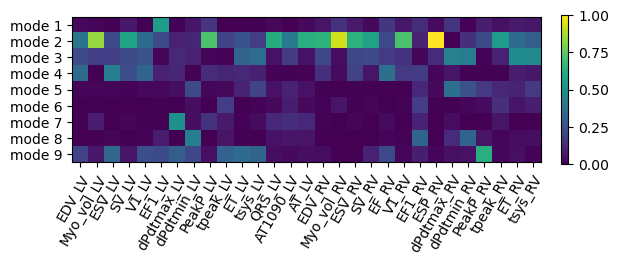

In [71]:
modes = ["mode 1", "mode 2", "mode 3", "mode 4",
              "mode 5", "mode 6", "mode 7", "mode 8", "mode 9"]
outputs = list(modelOutputOrig.columns)

fig, ax = plt.subplots()
im = ax.imshow(Si_first/np.max(Si_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [70]:
Si_first

array([[ 2.14167990e-02,  1.21786287e-02,  3.98003162e-03,
         5.46159071e-02,  6.38624258e-03,  4.50129651e-01,
         9.41839894e-03,  5.10993321e-02,  1.26229502e-01,
         1.89158242e-03,  9.94804052e-04,  6.27152708e-03,
         1.89584819e-02,  9.50013244e-04,  1.97469414e-02,
         4.37813438e-02,  1.19077238e-01,  5.94325995e-02,
         1.97978043e-02,  1.32539871e-01,  5.30211732e-02,
         1.05994265e-01,  2.25811665e-02,  1.25424766e-01,
         8.49654809e-03,  6.82600761e-02,  3.79947049e-02,
         5.99724130e-02,  5.22737505e-02],
       [ 3.14893742e-01,  6.92751929e-01,  1.87413522e-01,
         4.78697893e-01,  2.89620793e-01,  1.87484306e-01,
         7.51522307e-02,  8.58368627e-02,  5.87054338e-01,
         1.63703755e-01,  2.06044766e-01,  1.50407467e-01,
         5.08577215e-01,  3.38999677e-01,  5.13545429e-01,
         5.30284608e-01,  7.63049875e-01,  5.27460089e-01,
         4.73347491e-01,  1.82091531e-01,  5.86595750e-01,
         7.84

In [66]:
first_Si.iloc[:,0]

Mode 1    0.052274
Mode 2    0.243279
Mode 3    0.386765
Mode 4    0.052095
Mode 5    0.137299
Mode 6    0.068554
Mode 7    0.002566
Mode 8    0.030506
Mode 9    0.008208
Name: S1, dtype: float64